In [1]:
import cupy as cp
import torch

In [2]:
# Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import os
import json
import timeit

# Настройки отображения визуализации
fs = 18
matplotlib.rcParams['font.size'] = fs

In [3]:
def make_grid(N, L, center, **kwargs):
    """
    Создает трехмерную сетку из прямоугольных параллелепипедов и возвращает ее координаты
    и объем каждой ячейки.

    Parameters
    ----------
    n : list of int
        Список из трех целых чисел вида [n1, n2, n3], задающих количество ячеек
        дискретизации вдоль каждого измерения сетки (x, y, z).
    l : list of float
        Список из трех вещественных чисел вида [l1, l2, l1], задающих размеры
        прямоугольного параллелепипеда вдоль осей x, y, z.
    center : list of float
        Список из трех вещественных чисел вида [c1, c2, c3], определяющих координаты
        центра прямоугольного параллелепипеда в трехмерном пространстве.
    **kwargs
        Дополнительные аргументы (в текущей реализации не используются).

    Returns
    ----------
    grid, volume : (np.ndarray, float)
        Массив формы (n3 * n2 * n1, 3), где каждая строка содержит координаты (x, y, z)
        узловой точки в трехмерном пространстве.
        Объем одной ячейки разбиения (прямоугольного параллелепипеда).
    """
    # Границы сетки
    x = np.linspace(-L[0]/2 - center[0], L[0]/2 - center[0], N[0] + 1)
    y = np.linspace(-L[1]/2 - center[1], L[1]/2 - center[1], N[1] + 1)
    z = np.linspace(-L[2]/2 - center[2], L[2]/2 - center[2], N[2] + 1)
    # Объем ячейки
    h_x = x[1] - x[0]
    h_y = y[1] - y[0]
    h_z = z[1] - z[0]
    volume = h_x * h_y * h_z
    # Середины - точки коллокации
    x = (x[1:] + x[:-1])/2
    y = (y[1:] + y[:-1])/2
    z = (z[1:] + z[:-1])/2
    # Сетка - трехмерный тензор
    grid = np.array(np.meshgrid(x, y, z, indexing='ij')).T
    return grid, volume

In [4]:
def cylinder_refraction(grid,
                        eps_real, eps_imag,
                        center, radius,
                        axis=2,             # 0 – по X, 1 – по Y, 2 – по Z
                        axis_bounds=None):  # None или (low, high)
    """
    Присваивает комплексное значение eps_real + 1j*eps_imag узлам сетки,
    находящимся внутри цилиндра.

    Parameters
    ---------
    grid : np.ndarray
        Координатный тензор формы (n3, n2, n1, 3).
    eps_real, eps_imag : float | np.ndarray
        Вещественная и мнимая части диэлектрической проницаемости.
        Допускаются скаляры или тензоры (3, 3) – как в step_dielectric.
    center : tuple | list | np.ndarray длины 3
        Координаты произвольной точки на оси цилиндра
        (чаще всего – центра основания), (x_c, y_c, z_c).
    radius : float
        Радиус цилиндра.
    axis : int {0,1,2}, optional
        Ось, вдоль которой ориентирован цилиндр.
        0 → цилиндр «лежит» вдоль X, 1 → вдоль Y, 2 → вдоль Z.
    axis_bounds : None | tuple/list длины 2, optional
        Дополнительное ограничение по оси cylinder‑axis:
        [нижняя, верхняя] граница. Если None – без ограничений
        (т.е. цилиндр «бесконечен» вдоль этой оси внутри области расчёта).

    Returns
    ----------
    eps : np.ndarray
        Массив комплексных значений такой же формы, как в step_dielectric.
    indexes : np.ndarray[bool]
        Булев тензор (n3, n2, n1), True – узел попал в цилиндр.
    """
    # -------------------- подготовка --------------------
    n3, n2, n1, _ = grid.shape

    # форма выходного тензора зависит от размерности eps_real
    eps_shape = np.array(eps_real).shape
    eps = np.zeros([n3, n2, n1] + list(eps_shape), dtype=np.complex128)

    # -------------------- радиальное условие ------------
    # Какие координаты образуют радиальное сечение?
    # Если axis = 2 (Z), то радиальный слой – (X, Y) → индексы (0,1)
    all_axes = {0, 1, 2}
    radial_axes = list(all_axes - {axis})     # две оставшиеся оси

    # Координаты узлов в радиальной плоскости
    r1 = grid[..., radial_axes[0]]
    r2 = grid[..., radial_axes[1]]

    # Координаты центра в этих же плоскостях
    c1 = center[radial_axes[0]]
    c2 = center[radial_axes[1]]

    # квадрат расстояния до оси цилиндра
    r2_sq = (r1 - c1) ** 2 + (r2 - c2) ** 2
    radial_condition = r2_sq <= radius ** 2

    # -------------------- условие по оси цилиндра -------
    if axis_bounds is None:
        axial_condition = np.ones_like(radial_condition, dtype=bool)
    else:
        low, high = axis_bounds
        axial_coord = grid[..., axis]
        axial_condition = (axial_coord >= low) & (axial_coord <= high)

    # -------------------- итоговый индекс ---------------
    indexes = radial_condition & axial_condition

    # -------------------- присваивание eps --------------
    eps[indexes] = np.asarray(eps_real) + 1j * np.asarray(eps_imag)

    return eps, indexes


def step_refraction(grid, eps_real, eps_imag,
                    x1_bounds, x2_bounds, x3_bounds):
    """
    Присваивает в тензоре eps комплексные значения диэлектрической проницаемости eps_real + 1j * eps_imag
    в пределах прямоугольной области, заданной границами по осям x1_bounds, x2_bounds и x3_bounds.

    Parameters
    ----------
    grid : numpy.ndarray
        Координатный тензор размерности (n3, n2, n1, 3), где в последнем измерении
        хранятся координаты (x, y, z) для каждой точки сетки.
    eps_real : float или numpy.ndarray
        Вещественная часть диэлектрической проницаемости. Может иметь размерность (3, 3)
        для электродинамики или (1,) для акустики.
    eps_imag : float или numpy.ndarray
        Мнимая часть диэлектрической проницаемости. Может иметь размерность (3, 3)
        для электродинамики или (1,) для акустики.
    x1_bounds : list или tuple длины 2
        Границы по оси X1 (ось 0 в последнем измерении grid), [нижняя, верхняя].
    x2_bounds : list или tuple длины 2
        Границы по оси X2 (ось 1 в последнем измерении grid), [нижняя, верхняя].
    x3_bounds : list или tuple длины 2
        Границы по оси X3 (ось 2 в последнем измерении grid), [нижняя, верхняя].

    Returns
    -------
    eps, indexes : (np.ndarray, np.ndarray[bool])
        Комплексный тензор неоднородностей размерности (n3, n2, n1, ...) в соответствии с размерностью eps_real.
        Для электродинамики (n3, n2, n1, 3, 3), для акустики (n3, n2, n1).
        Логический тензор размерности (n3, n2, n1), показывающий, какие узлы сетки попали
        в заданную прямоугольную область и получили значение eps_real + 1j * eps_imag.
    """
    if eps_real is None:
        eps_real = [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
    if eps_imag is None:
        eps_imag = [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
    if x1_bounds is None:
        x1_bounds = [-1.0, 0.5]
    if x2_bounds is None:
        x2_bounds = [-1.0, 1.0]
    if x3_bounds is None:
        x3_bounds = [-1.0, 1.0]
        
    # Создаем выходной тензор eps со значениями 0.0j
    eps = np.zeros((grid.shape[:-1])) + 0.0j
    
    # Формируем логический индекс (indexes), определяя, какие точки принадлежат заданному прямоугольнику
    indexes = ((grid[..., 0] >= x1_bounds[0]) * (grid[..., 0] <= x1_bounds[1]) *
               (grid[..., 1] >= x2_bounds[0]) * (grid[..., 1] <= x2_bounds[1]) *
               (grid[..., 2] >= x3_bounds[0]) * (grid[..., 2] <= x3_bounds[1]))

    # Присваиваем комплексное значение диэлектрической проницаемости в выбранных точках
    eps[indexes] = np.array(eps_real) + 1j * np.array(eps_imag)
    return eps, indexes


def ellipsis_refraction(grid, eps_real, eps_imag,
                        center, radius):
    """
    Присваивает в тензоре eps комплексные значения диэлектрической проницаемости eps_real + 1j * eps_imag
    внутри эллипсоида, заданного центром center и радиусами radius по каждой оси.

    Parameters
    ----------
    grid : numpy.ndarray
        Координатный тензор размерности (n3, n2, n1, 3), где в последнем измерении
        хранятся координаты (x, y, z) для каждой точки сетки.
    eps_real : float или numpy.ndarray
        Вещественная часть диэлектрической проницаемости. Может иметь размерность (3, 3)
        для электродинамики или (1,) для акустики.
    eps_imag : float или numpy.ndarray
        Мнимая часть диэлектрической проницаемости. Может иметь размерность (3, 3)
        для электродинамики или (1,) для акустики.
    center : list или tuple длины 3
        Координаты центра эллипсоида (x, y, z).
    radius : list или tuple длины 3
        Радиусы эллипсоида по каждой оси (rx, ry, rz).

    Returns
    -------
    eps, indexes : (np.ndarray, np.ndarray[bool])
        Комплексный тензор неоднородностей размерности (n3, n2, n1, ...) в соответствии с размерностью eps_real.
        Для электродинамики (n3, n2, n1, 3, 3), для акустики (n3, n2, n1).
        Логический тензор размерности (n3, n2, n1), показывающий, какие узлы сетки попали
        в заданный эллипсоид и получили значение eps_real + 1j * eps_imag.
    """
    if eps_real is None:
        eps_real = [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
    if eps_imag is None:
        eps_imag = [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
    if center is None:
        center = [0.0, 0.0, 0.0]
    if radius is None:
        radius = [1.0, 1.0, 1.0]

    # Создаем выходной тензор eps со значениями 0.0j
    eps = np.zeros((grid.shape[:-1])) + 0.0j
    
    # Формируем логический индекс (indexes), определяя, какие точки внутри эллипсоида
    # Уравнение эллипсоида в центрированных координатах:
    # ((x - cx)^2 / rx^2) + ((y - cy)^2 / ry^2) + ((z - cz)^2 / rz^2) <= 1
    indexes = (
        ((grid[..., 0] - center[0]) ** 2) / (radius[0] ** 2) +
        ((grid[..., 1] - center[1]) ** 2) / (radius[1] ** 2) +
        ((grid[..., 2] - center[2]) ** 2) / (radius[2] ** 2)
    ) <= 1
    # Присваиваем комплексное значение диэлектрической проницаемости в выбранных точках
    eps[indexes] = np.array(eps_real) + 1j * np.array(eps_imag)
    return eps, indexes


def apply_refraction(grid, env_value=0.0, method=None,
                     eps_vec=None, **kwargs):
    """
    Присваивает значения диэлектрических неоднородностей в узлах сеточного разбиения.

    Параметры
    ----------
    grid : numpy.ndarray
        Тензор координат размерности (n3, n2, n1, 3), где в последнем измерении
        хранятся координаты (x, y, z) для каждой точки сетки.
    eps_vec : dict или list of dict, optional
        Конфигурации (список) неоднородностей, каждая в виде словаря, например:
        {
            "type": "step",           # или "ellipsis"
            "eps_real": ...,          # float или np.ndarray (3x3) для электродинамики,
                                      # float или np.ndarray (1,) для акустики
            "eps_imag": ...,
            "x1_bounds": [..., ...],  # для type='step'
            "x2_bounds": [..., ...],
            "x3_bounds": [..., ...],
            "center": [..., ..., ...],  # для type={'ellipsis', 'cylinder'}
            "radius": [..., ..., ...],  # для type={'ellipsis', 'cylinder'}
            "axis": ...,                # для type='cylinder'
            "axis_boounds": [..., ...]   # для type='cylinder'
        }
        Если не задан, по умолчанию содержится один "step" со значениями eps=1.0.
    method : str, optional
        Метод определения значений в узлах сетки:
        - 'sub': заменить значения среды в заданных областях,
        - 'add': добавить (суммировать) значения к уже существующим.
        По умолчанию: 'sub'.
    value_environment : complex, optional
        Комплексное значение окружающей среды (реальная и мнимая части).
        По умолчанию: (0.0 + 0.0j).
    **kwargs : dict
        Дополнительные параметры из конфигурации, которые могут потребоваться
        при расширении функционала.

    Returns
    ----------
    eps, indexes : (np.ndarray, np.ndarray[bool])
        Комплексный тензор неоднородности размерности (n3, n2, n1, ...) в
        соответствии с размерностью eps_real из eps_vec.
        - (n3, n2, n1, 3, 3) для электродинамики с диэлектрической проницаемостью,
        - (n3, n2, n1) для акустической задачи с рефракцией.
        Булев массив размерности (n3, n2, n1), показывающий, в каких узлах
        было присвоено значение eps_real + 1j * eps_imag из описанных
        неоднородностей.

    Notes
    ----------
    При инициализации среды (eps) задаётся значение value_environment во всех
    узлах сетки. Далее, для каждой конфигурации из eps_vec (step или ellipsis)
    вычисляются локальные значения eps_d и маска indexes_d. В соответствии
    с параметром method локальные значения либо подставляются, либо суммируются
    в итоговый тензор eps. Параллельно собирается общая маска indexes, где
    отмечены все узлы, попавшие хотя бы в одну из неоднородных областей.
    """
    if method is None:
        method = 'add'
    if eps_vec is None:
        eps_vec = [
            {
                "type": "step",
                "eps_real": 1.0,
                "eps_imag": 0.0,
                "x1_bounds": [-1.0, 0.0],
                "x2_bounds": [-1.0, 1.0],
                "x3_bounds": [-1.0, 1.0]
            },
            {
                "type": "ellipsis",
                "eps_real": 1.0,
                "eps_imag": 0.0,
                "center": [0.0, 0.0, 0.0],
                "radius": [1.0, 1.0, 1.0]
            }
        ]
    
    eps = np.full((grid.shape[:-1]), fill_value=env_value.real) + 1j * env_value.imag
    indexes = np.zeros(grid.shape[:-1], dtype=bool)
    for num, element in enumerate(eps_vec):
        if element.get("type") == "step":
            eps_d, indexes_d = step_refraction(grid=grid,
                                               eps_real=element.get('eps_real'),
                                               eps_imag=element.get('eps_imag'),
                                               x1_bounds=element.get('x1_bounds'),
                                               x2_bounds=element.get('x2_bounds'),
                                               x3_bounds=element.get('x3_bounds'))
        elif element.get("type") == "ellipsis":
            eps_d, indexes_d = ellipsis_refraction(grid=grid,
                                                   eps_real=element.get('eps_real'),
                                                   eps_imag=element.get('eps_imag'),
                                                   center=element.get('center'),
                                                   radius=element.get('radius'))
        elif element.get("type") == "cylinder":
            eps_d, indexes_d = cylinder_refraction(grid=grid,
                                                   eps_real=element.get('eps_real'),
                                                   eps_imag=element.get('eps_imag'),
                                                   center=element.get('center'),
                                                   radius=element.get('radius'),
                                                   axis=element.get('axis'),
                                                   axis_bounds=element.get('axis_bounds'))
        else:
            # Неизвестный тип неоднородности – пропускаем
            continue
            
        indexes += indexes_d
        if method == 'sub':
            eps[indexes_d] = eps_d[indexes_d]
        else:
            eps += eps_d
    return eps, indexes

In [5]:
def cylinder_refraction(grid,
                        eps_real, eps_imag,
                        center, radius,
                        axis=2,             # 0 – по X, 1 – по Y, 2 – по Z
                        axis_bounds=None):  # None или (low, high)
    """
    Присваивает комплексное значение eps_real + 1j*eps_imag узлам сетки,
    находящимся внутри цилиндра.

    Parameters
    ---------
    grid : np.ndarray
        Координатный тензор формы (n3, n2, n1, 3).
    eps_real, eps_imag : float | np.ndarray
        Вещественная и мнимая части диэлектрической проницаемости.
        Допускаются скаляры или тензоры (3, 3) – как в step_dielectric.
    center : tuple | list | np.ndarray длины 3
        Координаты произвольной точки на оси цилиндра
        (чаще всего – центра основания), (x_c, y_c, z_c).
    radius : float
        Радиус цилиндра.
    axis : int {0,1,2}, optional
        Ось, вдоль которой ориентирован цилиндр.
        0 → цилиндр «лежит» вдоль X, 1 → вдоль Y, 2 → вдоль Z.
    axis_bounds : None | tuple/list длины 2, optional
        Дополнительное ограничение по оси cylinder‑axis:
        [нижняя, верхняя] граница. Если None – без ограничений
        (т.е. цилиндр «бесконечен» вдоль этой оси внутри области расчёта).

    Returns
    ----------
    eps : np.ndarray
        Массив комплексных значений такой же формы, как в step_dielectric.
    indexes : np.ndarray[bool]
        Булев тензор (n3, n2, n1), True – узел попал в цилиндр.
    """
    # -------------------- подготовка --------------------
    n3, n2, n1, _ = grid.shape

    # форма выходного тензора зависит от размерности eps_real
    eps_shape = np.array(eps_real).shape
    eps = np.zeros([n3, n2, n1] + list(eps_shape), dtype=np.complex128)

    # -------------------- радиальное условие ------------
    # Какие координаты образуют радиальное сечение?
    # Если axis = 2 (Z), то радиальный слой – (X, Y) → индексы (0,1)
    all_axes = {0, 1, 2}
    radial_axes = list(all_axes - {axis})     # две оставшиеся оси

    # Координаты узлов в радиальной плоскости
    r1 = grid[..., radial_axes[0]]
    r2 = grid[..., radial_axes[1]]

    # Координаты центра в этих же плоскостях
    c1 = center[radial_axes[0]]
    c2 = center[radial_axes[1]]

    # квадрат расстояния до оси цилиндра
    r2_sq = (r1 - c1) ** 2 + (r2 - c2) ** 2
    radial_condition = r2_sq <= radius ** 2

    # -------------------- условие по оси цилиндра -------
    if axis_bounds is None:
        axial_condition = np.ones_like(radial_condition, dtype=bool)
    else:
        low, high = axis_bounds
        axial_coord = grid[..., axis]
        axial_condition = (axial_coord >= low) & (axial_coord <= high)

    # -------------------- итоговый индекс ---------------
    indexes = radial_condition & axial_condition

    # -------------------- присваивание eps --------------
    eps[indexes] = np.asarray(eps_real) + 1j * np.asarray(eps_imag)

    return eps, indexes


def step_refraction(grid, eps_real, eps_imag,
                    x1_bounds, x2_bounds, x3_bounds):
    """
    Присваивает в тензоре eps комплексные значения диэлектрической проницаемости eps_real + 1j * eps_imag
    в пределах прямоугольной области, заданной границами по осям x1_bounds, x2_bounds и x3_bounds.

    Parameters
    ----------
    grid : numpy.ndarray
        Координатный тензор размерности (n3, n2, n1, 3), где в последнем измерении
        хранятся координаты (x, y, z) для каждой точки сетки.
    eps_real : float или numpy.ndarray
        Вещественная часть диэлектрической проницаемости. Может иметь размерность (3, 3)
        для электродинамики или (1,) для акустики.
    eps_imag : float или numpy.ndarray
        Мнимая часть диэлектрической проницаемости. Может иметь размерность (3, 3)
        для электродинамики или (1,) для акустики.
    x1_bounds : list или tuple длины 2
        Границы по оси X1 (ось 0 в последнем измерении grid), [нижняя, верхняя].
    x2_bounds : list или tuple длины 2
        Границы по оси X2 (ось 1 в последнем измерении grid), [нижняя, верхняя].
    x3_bounds : list или tuple длины 2
        Границы по оси X3 (ось 2 в последнем измерении grid), [нижняя, верхняя].

    Returns
    -------
    eps, indexes : (np.ndarray, np.ndarray[bool])
        Комплексный тензор неоднородностей размерности (n3, n2, n1, ...) в соответствии с размерностью eps_real.
        Для электродинамики (n3, n2, n1, 3, 3), для акустики (n3, n2, n1).
        Логический тензор размерности (n3, n2, n1), показывающий, какие узлы сетки попали
        в заданную прямоугольную область и получили значение eps_real + 1j * eps_imag.
    """
    # Извлекаем размеры сетки: кол-во точек вдоль осей n3, n2, n1 и координату (3)
    n3, n2, n1, _ = grid.shape

    # Определяем форму массива eps, исходя из формы eps_real
    eps_shape = np.array(eps_real).shape

    # Создаем выходной тензор eps со значениями 0.0j
    eps = np.zeros([n3, n2, n1] + list(eps_shape)) + 0.0j

    # Формируем логический индекс (indexes), определяя, какие точки принадлежат заданному прямоугольнику
    indexes = (
        (grid[..., 0] >= x1_bounds[0]) & (grid[..., 0] <= x1_bounds[1]) &
        (grid[..., 1] >= x2_bounds[0]) & (grid[..., 1] <= x2_bounds[1]) &
        (grid[..., 2] >= x3_bounds[0]) & (grid[..., 2] <= x3_bounds[1])
    )

    # Присваиваем комплексное значение диэлектрической проницаемости в выбранных точках
    eps[indexes] = np.array(eps_real) + 1j * np.array(eps_imag)

    return eps, indexes


def ellipsis_refraction(grid, eps_real, eps_imag, center, radius):
    """
    Присваивает в тензоре eps комплексные значения диэлектрической проницаемости eps_real + 1j * eps_imag
    внутри эллипсоида, заданного центром center и радиусами radius по каждой оси.

    Parameters
    ----------
    grid : numpy.ndarray
        Координатный тензор размерности (n3, n2, n1, 3), где в последнем измерении
        хранятся координаты (x, y, z) для каждой точки сетки.
    eps_real : float или numpy.ndarray
        Вещественная часть диэлектрической проницаемости. Может иметь размерность (3, 3)
        для электродинамики или (1,) для акустики.
    eps_imag : float или numpy.ndarray
        Мнимая часть диэлектрической проницаемости. Может иметь размерность (3, 3)
        для электродинамики или (1,) для акустики.
    center : list или tuple длины 3
        Координаты центра эллипсоида (x, y, z).
    radius : list или tuple длины 3
        Радиусы эллипсоида по каждой оси (rx, ry, rz).

    Returns
    -------
    eps, indexes : (np.ndarray, np.ndarray[bool])
        Комплексный тензор неоднородностей размерности (n3, n2, n1, ...) в соответствии с размерностью eps_real.
        Для электродинамики (n3, n2, n1, 3, 3), для акустики (n3, n2, n1).
        Логический тензор размерности (n3, n2, n1), показывающий, какие узлы сетки попали
        в заданный эллипсоид и получили значение eps_real + 1j * eps_imag.
    """
    # Извлекаем размеры сетки: кол-во точек вдоль осей n3, n2, n1 и координату (3)
    n3, n2, n1, _ = grid.shape

    # Определяем форму массива eps, исходя из формы eps_real
    eps_shape = np.array(eps_real).shape

    # Создаем выходной тензор eps со значениями 0.0j
    eps = np.zeros([n3, n2, n1] + list(eps_shape)) + 0.0j

    # Формируем логический индекс (indexes), определяя, какие точки внутри эллипсоида
    # Уравнение эллипсоида в центрированных координатах:
    # ((x - cx)^2 / rx^2) + ((y - cy)^2 / ry^2) + ((z - cz)^2 / rz^2) <= 1
    indexes = (
                      ((grid[..., 0] - center[0]) ** 2) / (radius[0] ** 2) +
                      ((grid[..., 1] - center[1]) ** 2) / (radius[1] ** 2) +
                      ((grid[..., 2] - center[2]) ** 2) / (radius[2] ** 2)
              ) <= 1

    # Присваиваем комплексное значение диэлектрической проницаемости в выбранных точках
    eps[indexes] = np.array(eps_real) + 1j * np.array(eps_imag)
    return eps, indexes


def apply_refraction(grid, eps_vec=None, method='sub',
                     value_environment=0.0 + 0.0j, **kwargs):
    """
    Присваивает значения диэлектрических неоднородностей в узлах сеточного разбиения.

    Параметры
    ----------
    grid : numpy.ndarray
        Тензор координат размерности (n3, n2, n1, 3), где в последнем измерении
        хранятся координаты (x, y, z) для каждой точки сетки.
    eps_vec : dict или list of dict, optional
        Конфигурации (список) неоднородностей, каждая в виде словаря, например:
        {
            "type": "step",           # или "ellipsis"
            "eps_real": ...,          # float или np.ndarray (3x3) для электродинамики,
                                      # float или np.ndarray (1,) для акустики
            "eps_imag": ...,
            "x1_bounds": [..., ...],  # для type='step'
            "x2_bounds": [..., ...],
            "x3_bounds": [..., ...],
            "center": [...],          # для type='ellipsis'
            "radius": [...]
        }
        Если не задан, по умолчанию содержится один "step" со значениями eps=1.0.
    method : str, optional
        Метод определения значений в узлах сетки:
        - 'sub': заменить значения среды в заданных областях,
        - 'add': добавить (суммировать) значения к уже существующим.
        По умолчанию: 'sub'.
    value_environment : complex, optional
        Комплексное значение окружающей среды (реальная и мнимая части).
        По умолчанию: (0.0 + 0.0j).
    **kwargs : dict
        Дополнительные параметры из конфигурации, которые могут потребоваться
        при расширении функционала.

    Returns
    ----------
    eps, indexes : (np.ndarray, np.ndarray[bool])
        Комплексный тензор неоднородности размерности (n3, n2, n1, ...) в
        соответствии с размерностью eps_real из eps_vec.
        - (n3, n2, n1, 3, 3) для электродинамики с диэлектрической проницаемостью,
        - (n3, n2, n1) для акустической задачи с рефракцией.
        Булев массив размерности (n3, n2, n1), показывающий, в каких узлах
        было присвоено значение eps_real + 1j * eps_imag из описанных
        неоднородностей.

    Notes
    ----------
    При инициализации среды (eps) задаётся значение value_environment во всех
    узлах сетки. Далее, для каждой конфигурации из eps_vec (step или ellipsis)
    вычисляются локальные значения eps_d и маска indexes_d. В соответствии
    с параметром method локальные значения либо подставляются, либо суммируются
    в итоговый тензор eps. Параллельно собирается общая маска indexes, где
    отмечены все узлы, попавшие хотя бы в одну из неоднородных областей.
    """

    # Конфигурация неоднородностей по умолчанию (если не задано eps_vec)
    if eps_vec is None:
        eps_vec = [
            {
                "type": "step",
                "eps_real": [[1.0, 0.0, 0.0],
                             [0.0, 1.0, 0.0],
                             [0.0, 0.0, 1.0]],
                "eps_imag": [[0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0]],
                "x1_bounds": [-1.0, 1.0],
                "x2_bounds": [-1.0, 1.0],
                "x3_bounds": [-1.0, 1.0]
            }
        ]

    # Извлекаем размерность сетки (число точек вдоль n3, n2, n1 и координатное измерение)
    n3, n2, n1, _ = grid.shape

    # Определяем форму массива eps, исходя из первого элемента (eps_real)
    eps_shape = np.array(eps_vec[0].get('eps_real')).shape

    # Инициализируем тензор eps значениями комнатной (внешней) среды
    # Мнимая часть добавляется отдельно через 1j.
    eps = np.full([n3, n2, n1] + list(eps_shape), fill_value=value_environment.real) + \
        1j * value_environment.imag

    # Булев массив, отмечающий, в каких узлах были присвоены неоднородности
    indexes = np.zeros([n3, n2, n1], dtype=bool)

    # Вспомогательные массивы для текущей конфигурации
    eps_d = np.zeros([n3, n2, n1] + list(eps_shape))
    indexes_d = np.zeros([n3, n2, n1], dtype=bool)

    for num, element in enumerate(eps_vec):
        # Разбор типов неоднородностей в конфигурации
        if element.get("type") == "step":
            eps_d, indexes_d = step_refraction(grid=grid,
                                               eps_real=element.get('eps_real'),
                                               eps_imag=element.get('eps_imag'),
                                               x1_bounds=element.get('x1_bounds'),
                                               x2_bounds=element.get('x2_bounds'),
                                               x3_bounds=element.get('x3_bounds'))
        elif element.get("type") == "ellipsis":
            eps_d, indexes_d = ellipsis_refraction(grid=grid,
                                                   eps_real=element.get('eps_real'),
                                                   eps_imag=element.get('eps_imag'),
                                                   center=element.get('center'),
                                                   radius=element.get('radius'))
        elif element.get("type") == "cylinder":
            eps_d, indexes_d = cylinder_refraction(grid=grid,
                                                   eps_real=element.get('eps_real'),
                                                   eps_imag=element.get('eps_imag'),
                                                   center=element.get('center'),
                                                   radius=element.get('radius'),
                                                   axis=element.get('axis'),
                                                   axis_bounds=element.get('axis_bounds'))
        else:
            # Неизвестный тип неоднородности – пропускаем
            continue

        # Обновляем общие индексы (где либо step, либо ellipsis, либо оба)
        indexes += indexes_d

        # В зависимости от способа объединения (замена или добавление)
        if method.lower() == 'sub':
            # Заменяем значение среды в узлах, где indexes_d == True
            eps[indexes_d] = eps_d[indexes_d]
        else:
            # Суммируем текущее значение с eps_d во всех узлах
            eps += eps_d

    return eps, indexes

In [6]:
def kernel(x, k=1.0, **kwargs):
    """
    Функция Грина для объемного волнового уравнения Гельмгольца. Определяет значения функции для аргумента x,
    по умолчанию считается положительным значением расстояния между точками объемного пространства

    Parameters
    ----------
    x:  np.ndarray
        Тензор с вещественными значениями расстояния между точками пространства.
    k : float, по умолчанию 1.0
        Волновое число (пространственная частота) для плоской волны.

    Returns
    ----------
    kernel_values: np.ndarray
        Тензор с комплексными значениями функции Грина, размерности как и у тензора x.
    """
    return np.exp(1j * k * x) / (4 * np.pi * x)


def flat_wave_scalar(x, k=1, orient=None, sign=1, amplitude=1.0, phi0=0.0, **kwargs):
    """
    Определяет значения внешнего излучения в виде скалярной плоской волны на точках заданного объёма пространства.
    Используется для решения скалярных задач распространения и рассеяния волн,
    в частности в объемных задачах акустики.

    Parameters
    ----------
    grid : np.ndarray
        Тензор размерности (n3, n2, n1, 3), в котором для каждой точки пространства хранится координата (x, y, z).
    k : float, по умолчанию 1.0
        Волновое число (пространственная частота) для плоской волны.
    orient : list[float], длиной 3, по умолчанию None
        Вектор распространения плоской волны. Если не задан, по умолчанию считается [1.0, 1.0, 1.0].
    amplitude : float, по умолчанию 1.0
        Амплитуда плоской волны. Если не задан, по умолчанию принимается 1.0.
    sign : int, по умолчанию 1
        Направление распространения волны: 1 означает распространение вдоль заданного направления, -1 — в обратном.
    phi0 : float, по умолчанию 0.0
        Начальная фаза.
    kwargs : dict
        Дополнительные параметры, которые могут быть переданы из конфигурационных файлов или др. источников.

    Returns
    ----------
    wave : np.ndarray
        Тензор размерности (n3, n2, n1), где для каждой точки пространства (x, y, z) хранится скалярное
        комплексное значение (срез [...] в последнее измерение размером 1), соответствующих внешнему излучению
        в виде скалярного поля напряженности среды.
    """
    if orient is None:
        orient = [1.0, 1.0, 1.0]

    # Нормализация вектора направления колебаний
    orient = np.array(orient) / np.linalg.norm(np.array(orient), 2)
    # Определение фазы колебаний плоской волны
    phase = np.exp(sign * 1j * k * grid.dot(orient) - phi0)
    # Определение значений волны в точках пространства
    wave = amplitude * phase
    return wave


def point_scalar_wave(grid, point=None, k=1.0, orient=None, amplitude=1.0, phi0=0.0, **kwargs):
    if point is None:
        point = np.array([0., 0., 0.])
    else:
        point = np.array(point)

    if orient is None:
        orient = np.array([1.0, 1.0, 0.0])
    else:
        orient = np.array([x / max(orient) for x in orient])

    diffs = ((grid - point[np.newaxis, np.newaxis, np.newaxis, :]) * orient[np.newaxis, np.newaxis, np.newaxis, :])
    dists = np.sqrt(np.sum(diffs**2, axis=-1))
    wave = amplitude * np.exp(1j * dists * k - phi0)
    return wave

Пошаговый разбор тела функции
-----------------------------

1. n, m, k = col_arr.shape  
   • Извлекаем размеры переданной «колонки».  
   • Затем мы их удвоим, чтобы исключить циклическое наложение.

2. circulant_tensor = np.zeros((2 * n, 2 * m, 2 * k)) + 0.0j  
   • Выделяем нулевой комплексный массив формы (2n, 2m, 2k).  
   • Добавление + 0.0j гарантирует комплексный dtype.

3. circulant_tensor[:n, :m, :k] = col_arr[:n, :m, :k]  
   • Копируем исходные данные в *передний-левый-верхний* октант (исходный блок).

4. circulant_tensor[n + 1:2 * n, :m, :k] = col_arr[n:0:-1, :m, :k]  
   • Зеркалим col_arr по первой оси (x).  
   • Индекс n+1 пропускает центральный срез, чтобы не дублировать элемент (0,⋅,⋅).

5. circulant_tensor[:n, m + 1:2 * m, :k] = col_arr[:n, m:0:-1, :k]  
   • Зеркалим по второй оси (y) и вставляем в передний-правый октант.

6. circulant_tensor[:n, :m, k + 1:2 * k] = col_arr[:n, :m, k:0:-1]  
   • Зеркалим по третьей оси (z) ‒ задний-левый-верхний октант.

7. circulant_tensor[n + 1:2 * n, m + 1:2 * m, :k] = col_arr[n:0:-1, m:0:-1, :k]  
   • Одновременное отражение по осям 1 и 2 – задний-правый-верхний сектор.

8. circulant_tensor[:n, m + 1:2 * m, k + 1:2 * k] = col_arr[:n, m:0:-1, k:0:-1]  
   • Отражения по осям 2 и 3 – передний-правый-задний сектор.

9. circulant_tensor[n + 1:2 * n, :m, k + 1:2 * k] = col_arr[n:0:-1, :m, k:0:-1]
• Отражения по осям 1 и 3 – задний-левый-задний сектор.

10. circulant_tensor[n + 1:2 * n, m + 1:2 * m, k + 1:2 * k] = col_arr[n:0:-1, m:0:-1, k:0:-1]  
    • Отражение сразу по трём осям – заполняем последний октант.

11. circulant_tensor = np.fft.fftn(circulant_tensor)  
    • Вычисляем прямое N-D FFT (fftn) по всем осям.  
    • Полученные значения ‒ это диагональ оператора BCCB в базисе Фурье.

12. return circulant_tensor  
    • Возвращаем частотное представление – его можно кэшировать и
      многократно использовать для быстрых умножений или свёрток.

Назначение и типичный сценарий использования (человеческими словами)
--------------------------------------------------------------------
prep_fftbbtensor берёт минимальный набор чисел, описывающий
трёхмерный блок-циркулянтный оператор (например, ядро свёртки или
функцию Грина), и переводит его в форму, где оператор уже
диагонализирован БПФ.  После этого применение оператора к любому
данному кубу осуществляется за три шага:

  1. Дополнить данные до размера (2n, 2m, 2k).

  2. Взять их FFT и покомпонентно умножить на заранее вычисленный
     circulant_tensor.

  3. Выполнить обратный FFT и обрезать результат.

Самая тяжёлая часть (построение тензора и первый FFT) делается один раз
вне цикла, благодаря чему массовые вычисления 3-D свёрток или
матрица-векторных произведений выполняются на порядки быстрее, чем при
прямом расчёте в пространственной области.

# Описание реализации
Разработанная реализация вычисления Фурье-образа коэффициентов трехуровневой блочно-циркулянтной матрицы в виде функции **prep_fftbbtensor** принимает на вход трёхмерный массив размера $(n_3, n_2, n_1)$ – «первую колонку» блочно-Тёплицевого тензора.  В обычном представлении данный блочно-Теплицевый оператор хранился бы как двумерный массив из $(N_3 \cdot N_2 \cdot N_1) \times (N_3 \cdot N_2 \cdot N_1)$ элементов, образующих Теплицевые $n_1\times n_1$ блоки, составляющие $(N_2\cdot N_1) \times (N_2 \cdot N_1)$ блочно-Тёплицевые матрицы. Для случая симметричного ядра интегрального уравнения (в скалярной задаче) для такого тензора достаточно знать всего один минимальный набор коэффициентов, а именно значения в нулевой позиции и все их циклические сдвиги вдоль трёх координатных осей.  Именно этот компактный набор и передаётся на вход функции в параметре col_arr в виде трехмерного массива размера $N_3 \times N_2 \times N_1$.  Задача функции – из данного массива восстановить полный тензор, затем сразу же перенести его в частотную область, где оператор становится диагональным и готов к использованию в итерационных методах.

Чтобы достроить полный тензор без искажений, алгоритм использует технику циркулянтного встраивания.  Размер каждой оси удваивается: получается массив формы $2N_3\times 2N_2 \times 2N_1$. В первой восьмой части (передний-левый-верхний октант) просто размещается исходный массив col_arr.  Остальные семь октантов заполняются зеркальными копиями исходных данных, отражёнными по одной, двум или трём координатным осям.  Такая симметричная раскладка делает тензор периодичным и устраняет эффект наложения, который неминуемо возник бы при вычислении свёрток в пространстве с периодическими границами.  Как только все сектора заполнены, массив удовлетворяет условиям блочной циркулянтности во всех направлениях.

На следующем этапе к полученному трехмерному массиву размера $2N_3\times 2N_2 \times 2N_1$ применяется трехмерное быстрое преобразование Фурье из стандартной библиотеки методов (numpy.fft.fftn).  БПФ «диагонализирует» блочно-циркулянтный оператор. В фурье-базисе он превращается в простой набор комплексных масштабирующих коэффициентов, расположенных элемент-к-элементу.  Это означает, что дальнейшее умножение оператора на произвольный объём данных сводится к покомпонентному произведению двух одинаково размерных тензоров в частотной области, после чего необходимо произвести вычисление одного обратного БПФ и обрезка лишних половин.  Главный выигрыш здесь – стоимость такой операции растёт как $O(N log N)$, где $N = 8\cdot N_1 N_2 N_3$, а не $O(N^2)$ как при прямом умножении.

Практически функция служит «препроцессором». Её вызывают один раз, например, для вычисления ядра свёртки или дискретизованной функции Грина, а вернувшийся спектр circulant_tensor_hat кэшируют.  Далее в цикле можно многократно применять оператор, используя быстрое умножение в итерационном методе решения системы уравнений с блочно-Тёплицевой матрицей. За счёт предварительной подготовки удаётся получить значительный прирост скорости и снизить вычислительные затраты на порядок, оставаясь при этом в рамках удобного интерфейса NumPy.

In [7]:
def prep_fftbbtensor(col_arr):
    """
    Построение 3-D блок-циркулянтного тензора (circulant-block-circulant,
    BCCB) из его *первой «колонки»* и немедленно преобразовать полученный
    тензор в частотную область при помощи N-мерного БПФ.

    Параметры
    ---------
    col_arr : ndarray, shape (n3, n2, n1), dtype float или complex
        «Колонка», полностью задающая 3-D BCCB-тензор.
        • Любой BCCB-тензор однозначно определяется элементами своей
          первой колонки ‒ позицией (0,0,0) и всеми её сдвигами вдоль
          трёх осей.  col_arr хранит именно этот набор элементов с
          размерностью (n3, n2, n1), где
              n1 … размер по первой (x) оси,
              n2 … размер по второй (y) оси,
              n3 … размер по третьей (z) оси.

    Возвращает
    ----------
    circulant_tensor_hat : ndarray, shape (2*n3, 2*n2, 2*n1), dtype complex
        3-D БПФ *встроенного* BCCB-тензора.  После этого умножение
        n3×n2×n1-массива на соответствующий BCCB-оператор можно выполнять
        покомпонентно в частотной области с последующим обратным БПФ,
        затрачивая O((2*n3)(2*n2)(2*n1) log((2*n3)(2*n2)(2*n1))) операций.

    Примечания
    ----------
    1. Функция делает *циркулянтное встраивание* (circulant embedding):
       исходный col_arr отражается (зеркалируется) по каждой из трёх
       осей и переносится в соответствующие октанты массива размера
       2n3×2n2×2n1.  Итоговый тензор эрмитово-симметричен, а его блок
       слева-сверху-спереди размером n3×n2×n1 совпадает с переданными
       данными.
    2. Встраивание необходимо, потому что FFT в NumPy предполагает
       периодические границы.  Удвоение размера препятствует
       «зацикливанию» (aliasing), когда тензор применяют для линейной
       свёртки или как Toeplitz/BCCB-оператор.
    3. Приём широко используется в обработке изображений и научных
       вычислениях, где приходится многократно выполнять 3-D свёртки
       или решать линейные системы с пространственно-инвариантным
       ядром.

    Примеры
    -------
    >>> kernel = np.random.randn(5, 4, 6)
    >>> C_hat = prep_fftbbtensor(kernel)
    >>> # Применяем полученный BCCB-оператор к кубу данных x
    >>> x = np.random.randn(5, 4, 6)
    >>> y_hat = C_hat * np.fft.fftn(np.pad(x, ((0,5), (0,4), (0,6))))
    >>> y = np.fft.ifftn(y_hat).real[:5, :4, :6]   # результат в пространстве
    """
    # Извлекаем размеры переданной «колонки»
    n3, n2, n1 = col_arr.shape
    col_arr = cp.array(col_arr)
    # Выделяем нулевой комплексный массив формы (2n, 2m, 2k)
    circulant_tensor = cp.zeros((2 * n3, 2 * n2, 2 * n1)) + 0.0j
    # Копируем исходные данные в передний-левый-верхний октант (исходный блок)
    circulant_tensor[:n3, :n2, :n1] = col_arr[:n3, :n2, :n1]
    # Зеркалим col_arr по третьей оси (z)
    circulant_tensor[n3 + 1:2 * n3, :n2, :n1] = col_arr[n3:0:-1, :n2, :n1]
    # Зеркалим col_arr по второй оси (y) передний-правый октант
    circulant_tensor[:n3, n2 + 1:2 * n2, :n1] = col_arr[:n3, n2:0:-1, :n1]
    # Зеркалим col_arr по первой оси (x) в задний-левый-верхний октант
    circulant_tensor[:n3, :n2, n1 + 1: 2 * n1] = col_arr[:n3, :n2, n1:0:-1]
    # Одновременное отражение по осям 3 и 2 – задний-правый-верхний сектор
    circulant_tensor[(n3 + 1):(2 * n3), (n2 + 1):(2 * n2), :n1] = col_arr[n3:0:-1, n2:0:-1, :n1]
    # Отражения по осям 2 и 1 – передний-правый-задний сектор
    circulant_tensor[:n3, (n2 + 1):(2 * n2), (n1 + 1):(2 * n1)] = col_arr[:n3, n2:0:-1, n1:0:-1]
    # Отражения по осям 3 и 1 – задний-левый-задний сектор.
    circulant_tensor[(n3 + 1):(2 * n3), :n2, (n1 + 1):(2 * n1)] = col_arr[n3:0:-1, :n2, n1:0:-1]
    # Отражение сразу по трём осям – заполняем последний октант
    circulant_tensor[(n3 + 1):(2 * n3), (n2 + 1):(2 * n2), (n1 + 1):(2 * n1)] = col_arr[n3:0:-1, n2:0:-1, n1:0:-1]
    # Вычисляем прямое N-D FFT (fftn) по всем осям.
    circulant_tensor = cp.fft.fftn(circulant_tensor)
    return circulant_tensor


def prep_fbbtmv(prep_fft_arr, vec_arr):
    n, m, k = vec_arr.shape
    x_arr = cp.zeros((2 * n, 2 * m, 2 * k)) + 0.0j
    x_arr[:n, :m, :k] = vec_arr[:n, :m, :k]
    prep_fft_arr = cp.fft.ifftn(prep_fft_arr * cp.fft.fftn(x_arr))
    return prep_fft_arr[:n, :m, :k]


def operator(prep_array, vector_array, nu):
    n3, n2, n1 = vector_array.shape
    result = cp.zeros((n3, n2, n1)) + 0.0j
    vec_array = nu * vector_array
    result = prep_fbbtmv(prep_array, vec_array)
    result = vector_array - result
    return result


def conj_operator(conj_prep_array, vector_array, nu):
    n3, n2, n1 = vector_array.shape
    result = cp.zeros((n3, n2, n1, )) + 0.0j
    result = cp.conj(nu) * prep_fbbtmv(conj_prep_array, vector_array)
    result = vector_array - result
    return result

In [8]:
def cross(o, a, b):
    """
    Вычисляет векторное произведение векторов OA и OB.

    Parameters
    ----------
    o : tuple of (float, float)
        Координаты точки O (x, y).
    a : tuple of (float, float)
        Координаты точки A (x, y).
    b : tuple of (float, float)
        Координаты точки B (x, y).

    Returns
    -------
    float
        Результат векторного произведения (OA x OB). Положительное значение
        говорит о повороте против часовой стрелки, отрицательное — о повороте
        по часовой стрелке, а ноль означает, что точки лежат на одной прямой.
    """
    return (a[0] - o[0]) * (b[1] - o[1]) - (a[1] - o[1]) * (b[0] - o[0])


def sequential_chain(points):
    """
    Построение минимальной выпуклой оболочки заданного набора точек
    на плоскости методом последовательной цепи (алгоритм Эндрю).

    Parameters
    ----------
    points : list of tuple of (float, float)
        Список координат точек (x, y).

    Returns
    -------
    list of tuple of (float, float)
        Список координат (x, y), формирующих выпуклую оболочку.
        Порядок обхода может быть по часовой или против часовой стрелки,
        в зависимости от сортировки.

    Notes
    -----
    Алгоритм предусматривает:
      1. Сортировку всех точек лексикографически (сначала по x, потом по y).
      2. Построение нижней цепи (lower chain), убирая вершины, при которых
         поворот не против часовой стрелки.
      3. Построение верхней цепи (upper chain) аналогичным образом.
      4. Слияние результата нижней и верхней цепей в выпуклую оболочку.

    Примечания:
      - Если имеется только одна точка в наборе, она и является оболочкой.
      - При использовании set() для удаления дубликатов важно повторно сортировать,
        чтобы сохранить порядок точек.

    Examples
    --------
    >>> pts = [(0, 0), (1, 1), (1, 0), (0, 1), (2, 2)]
    >>> sequential_chain(pts)
    [(0, 0), (1, 0), (2, 2), (0, 1)]
    """

    # Исключаем дублирующиеся точки с помощью set, а затем сортируем получившиеся точки
    points = sorted(set(points))
    if len(points) == 1:
        return points

    # Строим нижнюю оболочку
    lower = []
    for p in points:
        while len(lower) >= 2 and cross(lower[-2], lower[-1], p) <= 0:
            lower.pop()
        lower.append(p)

    # Строим верхнюю оболочку
    upper = []
    for p in reversed(points):
        while len(upper) >= 2 and cross(upper[-2], upper[-1], p) <= 0:
            upper.pop()
        upper.append(p)

    # Соединяем верхнюю и нижнюю оболочки
    # Последняя точка каждого списка совпадает с первой точкой другого списка, поэтому исключаем их
    convex = lower[:-1] + upper[:-1]
    return convex


def mu_2points(lambda_1, lambda_2):
    """
    Вычисляет координаты центра окружности (mu) на комплексной плоскости,
    проходящей через две точки lambda_1 и lambda_2.

    Parameters
    ----------
    lambda_1 : complex
        Первая точка на комплексной плоскости.
    lambda_2 : complex
        Вторая точка на комплексной плоскости.

    Returns
    -------
    mu : complex
        Комплексное число, соответствующее координатам центра окружности
        на комплексной плоскости.

    Notes
    -----
    Формула основывается на средней точке (a) от двух заданных точек (lambda_1 и lambda_2),
    к которой прибавляется поправочный член, учитывающий мнимую часть произведения
    (lambda_1 * conj(lambda_2)) и разницу (lambda_2 - lambda_1).

    Examples
    --------
    >>> import numpy as np
    >>> mu = mu_2points(1+2j, 3+4j)
    >>> mu
    (-0.5+3j)
    """
    # Вычисляем среднее (a) между двумя точками lambda_1 и lambda_2
    a = (lambda_1 + lambda_2) / 2
    # Вычисляем числитель, используя мнимую часть произведения двух точек
    numerator = 1j * (np.imag(lambda_1 * np.conj(lambda_2)) * (lambda_2 - lambda_1))
    # Вычисляем знаменатель, учитывая модуль и действительную часть произведения
    denominator = 2 * (np.abs(lambda_1 * np.conj(lambda_2)) + np.real(lambda_1 * np.conj(lambda_2)))
    # Формируем итоговый центр окружности (mu)
    mu = a + numerator / denominator
    return mu


def radius_2points(lambda_1, lambda_2):
    """
    Вычисляет радиус окружности, проходящей через две точки lambda_1 и lambda_2.
    При этом центр окружности задаётся функцией mu_2points.

    Parameters
    ----------
    lambda_1 : complex
        Первая точка на комплексной плоскости.
    lambda_2 : complex
        Вторая точка на комплексной плоскости.

    Returns
    -------
    radius : float
        Радиус окружности.

    Notes
    -----
    Формула учитывает расстояние между точками (lambda_1, lambda_2) и
    произведение (conj(lambda_1) * lambda_2). Расчёт ведётся через модуль
    (np.abs) и действительную часть (np.real).

    Examples
    --------
    >>> import numpy as np
    >>> r = radius_2points(1+2j, 3+4j)
    >>> r
    2.23606797749979
    """
    # Числитель: учитываем квадрат модуля (lambda_1 - lambda_2) и произведение
    numerator = np.abs(lambda_1 - lambda_2) ** 2 * np.abs(np.conj(lambda_1) * lambda_2)
    # Знаменатель: учитываем модуль и действительную часть произведения
    denominator = 2 * (np.abs(np.conj(lambda_1) * lambda_2) + np.real(np.conj(lambda_1) * lambda_2))
    # Радиус определяется как корень из результата деления
    radius = np.sqrt(np.real(numerator / denominator))
    return radius


def mu_3points(lambda_1, lambda_2, lambda_3):
    """
    Вычисляет координаты центра окружности (mu) на комплексной плоскости,
    проходящей через три точки lambda_1, lambda_2 и lambda_3.

    Parameters
    ----------
    lambda_1 : complex
        Первая точка на комплексной плоскости.
    lambda_2 : complex
        Вторая точка на комплексной плоскости.
    lambda_3 : complex
        Третья точка на комплексной плоскости.

    Returns
    -------
    mu : complex
        Комплексное число, соответствующее координатам центра окружности,
        проходящей через три заданные точки.

    Notes
    -----
    Формула для центра окружности каждого тройного набора точек (lambda_1, lambda_2, lambda_3)
    основана на сумме произведений модуля в квадрате и разницы между точками, нормированной
    на воображаемую часть попарных произведений (lambda_i * conj(lambda_j)).

    Применение:
      mu = (1j / (2 * ...)) * (Σ |λ_i|^2 (λ_j - λ_k))

    где i, j, k — индексы 1, 2, 3 в циклическом порядке.

    Examples
    --------
    >>> import numpy as np
    >>> mu = mu_3points(1+2j, 3+4j, 2+1j)
    >>> mu
    (примерный комплексный результат)
    """
    # Числитель: сумма произведений модуля в квадрате и разницы между точками
    numerator = (np.abs(lambda_1) ** 2 * (lambda_2 - lambda_3)
                 +
                 np.abs(lambda_2) ** 2 * (lambda_3 - lambda_1)
                 +
                 np.abs(lambda_3) ** 2 * (lambda_1 - lambda_2))
    # Знаменатель: 2 * мнимая часть суммы попарных произведений
    denominator = 2 * np.imag(lambda_1 * np.conj(lambda_2)
                              + lambda_2 * np.conj(lambda_3)
                              + lambda_3 * np.conj(lambda_1))
    # Вычисляем центр окружности (mu)
    return 1j * numerator / denominator


def radius_3points(mu, lambda_):
    """
    Вычисляет радиус окружности по её центру mu и одной из трёх точек lambda_,
    лежащих на окружности.

    Parameters
    ----------
    mu : complex
        Координаты центра окружности на комплексной плоскости.
    lambda_ : complex
        Одна из трёх точек на комплексной плоскости, задающих окружность.

    Returns
    -------
    radius : float
        Радиус окружности.

    Notes
    -----
    Предполагается, что mu вычислен заранее, например, с помощью mu_3points.
    Расстояние между комплексными точками определяется через модуль (abs),
    а затем берётся только действительная часть (real), так как результат
    abs(mu - lambda_) уже вещественный, но дополнительный вызов .real
    формально берёт реальную часть в случае численных погрешностей.

    Examples
    --------
    >>> import numpy as np
    >>> center = mu_3points(1+2j, 3+4j, 2+1j)
    >>> r = radius_3points(center, 1+2j)
    >>> r
    2.23606797749979
    """
    # Находим модуль разности между центром (mu) и заданной точкой (lambda_)
    # и берём действительную часть (на случай погрешностей)
    return abs(mu - lambda_).real


def compute_circle_two_points(lambda_1, lambda_2):
    """
    Вычисляет центр и радиус окружности, проходящей через две точки (lambda_1 и lambda_2).

    Parameters
    ----------
    lambda_1 : complex
        Первая точка на комплексной плоскости.
    lambda_2 : complex
        Вторая точка на комплексной плоскости.

    Returns
    -------
    center : complex
        Комплексное число, соответствующее координатам центра окружности.
    radius : float
        Радиус окружности.

    Notes
    -----
    Функция обращается к mu_2points и radius_2points, чтобы вычислить
    центр и радиус окружности, проходящей через две заданные точки.

    Examples
    --------
    >>> circle_center, circle_radius = compute_circle_two_points(1+2j, 3+4j)
    >>> circle_center
    (-0.5+3j)
    >>> circle_radius
    2.23606797749979
    """
    # Вычисляем центр окружности
    center = mu_2points(lambda_1, lambda_2)
    # Вычисляем радиус окружности
    radius = radius_2points(lambda_1, lambda_2)
    # Возвращаем найденные значения
    return center, radius


def compute_circle_three_points(lambda_1, lambda_2, lambda_3):
    """
    Вычисляет центр и радиус окружности, проходящей через три точки (lambda_1, lambda_2, lambda_3).

    Parameters
    ----------
    lambda_1 : complexa
        Первая точка на комплексной плоскости.
    lambda_2 : complex
        Вторая точка на комплексной плоскости.
    lambda_3 : complex
        Третья точка на комплексной плоскости.

    Returns
    -------
    center : complex
        Центр окружности в виде комплексного числа.
    radius : float
        Радиус окружности.

    Notes
    -----
    Сначала проверяем определитель (d), чтобы исключить ситуацию, когда точки
    коллинеарны (или слишком близки друг к другу), в таком случае возвращаем
    окружность с произвольным центром и нулевым радиусом. Если всё в порядке,
    используем mu_3points и radius_3points для вычисления параметров.

    Examples
    --------
    >>> circle_center, circle_radius = compute_circle_three_points(1+2j, 3+4j, 2+1j)
    >>> circle_center
    (комплексное число)
    >>> circle_radius
    (вещественное число)
    """
    # Извлекаем реальные и мнимые части каждой из трёх точек
    x1, y1 = lambda_1.real, lambda_1.imag
    x2, y2 = lambda_2.real, lambda_2.imag
    x3, y3 = lambda_3.real, lambda_3.imag

    # Вычисляем определитель (d), связанный с положением трёх точек
    d = 2 * (x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))

    # Если d близок к нулю, точки коллинеарны или слишком близки
    if np.abs(d) < 1e-12:
        return 1.0+0.0j, 0.0

    # Вычисляем центр окружности
    center = mu_3points(lambda_1, lambda_2, lambda_3)
    # Вычисляем радиус окружности
    radius = radius_3points(center, lambda_1)

    return center, radius


def circle_contains_points(center, radius, points, epsilon=1e-8):
    """
    Проверяет, лежат ли все элементы массива points внутри (или на границе) окружности.

    Parameters
    ----------
    center : complex
        Центр окружности.
    radius : float
        Радиус окружности.
    points : array-like
        Массив точек (complex) на комплексной плоскости.
    epsilon : float, optional
        Допустимое отклонение (по умолчанию 1e-8).
        Используется для учёта вычислительных погрешностей.

    Returns
    -------
    contains_all : bool
        Возвращает True, если все точки лежат внутри или на окружности с учётом epsilon; иначе False.

    Notes
    -----
    Вычисляется произведение булевых значений принадлежности каждой точки
    окружности с учётом epsilon. Если произведение > 0, значит все
    неравенства истинны.

    Examples
    --------
    >>> center = 0 + 0j
    >>> radius = 2.0
    >>> pts = np.array([1+0j, 1+1j])
    >>> circle_contains_points(center, radius, pts)
    True
    """
    # Проверяем, что расстояние от каждой точки до центра не превышает радиуса + epsilon
    return np.prod(np.abs(points - center) <= radius + epsilon) > 0


def circle_contains_origin(center, radius, epsilon=1e-8):
    """
    Проверяет, лежит ли начало координат (0+0j) внутри (или на границе) заданной окружности.

    Parameters
    ----------
    center : complex
        Центр окружности на комплексной плоскости.
    radius : float
        Радиус окружности.
    epsilon : float, optional
        Допустимое отклонение (по умолчанию 1e-8).

    Returns
    -------
    contains_origin : bool
        Возвращает True, если начало координат находится внутри
        окружности или на её границе с учётом epsilon; иначе False.

    Notes
    -----
    Используется модуль (abs) от центра для проверки расстояния от (0+0j)
    до центра. Сравнивается это расстояние с радиусом + epsilon.

    Examples
    --------
    >>> center = 3+4j
    >>> radius = 5.0
    >>> circle_contains_origin(center, radius)
    True
    """
    # Проверяем, что расстояние от (0+0j) до центра (center) не превышает радиуса + epsilon
    return abs(center) <= radius + epsilon


def circle_angle_from_origin(center, radius):
    """
    Вычисляет угол, под которым окружность видна из начала координат (0+0j).

    Parameters
    ----------
    center : complex
        Центр окружности на комплексной плоскости.
    radius : float
        Радиус окружности.

    Returns
    -------
    theta : float
        Угол в радианах. Если начало координат находится внутри окружности,
        возвращается значение pi (np.pi).

    Notes
    -----
    Формула основана на понятии "углового радиуса" окружности относительно начала координат.
    Если расстояние до центра d <= radius, значит начало координат внутри окружности,
    и возвращается pi. Иначе рассчитывается угол theta = 2 arcsin(radius / d), где
    d = |center| — расстояние от начала координат до центра.

    Examples
    --------
    >>> center = 3+4j
    >>> radius = 2.0
    >>> angle = circle_angle_from_origin(center, radius)
    >>> angle
    0.9272952180016122
    """
    # Вычисляем расстояние от начала координат до центра окружности
    d = abs(center)
    # Если начало координат внутри окружности, возвращаем pi
    if d <= radius:
        return np.pi
    # Рассчитываем отношение радиуса к расстоянию
    ratio = radius / d
    # Ограничиваем ratio в диапазоне [-1, 1] для arcsin
    ratio = max(-1.0, min(1.0, ratio))
    # Угол равен двойному arcsin(ratio)
    theta = 2 * np.arctan(ratio)
    return theta


def find_params(points):
    """
    Находит центр и радиус окружности, содержащей все точки из массива points,
    проверяя сначала окружности через две точки, затем через три.

    Parameters
    ----------
    points : array-like
        Массив точек (complex) на комплексной плоскости.

    Returns
    -------
    center : complex
        Центр найденной окружности.
    radius : float
        Радиус найденной окружности.

    Notes
    -----
    1. Сначала пытается найти окружность, проходящую через пару точек (compute_circle_two_points).
       Если найденная окружность содержит все точки, она возвращается.
    2. Если не найдено, перебираются тройки точек (compute_circle_three_points),
       при этом проверяется, что окружность не содержит начала координат, и
       выбирается та, которая даёт наименьший угол видимости из начала координат (circle_angle_from_origin).
    3. Если подходящая окружность не найдена, возвращаются (1+0j, 0.0) как заглушка.

    Examples
    --------
    >>> pts = np.array([1+2j, 3+4j, 2+1j])
    >>> c, r = find_params(pts)
    Circle center: ...
    radius: ...
    (c, r)
    """
    # Шаг А. Перебираем все пары (point1, point2), чтобы найти окружность
    for point1, point2 in np.array(np.meshgrid(points, points)).T.reshape(-1, 2):
        center, radius = compute_circle_two_points(point1, point2)
        # Проверяем, что все точки принадлежат окружности (или внутри неё)
        if circle_contains_points(center, radius, points):
            print(f"Circle center: {center}, radius: {radius}")
            print(f"Two points, point1: {point1}, point2: {point2}")
            return center, radius,

    # Шаг Б. Если окружность не найдена по двум точкам, ищем по трём
    best_theta = None
    best_circle = None
    for point1, point2, point3 in np.array(np.meshgrid(points, points, points)).T.reshape(-1, 3):
        center, radius = compute_circle_three_points(point1, point2, point3)
        # Проверяем, что окружность содержит все точки и не содержит начало координат
        if circle_contains_points(center, radius, points) and \
                not circle_contains_origin(center, radius):
            theta = circle_angle_from_origin(center, radius)
            # Сохраняем окружность с минимальным углом
            if best_theta is None or theta < best_theta:
                best_theta = theta
                best_circle = (center, radius)
    # Если нашли окружность, которую мы считаем "лучшей"
    if best_circle:
        center, radius = best_circle
        print(f"Circle center: {center}, radius: {radius}")
        return center, radius
    # Если ничего не найдено
    else:
        print("No circle found.")
        return 1.0 + 0.0j, 0.0



def plot_spectre(eigvals, hull_eigs, mu, radius,
                 title=None, xlabel=None, ylabel=None,
                 path=None, **kwargs):
    # Виузализация спектра
    if kwargs.get('figsize') is None:
        figsize = (10, 9)
    if kwargs.get('dpi') is None:
        dpi = 256
    if xlabel is None:
        xlabel = r'$\mathfrak{Re} \sigma_p$'
    if ylabel is None:
        ylabel = r'$\mathfrak{Im} \sigma_p$'

    matplotlib.rcParams.update({'font.size': 20})
    
    plt.figure(figsize=figsize, dpi=dpi)
    plt.gca().set_aspect('equal')
    plt.scatter(eigvals.real, eigvals.imag, label="Спектр G")
    plt.scatter(mu.real, mu.imag, color="red", label="Центр", s=100)
    # Визуализация выпуклой оболочки спектра
    plt.plot(hull_eigs.real, hull_eigs.imag, 
             c="black", linestyle="--", linewidth=1, label="hull")
    plt.plot(hull_eigs.real[[-1, 0]], hull_eigs.imag[[-1, 0]], 
             c="black", linestyle="--", linewidth=1)
    
    circle1 = plt.Circle((mu.real, mu.imag), radius, 
                         color='r', fill=False, alpha=0.8, label="($\mu$, R)")
    plt.gca().add_patch(circle1)
    #plt.legend()
    plt.grid()
    if path is not None:
        plt.savefig(fname=path, bbox_inches='tight')
    
    plt.show()
    
    
    matplotlib.rcParams.update({'font.size': 12})

In [9]:
# Двухшаговый метод градиентного спуска
def complex_norm(a):
    return cp.sum(a * cp.conj(a)).real
    

def SIM(coeffs, f, eta, operator, mu=None,
        u0=None, rtol=10e-8, 
        max_iter=20, log=False):
    # Списки для сохранения невязок и итераций
    resid_hist = []
    iters_hist = []
    delta_hist = []

    # Начальные значения с точки 0
    if u0 is None:
        u0 = np.zeros_like(f) + 0.0j

    # Если mu не задан, устанавливаем значение 1
    if mu is None:
        mu = 1.0 + 0.0j

    # Подсчет нормы вектора свободных коэффициентов
    norm_f = complex_norm(f)

    # Итерации метода
    for it in range(1, max_iter + 1):  # k=1,2,...,max_iter
        # Результат вычисления оператора с шагом приближения
        op_res = operator(coeffs, u0, eta)
        # подсчет невязки
        resid = op_res - f
        # Следующее приближение по итерациям
        u1 = u0 - 1 / (mu) * resid
        # Норма невязки
        resid_norm = complex_norm(resid) / norm_f
        # Вычисление дельты приближения
        delta = complex_norm(u1 - u0) / norm_f

        # Сохранение исторических значений итераций для графиков
        if log:
            print(f"Итерация={it}, delta={delta}, resid={resid_norm}")
        resid_hist.append(resid_norm)
        iters_hist.append(it)
        delta_hist.append(delta)

        # остановка итераций
        if delta < rtol:
            break
        # Копирование вектора
        u0 = np.copy(u1)

    return u1, iters_hist, delta_hist, resid_hist

In [10]:
# Стабилизированный метод бисопряженных градиентов
def bicg_norm(x):
    return cp.sqrt(cp.sum(x * cp.conj(x)).real)


def bicg_ldot(x, y):
    return cp.sum(cp.conj(x) * y)


def bicg_rdot(x, y):
    return cp.sum(x * y)


def bicgstab(coeffs, f, eta, operator,
             u0=None, rtol=1e-8, max_iter=None, log=False):
    if u0 is None:
        u0 = cp.zeros(f.shape) + 0.0j
    if max_iter is None:
        max_iter = 100
    
    norm_f = bicg_norm(f)
    
    # Логи итераций
    iters_list = []
    eps_list = []
    resid_list = []
    
    # Вычислим начальную невязку
    r = f - operator(coeffs, u0, eta)
    # Проверяем, не является ли начальное приближение уже решением
    norm_r = bicg_norm(r) / norm_f
    
    resid_list.append(norm_r)
    iters_list.append(1)
    eps_list.append(cp.array(0))
    
    # Параметры алгоритма
    # Копия начальной невязки для BICG (r tilde)
    r_tilde = r.copy()
    rho_old = 1.0 + 0.0j
    alpha = 1.0 + 0.0j
    omega = 1.0 + 0.0j

    # Векторы p, v обнуляем
    v = cp.zeros(f.shape) + 0.0j
    p = cp.zeros(f.shape) + 0.0j
    
    if norm_r < rtol:
        return u0, iters_list, eps_list, resid_list

    for it in range(1, max_iter+1):
        # Вычисляем скалярное произведение (rho_new = <r_tilde, r>)
        # np.vdot учитывает комплексное сопряжение первого аргумента
        rho_new = bicg_ldot(r_tilde, r)
        
        # Если rho_new близко к 0, алгоритм может потерять устойчивость
        if abs(rho_new) < 1e-15:
            # Полагаем, что метод не может продолжаться
            return u0, iters_list, eps_list, resid_list
        
        beta = (rho_new / rho_old) * (alpha / omega)
        rho_old = rho_new * 1.0
    
        # Обновляем направление p
        p = r + beta * (p - omega * v)
        
        # Считаем v = A * p
        v = operator(coeffs, p, eta)
        
        # alpha = rho_new / <r_tilde, v>
        denom = bicg_ldot(r_tilde, v)
        if abs(denom) < 1e-15:
            print('Метод вырождается')
            return u0, iters_list, eps_list, resid_list
        alpha = rho_new / denom
        
        # Новая невязка s
        s = r - alpha * v
        
        # Проверяем остаток (s)
        norm_s = bicg_norm(s)
        if norm_s < rtol:
            print('достичь нужной точности смогли быстрее')
            u1 = u0 + alpha * p
            norm_s = norm_s / norm_f
            eps = bicg_norm(u1 - u0) / norm_f
            eps_list.append(eps)
            resid_list.append(norm_s)
            iters_list.append(iters_list[-1] + 1)
            return u1, iters_list, eps_list, resid_list  
        
        # t = A*s
        t = operator(coeffs, s, eta)
        
        # omega = <t, s> / <t, t>
        denom_ts = bicg_rdot(t, t)
        if abs(denom_ts) < 1e-15:
            print('Метод вырождается')
            return u0, iters_list, eps_list, resid_list
        omega = bicg_rdot(t, s) / denom_ts
        
        # Обновляем решение
        u1 = u0 + alpha * p + omega * s
        
        # Обновляем невязку
        r = s - omega * t
        
        # Проверяем условие останова по невязке
        norm_r = bicg_norm(r) / norm_f
        eps = bicg_norm(u1 - u0) / norm_f
        eps_list.append(eps)
        resid_list.append(norm_r)
        iters_list.append(iters_list[-1] + 2)
        if log:
            print(f'Итерация №{it}: Умножений М-В L = {3 + 2 * it}, Умножений В-В V = {2 + 2 * it}, Критерий останова eps = {eps}')
        if eps < rtol:
            return u1, iters_list, eps_list, resid_list  # решение найдено с нужной точностью
        
        # Если omega близко к 0, то есть риск деления на ноль на следующем шаге
        if abs(omega) < 1e-15:
            # Метод зашёл в тупик
            return u1, iters_list, eps_list, resid_list
        
        u0 = u1 * 1.0
    
    # Если цикл закончился без достижения точности, возвращаем x и число итераций
    return u1, iters_list, eps_list, resid_list


In [11]:
# Двухшаговый метод градиентного спуска
def complex_norm(a):
    return cp.sum(a * cp.conj(a)).real


def TwoStep(coeffs, conj_coeffs, f, eta, operator, conj_operator, u0=None, 
            rtol=10e-8, max_iter=None, log=False):
    if max_iter is None:
        max_iter=100
    if u0 is None:
        u0 = cp.zeros(f.shape) + 0.0j
    
    # Логи итераций
    iters_list = []
    eps_list = []
    resid_list = []
    
    # Норма вектора свободных коэффициентов
    f_norm = cp.sqrt(complex_norm(f))
    
    # Итерационный процесс
    l0 = operator(coeffs, u0, eta)
    r0 = l0 - f
    l1 = conj_operator(conj_coeffs, r0, eta)
    l2 = operator(coeffs, l1, eta)
    u1 = u0 - complex_norm(l1) / complex_norm(l2) * l1
    
    # Расчет критерия останова
    eps = cp.sqrt(complex_norm(u1 - u0)) / f_norm
    
    # Пополнение списков для логов итераций
    iters_list.append(3)
    eps_list.append(eps)
    resid_list.append(complex_norm(r0) / f_norm)
    if log:
        print(f'Итерация №1: Умножений М-В L = {iters_list[-1]}, Умножений В-В V = {4}, Критерий останова eps = {eps_list[-1]}')
    if (eps < rtol):
        return u1, iters_list, eps_list, resid_list 
    
    # Цикл, если 
    for it in range(2, max_iter+1):
        l0 = operator(coeffs, u1, eta)
        rk = l0 - f
        l1 = conj_operator(conj_coeffs, rk, eta)
        l2 = operator(coeffs, l1, eta)
        delta_rk = rk - r0
        a0 = complex_norm(delta_rk)
        a1 = complex_norm(l1)
        a2 = complex_norm(l2)
        # Нахождение итерационных параметров t_k, h_k по системе уравнений
        det = (a0 * a2 - a1 * a1)
        tk = -(a1 * a1) / det
        hk = (a0 * a1) / det
        # Итерация метода
        uk = u1 - tk * (u1 - u0) - hk * l1

        
        eps = cp.sqrt(complex_norm(uk - u1)) / f_norm 
        iters_list.append(iters_list[-1] + 3)
        eps_list.append(eps)
        resid_list.append(complex_norm(rk) / f_norm)

        if log:
            print(f'Итерация №{it}: Умножений М-В L = {iters_list[-1]}, Умножений В-В V = {it*4}, Критерий останова eps = {eps_list[-1]}')
        if (eps < rtol):
            break
        
        r0 = cp.copy(rk)
        u0 = cp.copy(u1)
        u1 = cp.copy(uk)
    return uk, iters_list, eps_list, resid_list

In [12]:
def rcs_acoustic(scalar_field, eta, grid, in_Q, volume, k_0, n_phi=None):
    if n_phi is None:
        n_phi = 360
    epsilon=1e-6
    angles = np.linspace(-np.pi+epsilon, np.pi-epsilon, n_phi)
    angles_da = angles[1] - angles[0]
    vectors_xy = np.hstack([
        np.cos(angles).reshape((n_phi, 1)),
        np.sin(angles).reshape((n_phi, 1)),    
        np.zeros((n_phi, 1))
        ])
    vectors_yz = np.hstack([
        np.zeros((n_phi, 1)),
        np.cos(angles).reshape((n_phi, 1)),
        np.sin(angles).reshape((n_phi, 1))
        ])
    vectors_xz = np.hstack([
        np.cos(angles).reshape((n_phi, 1)),
        np.zeros((n_phi, 1)),
        np.sin(angles).reshape((n_phi, 1)),
        ])

    result_list = []
    angles_list = []
    differential_list = []
    total_list = []
    for vectors in [vectors_xy, vectors_yz, vectors_xz]:
        dots_on_grid = np.einsum("...ij,...kj->...ik", grid, vectors)
        dots_in_Q = dots_on_grid * in_Q[..., np.newaxis] * volume
        field_in_Q = eta[..., np.newaxis] * scalar_field[..., np.newaxis] * dots_in_Q
        result = -k_0**2 / (4 * np.pi) * np.sum(field_in_Q, axis=(0, 1, 2))
        differential = 4 * np.pi * np.power(np.abs(result), 2)
        total = np.sum(differential * angles_da)
        result_list.append(result)
        angles_list.append(angles)
        differential_list.append(differential)
        total_list.append(total)
    return result_list, angles_list, differential_list, total_list

In [13]:
# Нахождение спектрального радиуса и итерационного параметра
def get_params_from_grid(n, l, c, k, eps_vec, env_value, path=None, **kwargs):
    # Сетка меньшей размерности для определения итерационного параметра
    grid, volume = make_grid(n, l, c)
    # Индекс рефракции среды, на сетке меньшей размерности, определенный в точках сетки
    eta, indexes = apply_refraction(grid, eps_vec, method='sub', env_value = env_value)
    # Переопределение нумерации точек сетки и рефракции из четырехмерной размерности (n3,n2,n1,3) 
    # в двумерную (n3*n2*n1, 3) с помощью "вытягивания" тензора в строку
    grid = grid.reshape(-1, 3)
    eta = eta.reshape(-1, 1)
    # Определение массива дисркетизированного ядра оператора
    # Расстояния между точками сетки
    dists = np.sqrt(np.sum((grid[None, :, :] - grid[:, None, :])**2, axis=-1))
    dists[np.diag_indices_from(dists)] = 10e-8
    # Применение функции ядра оператора к матрцие расстояний между точками коллокаций 
    G_array = (k** 2) * kernel(dists, k) * volume
    # Замена значения ядра в точке особенности (x = x) равным нулю
    G_array[np.diag_indices_from(G_array)] = 0
    # Полный оператор
    id_matrix = np.eye(G_array.shape[0])
    G_array = (id_matrix - G_array * eta)
    # Дискретный спектр оператора
    eigvals = np.linalg.eigvals(G_array)
    # Поиск выпуклой оболочки спектрального множества
    list_of_points = [(x.real, x.imag) for x in eigvals]
    hull = sequential_chain(list_of_points)
    hull_eigs = np.array([x[0] + 1.0j * x[1] for x in hull])
    # Центр и радиус для параметров итерационного метода
    mu, radius = find_params(hull_eigs)
    rho = radius / np.abs(mu)
    # Отрисовка графика
    if path:
        plot_spectre(eigvals, hull_eigs, mu, radius, path, **kwargs)
    return mu, radius, rho


# Нахождение спектрального радиуса и итерационного параметра
def get_params_from_grid(n, l, c, k, eps_vec, env_value, path=None, **kwargs):
    # Сетка меньшей размерности для определения итерационного параметра
    grid, volume = make_grid(n, l, c)
    # Индекс рефракции среды, на сетке меньшей размерности, определенный в точках сетки
    eta, indexes = apply_refraction(grid, eps_vec, method='sub', env_value = env_value)
    # Переопределение нумерации точек сетки и рефракции из четырехмерной размерности (n3,n2,n1,3) 
    # в двумерную (n3*n2*n1, 3) с помощью "вытягивания" тензора в строку
    grid = grid.reshape(-1, 3)
    eta = eta.reshape(-1, 1)
    # Определение массива дисркетизированного ядра оператора
    # Расстояния между точками сетки
    dists = np.sqrt(np.sum((grid[None, :, :] - grid[:, None, :])**2, axis=-1))
    dists[np.diag_indices_from(dists)] = 10e-8
    # Применение функции ядра оператора к матрцие расстояний между точками коллокаций 
    G_array = (k** 2) * kernel(dists, k) * volume
    # Замена значения ядра в точке особенности (x = x) равным нулю
    G_array[np.diag_indices_from(G_array)] = 0
    # Полный оператор
    id_matrix = np.eye(G_array.shape[0])

    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    G_array = torch.tensor(id_matrix - G_array * eta).to(device)
    # Дискретный спектр оператора
    eigvals = torch.linalg.eigvals(G_array).to("cpu").numpy()
    G_array.to("cpu")
    # Поиск выпуклой оболочки спектрального множества
    list_of_points = [(x.real, x.imag) for x in eigvals]
    hull = sequential_chain(list_of_points)
    hull_eigs = np.array([x[0] + 1.0j * x[1] for x in hull])
    # Центр и радиус для параметров итерационного метода
    mu, radius = find_params(hull_eigs)
    rho = radius / np.abs(mu)
    # Отрисовка графика
    if path is not None:
        plot_spectre(eigvals, hull_eigs, mu, radius, path, **kwargs)
    return mu, radius, rho

In [14]:
# Полная постановка задачи
problem_config = {
    'N': [100, 100, 100],
    'N_spectre': [15, 15, 15],
    'L': [2.0, 2.0, 2.0],
    'center': [0.0, 0.0, 0.0],
    'k': 0.5,
    'orient': [1.0, 0.0, 0.0],
    'amplitude': 1.0,
    'point': [-2.0, 0.0, 0.0],
    'env_value_real': 0.0,
    'env_value_imag': 0.0,
    'sign': 1.0,
    'eps_vec': [
        {
            "type": "ellipsis",
            "eps_real": 1.3,
            "eps_imag": 0.05,
            "center": [0.0, 0.0, 0.0],
            "radius": [1, 1, 1]
        }
    ]
}

In [15]:
def mu_rho_determine(problem_config, k=None, n=None):
    if k is None:
        k = np.arange(0, 14, 1)
    if n is None:
        n = np.arange(2, 16, 1)
    
    rho_matrix = np.zeros((n.shape[0], k.shape[0]))
    mu_matrix = np.zeros((n.shape[0], k.shape[0])) + 0.0j
    l = problem_config.get("L")
    c = problem_config.get("center")
    eps_vec = problem_config.get("eps_vec")
    env_value = problem_config.get("env_value_real") + 1j * problem_config.get('env_value_imag')
    
    for row, n_i in enumerate(n):
        print("N = ", n_i)
        print("-------------------------")
        for col,k_i in enumerate(k):
            
            n_sp = [n_i, n_i, n_i]
            mu, radius, rho = get_params_from_grid(n_sp, l, c, k_i, eps_vec, env_value)
            mu_matrix[row, col] = mu
            rho_matrix[row, col] = rho
    return mu_matrix, rho_matrix

Circle center: (0.943193591270638-0.029771953436974002j), radius: 0.06487047026871098
Two points, point1: (0.8838201521873147-0.05590569875414242j), point2: (1.0007969933822327+6.134973336956173e-05j)


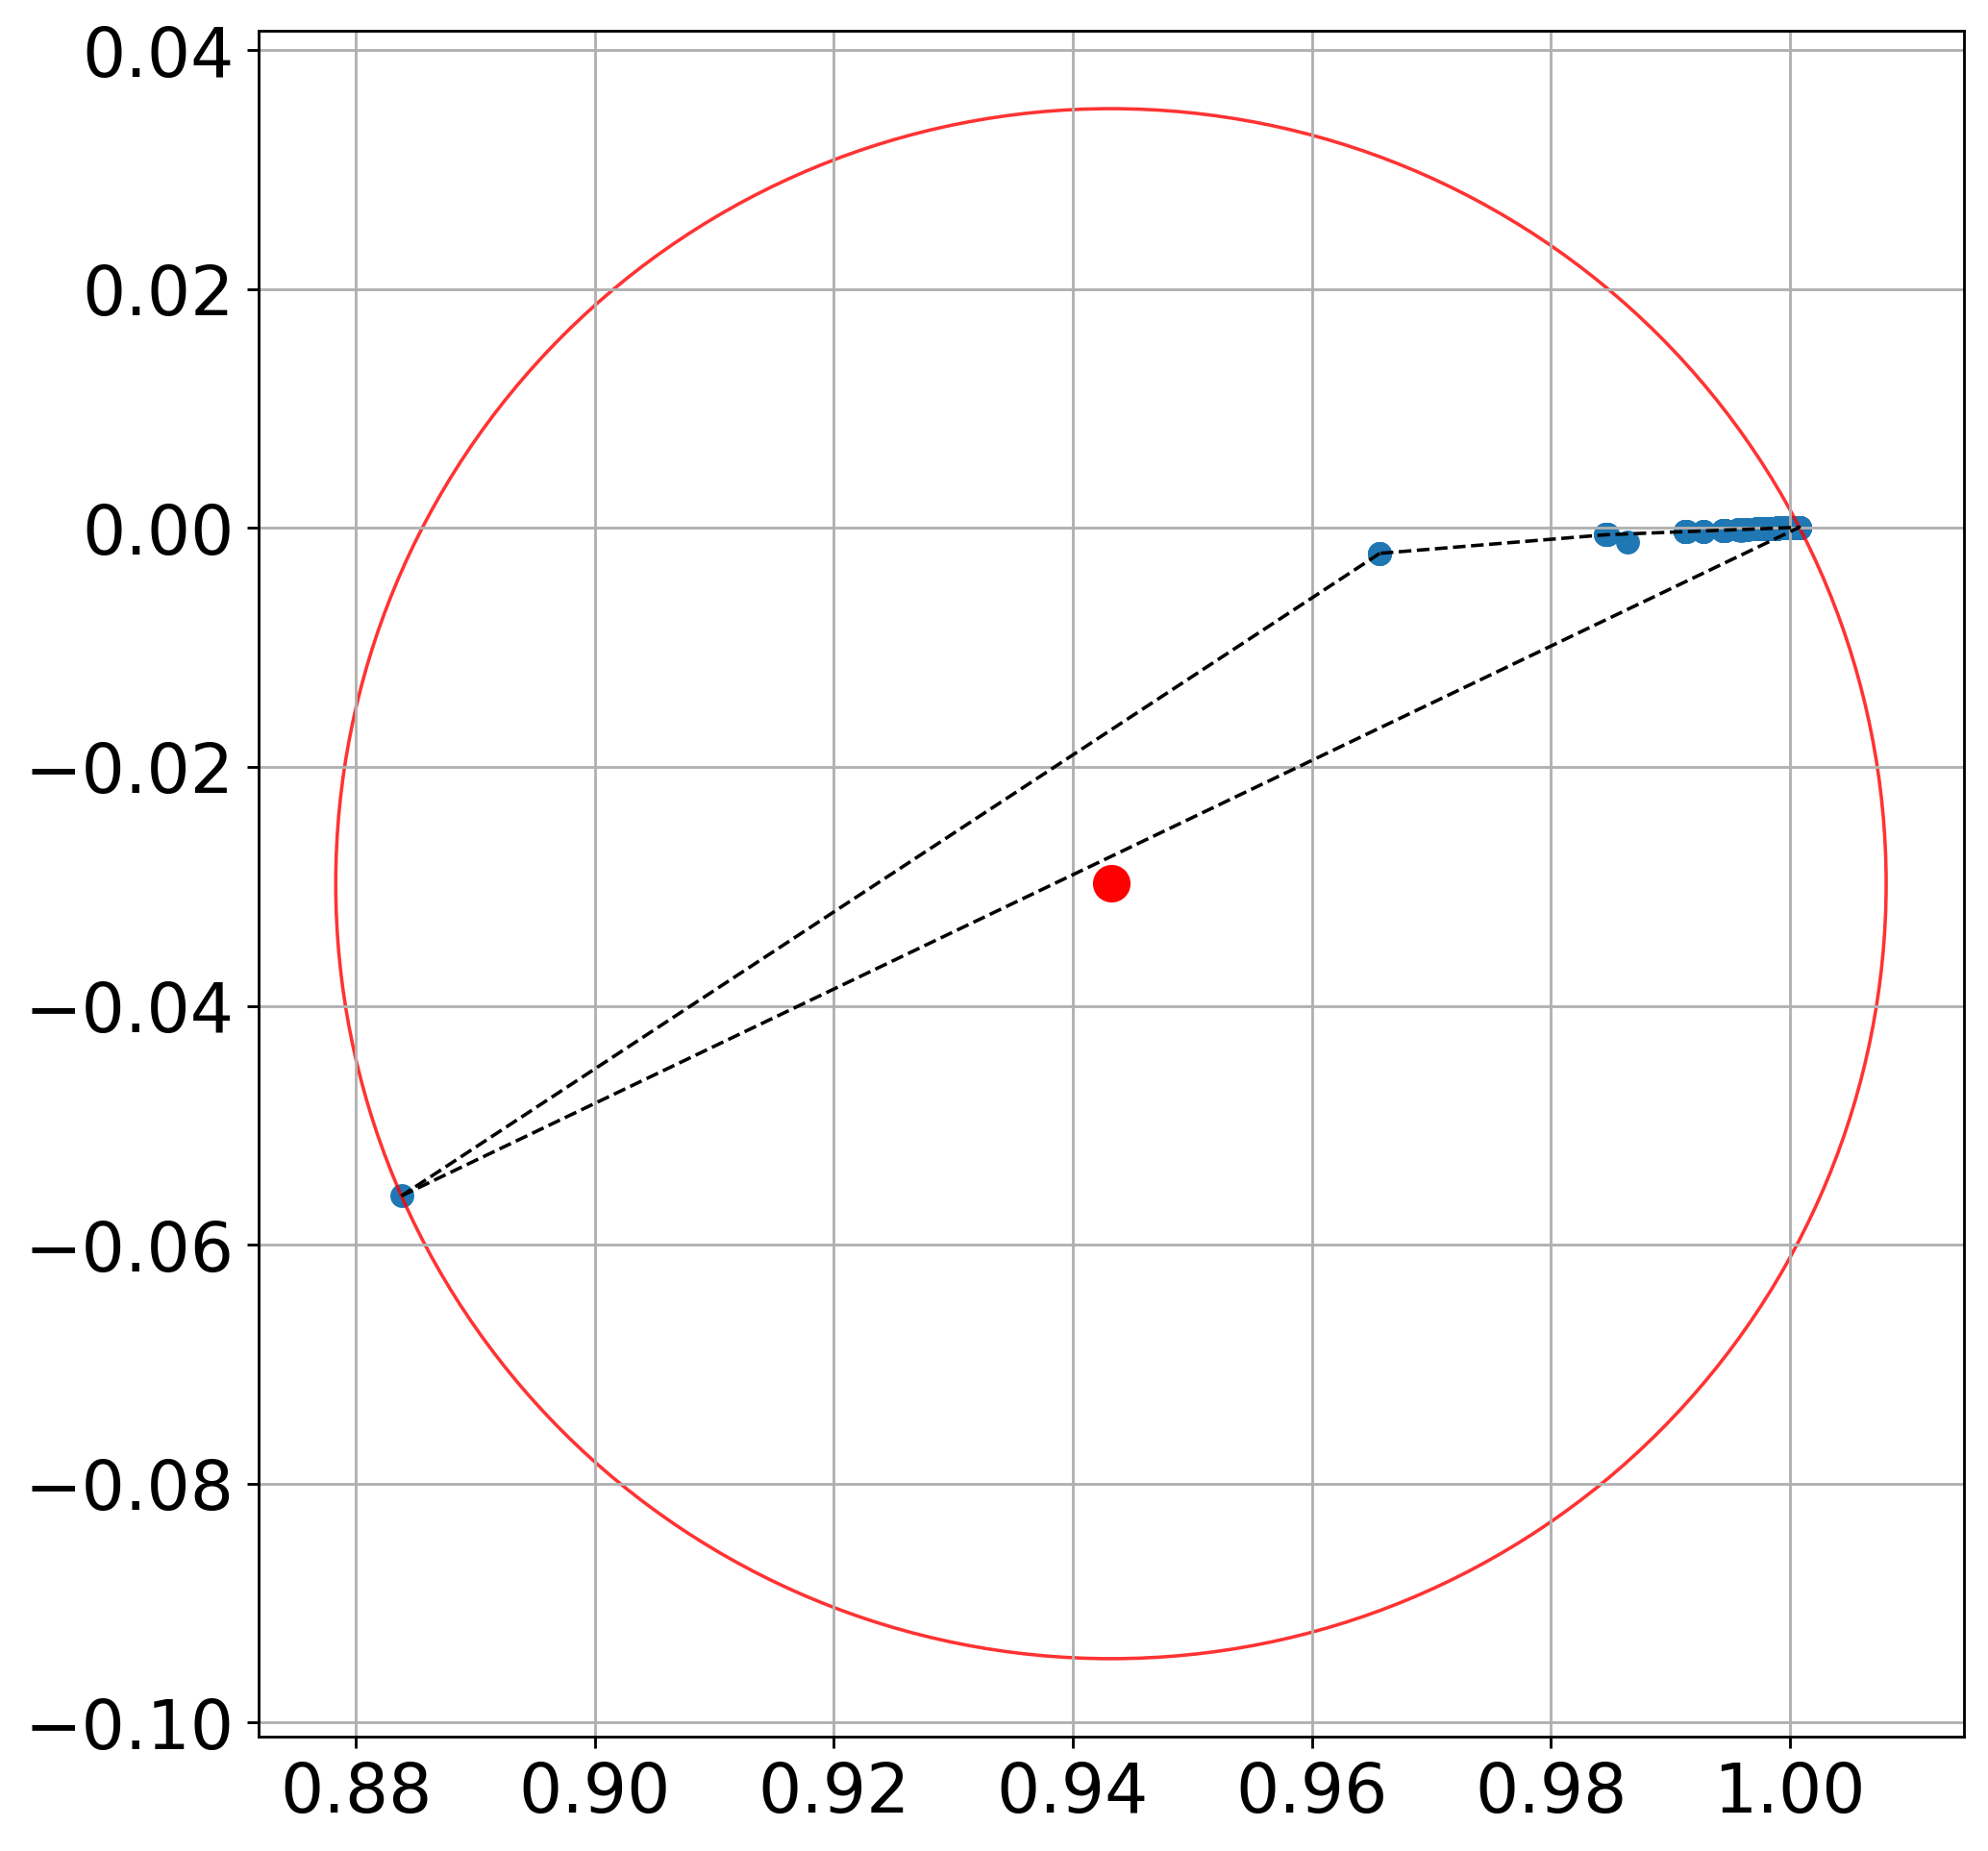


Центр окружности (0.943193591270638-0.029771953436974002j)
Радиус окружности 0.06487047026871098
Знаменатель сходимости 0.06874323370413159


In [16]:
n = problem_config.get("N_spectre")
l = problem_config.get("L")
c = problem_config.get("center")
eps_vec = problem_config.get("eps_vec")
env_value = problem_config.get("env_value_real") + 1j * problem_config.get('env_value_imag')
k = problem_config.get("k")
mu, radius, rho = get_params_from_grid(n, l, c, k, eps_vec, env_value, 
                                       path=os.path.join('grid_convergence','here2.png'))

print("\nЦентр окружности", mu)
print("Радиус окружности", radius)
print("Знаменатель сходимости", rho)

In [17]:
# Решение задачи на основной сетке
n_1 = problem_config.get('N')[0]
n_2 = problem_config.get('N')[1]
n_3 = problem_config.get('N')[2]

env_value = problem_config.get("env_value_real") + 1j * problem_config.get('env_value_imag')

to_reshape = [n_3, n_2, n_1]

k_wave = problem_config.get('k')

# Трехмерная сетка
grid, volume = make_grid(**problem_config)

# Индекс рефракции среды, определенный в точках сетки
eta, indexes = apply_refraction(grid, method='sub', env_value=env_value, **problem_config)

# Внешняя волна, определенная в точках сетки
f_wave = flat_wave_scalar(grid, **problem_config)
#f_wave = point_scalar_wave(grid, **problem_config)

# Определение массива дисркетизированного ядра оператора
dists = np.sqrt(np.sum((grid[0, 0, 0] - grid)**2, axis = 3))
dists[0, 0, 0] = 10e-8

# Заполнение первой строки матрицы 
G_array = kernel(dists, **problem_config) * volume
G_array[0, 0, 0] = 0
print(G_array.shape)

# Коэффициенты B в Фурье-образе
prep_coeffs = prep_fftbbtensor(G_array)

# Сопряженные коэффициенты в Фурье-образе
prep_conj_coeffs = prep_fftbbtensor(np.conj(G_array))

eta = cp.array(eta, dtype=complex)
indexes = cp.array(indexes, dtype=bool)
f_wave = cp.array(f_wave, dtype=complex)
G_array = cp.array(G_array, dtype=complex)
prep_coeffs = cp.array(prep_coeffs)
prep_conj_coeffs = cp.array(prep_conj_coeffs)
# Умножение внешней волны на ядро оператора
#u0_array = -1.0 * prep_fbbtmv(prep_coeffs, f_wave)
u0_array = f_wave

(100, 100, 100)


In [18]:
# Решение задачи с помощью двухшагового метода градиентного спуска
if rho > 0 and rho < 1:
    start_time = timeit.default_timer()
    
    result_SIM, iters_SIM, eps_SIM, resid_SIM = \
    SIM((k_wave**2) * prep_coeffs,   
        f=u0_array,  
        eta=eta,
        operator=operator, 
        mu=mu, 
        u0=None, 
        rtol=1e-8, 
        max_iter=1000, 
        log=False)
    elapsed = timeit.default_timer() - start_time
    print(elapsed)
    
    resid_SIM = [x.get() for x in resid_SIM]
    eps_SIM = [x.get() for x in eps_SIM]
    result_SIM = result_SIM.get()

else:
    print("Метод вырождается")
    resid_SIM = [1.0]
    eps_SIM = [1.0]
    iters_SIM = [0.0]
    result_SIM = u0_array

0.9954279400000132


In [19]:
# Решение задачи с помощью двухшагового метода градиентного спуска
start_time = timeit.default_timer()
result_TS, iters_TS, eps_TS, resid_TS = \
TwoStep(coeffs=(k_wave**2) * prep_coeffs, 
        conj_coeffs=(k_wave**2) *prep_conj_coeffs, 
        f=u0_array, 
        eta=eta,
        operator=operator,
        conj_operator=conj_operator,
        u0=None, 
        rtol=1e-8, 
        max_iter=1000, 
        log=False)
elapsed = timeit.default_timer() - start_time
print(elapsed)

resid_TS = [x.get() for x in resid_TS]
eps_TS = [x.get() for x in eps_TS]
result_TS = result_TS.get()

0.6233023629999934


In [20]:
# Решение задачи с помощью стабилизированного метода бисопряженных градиентов
start_time = timeit.default_timer()
result_BICGStab, iters_BICGStab, eps_BICGStab, resid_BICGStab = \
bicgstab(coeffs=(k_wave**2) * prep_coeffs, 
         f=u0_array, 
         eta=eta,
         operator=operator,
         u0=None, 
         rtol=1e-8, 
         max_iter=1000, 
         log=False)
elapsed = timeit.default_timer() - start_time
print(elapsed)


resid_BICGStab = [x.get() for x in resid_BICGStab]
eps_BICGStab = [x.get() for x in eps_BICGStab]
result_BICGStab = result_BICGStab.get()

достичь нужной точности смогли быстрее
0.7636818969999695


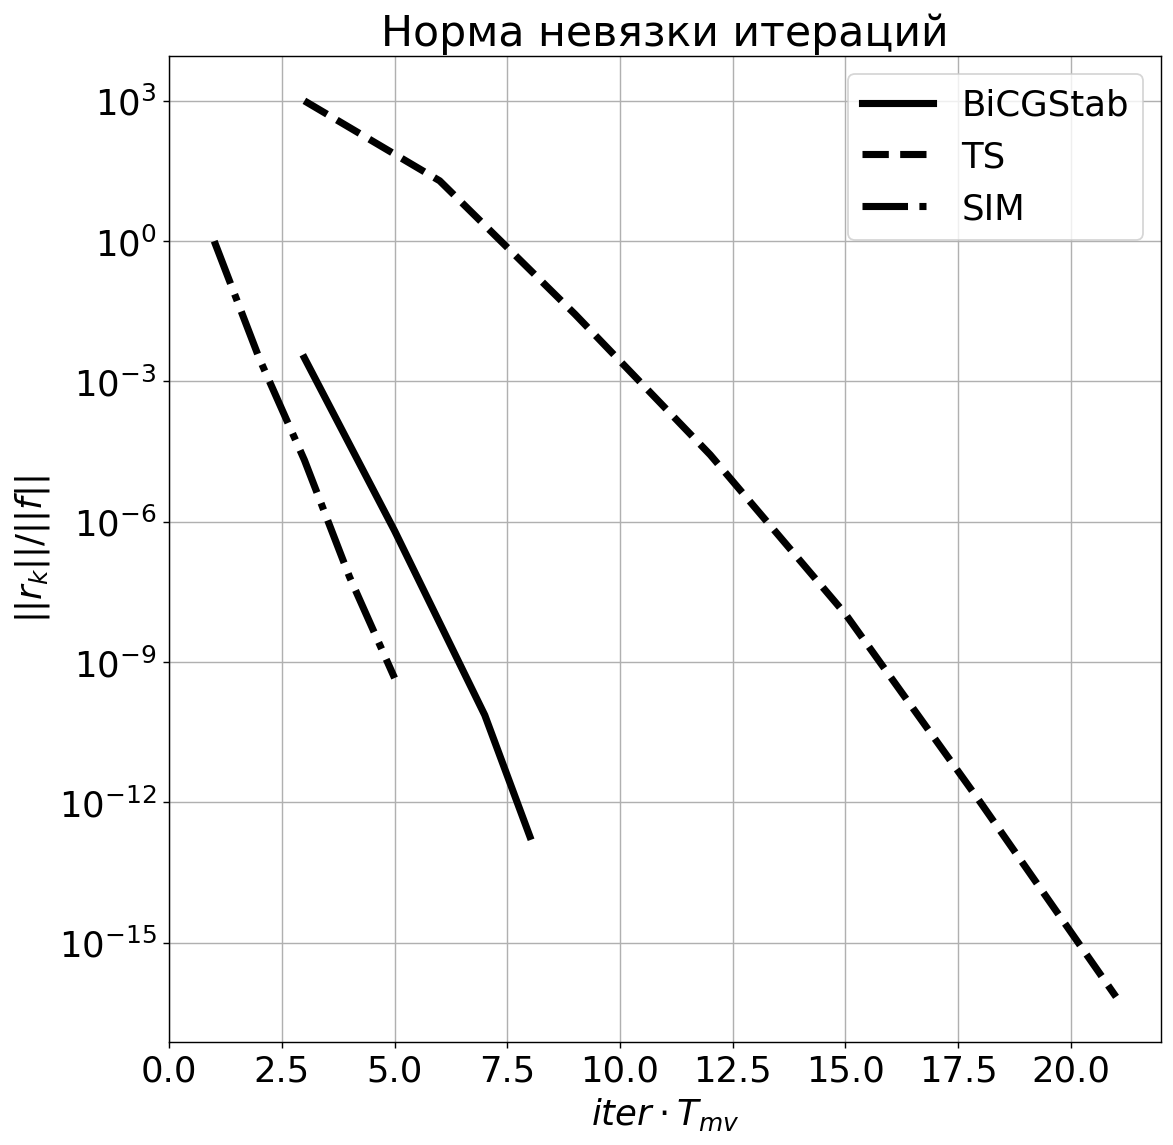

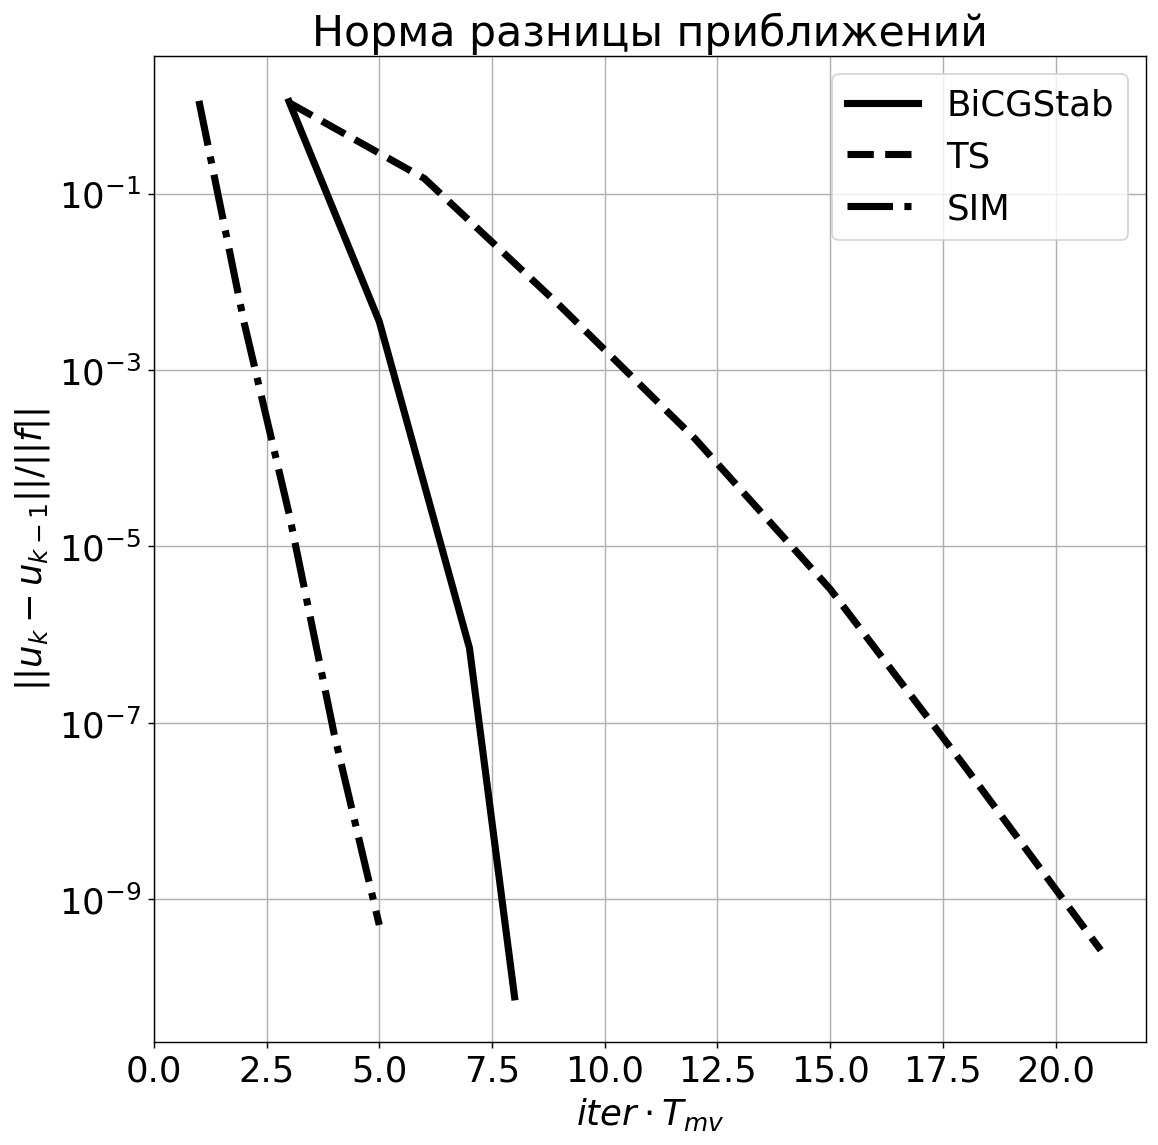

In [21]:
# Визуализация нормы невязки итераций
ylabel = r"$||r_k||/||f||$"
xlabel = r"$iter\cdot T_{mv}$"
title = "Норма невязки итераций"
yscale = 'log'
lw = 4
def plot_comparison(list_iters, list_metrics, list_of_names, 
                    list_of_linestyles=None, 
                    list_of_colors=None,
                    xlabel=None, ylabel=None, 
                    title=None, yscale=None, path=None, lw=None):
    if lw is None:
        lw = 4
    if list_of_linestyles is None:
        list_of_linestyles = ["-", "--", "-."]
    if list_of_colors is None:
        list_of_colors = ["black"]
        
    matplotlib.rcParams.update({'font.size': 20})
    
    plt.figure(figsize=(10, 10), dpi=128)
    
    for num, iters in enumerate(list_iters):
        plt.plot(list_iters[num], list_metrics[num], label=list_of_names[num], 
                 linestyle=list_of_linestyles[num%len(list_of_linestyles)], 
                 linewidth=lw, color=list_of_colors[num%len(list_of_colors)])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.yscale('log')
    plt.title(title)
    plt.legend()
    plt.grid()
    if path:
        plt.savefig(path, bbox_inches="tight")
    plt.show()
    matplotlib.rcParams.update({'font.size': 12})

plot_comparison([iters_SIM, iters_TS, iters_BICGStab[1:]][::-1],
                [resid_SIM, resid_TS, resid_BICGStab[1:]][::-1],
                ["SIM", "TS", "BiCGStab"][::-1],
                None, None,
                xlabel, ylabel, title, yscale)
plot_comparison([iters_SIM, iters_TS, iters_BICGStab[1:]][::-1],
                [eps_SIM, eps_TS, eps_BICGStab[1:]][::-1],
                ["SIM", "TS", "BiCGStab"][::-1],
                None, None,
                xlabel, r"$||u_k - u_{k-1}||/||f||$", "Норма разницы приближений", yscale)

In [22]:
def plot_scalar_xy(scalar_field, boundaries=None, slice=None, title=None, path=None, **kwargs):
    # Номер среза по оси z посередине области
    if boundaries is None:
        boundaries = [-1, 1, -1, 1]
    if slice is None:
        slice = scalar_field.shape[0] // 2
    if title is None:
        title = r"Скалярное поле в плоскости $x_1Ox_2$ на срезе $p_3$=" + str(slice)

    if slice >= scalar_field.shape[0]:
        slice = scalar_field.shape[0] - 1

    if kwargs.get('fontsize'):
        matplotlib.rcParams.update({'font.size': kwargs.get('fontsize')})
    else:
        matplotlib.rcParams.update({'font.size': 20})

    plt.figure(**kwargs)
    plt.imshow(scalar_field[slice, ...], origin='lower', extent=boundaries, cmap="gray")
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$")
    plt.title(title)
    plt.colorbar()
    if path:
        plt.savefig(path, bbox_inches="tight")
    plt.show()

    matplotlib.rcParams.update({'font.size': 12})


def plot_scalar_xz(scalar_field, boundaries=None, slice=None, title=None, path=None, **kwargs):
    # Номер среза по оси z посередине области
    if boundaries is None:
        boundaries = [-1, 1, -1, 1]
    if slice is None:
        slice = scalar_field.shape[0] // 2
    if title is None:
        title = r"Скалярное поле в плоскости $x_1Ox_3$ на срезе $p_2$=" + str(slice)

    if slice >= scalar_field.shape[0]:
        slice = scalar_field.shape[0] - 1

    if kwargs.get('fontsize'):
        matplotlib.rcParams.update({'font.size': kwargs.get('fontsize')})
    else:
        matplotlib.rcParams.update({'font.size': 20})

    plt.figure(**kwargs)
    plt.imshow(scalar_field[:, slice, :], origin='lower', extent=boundaries, cmap="gray")
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_3$")
    plt.title(title)
    plt.colorbar()
    if path:
        plt.savefig(path, bbox_inches="tight")
    plt.show()

    matplotlib.rcParams.update({'font.size': 12})


def plot_scalar_yz(scalar_field, boundaries=None, slice=None, title=None, path=None, **kwargs):
    # Номер среза по оси z посередине области
    if boundaries is None:
        boundaries = [-1, 1, -1, 1]
    if slice is None:
        slice = scalar_field.shape[0] // 2
    if title is None:
        title = r"Скалярное поле в плоскости $x_2Ox_3$ на срезе $p_1$=" + str(slice)

    if slice >= scalar_field.shape[0]:
        slice = scalar_field.shape[0] - 1

    if kwargs.get('fontsize'):
        matplotlib.rcParams.update({'font.size': kwargs.get('fontsize')})
    else:
        matplotlib.rcParams.update({'font.size': 20})

    plt.figure(**kwargs)
    plt.imshow(scalar_field[:, :, slice], origin='lower', extent=boundaries, cmap="gray")
    plt.xlabel(r"$x_2$")
    plt.ylabel(r"$x_3$")
    plt.title(title)
    plt.colorbar()
    if path:
        plt.savefig(path, bbox_inches="tight")
    plt.show()

    matplotlib.rcParams.update({'font.size': 12})

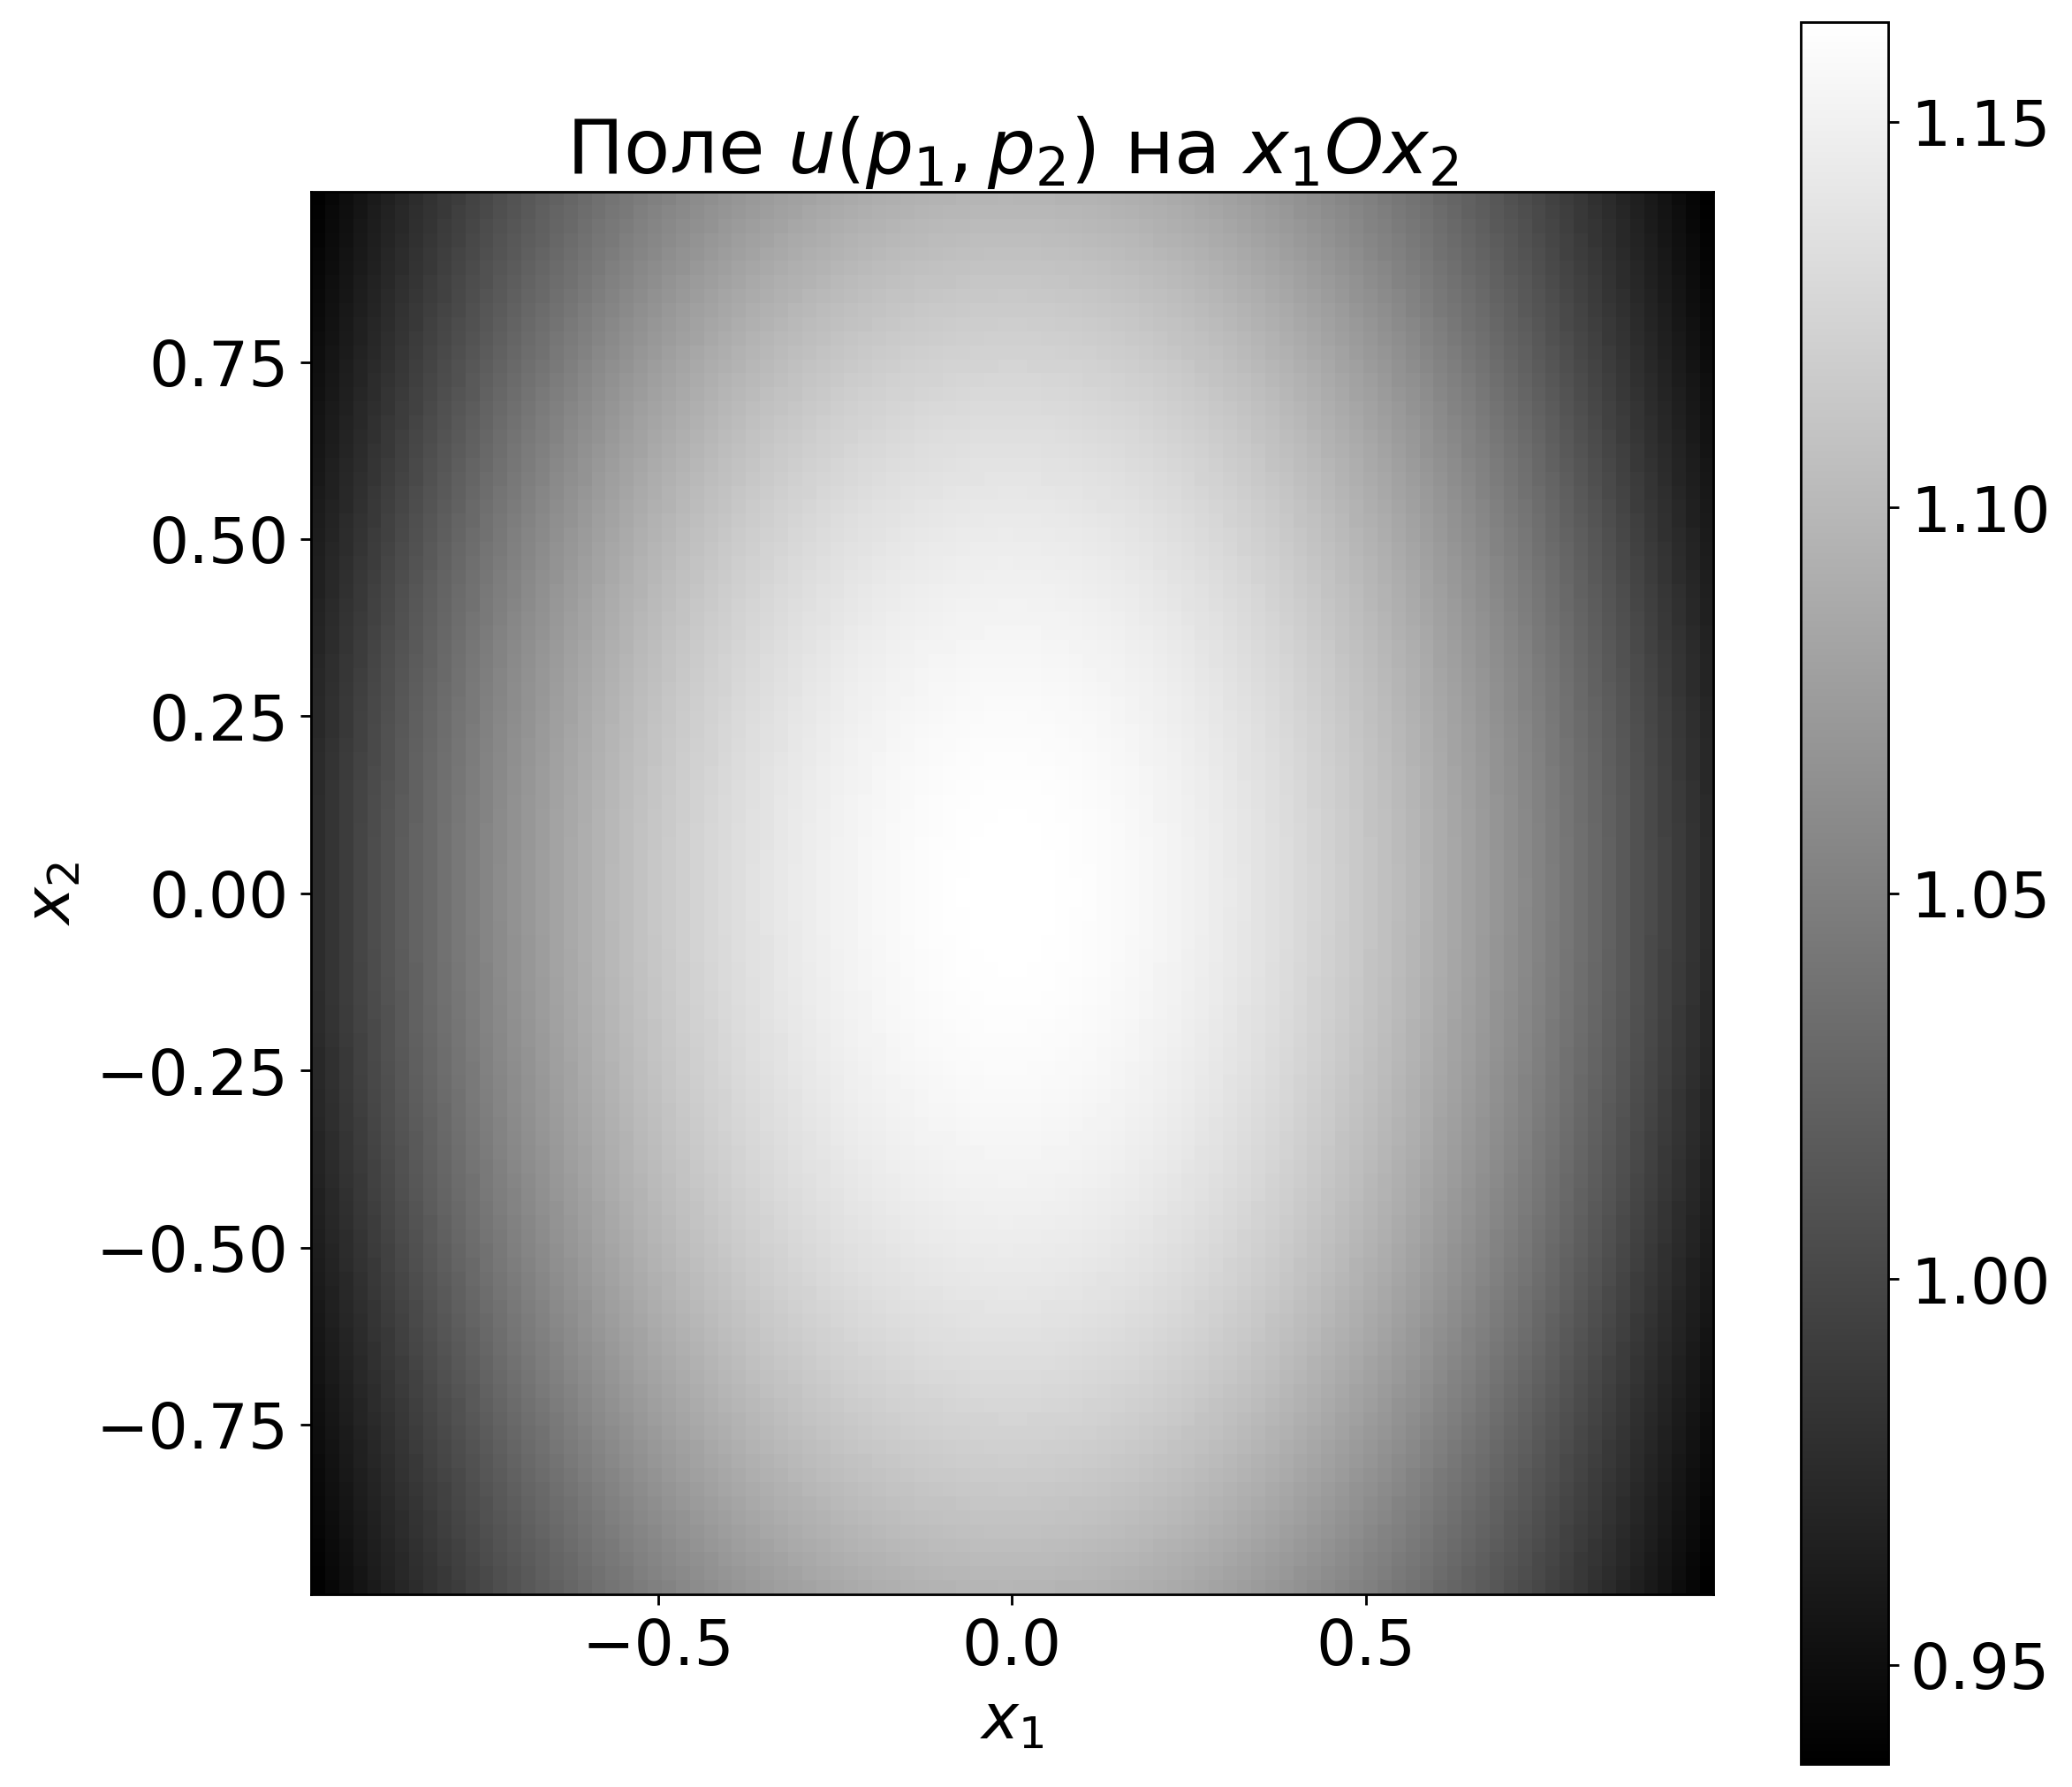

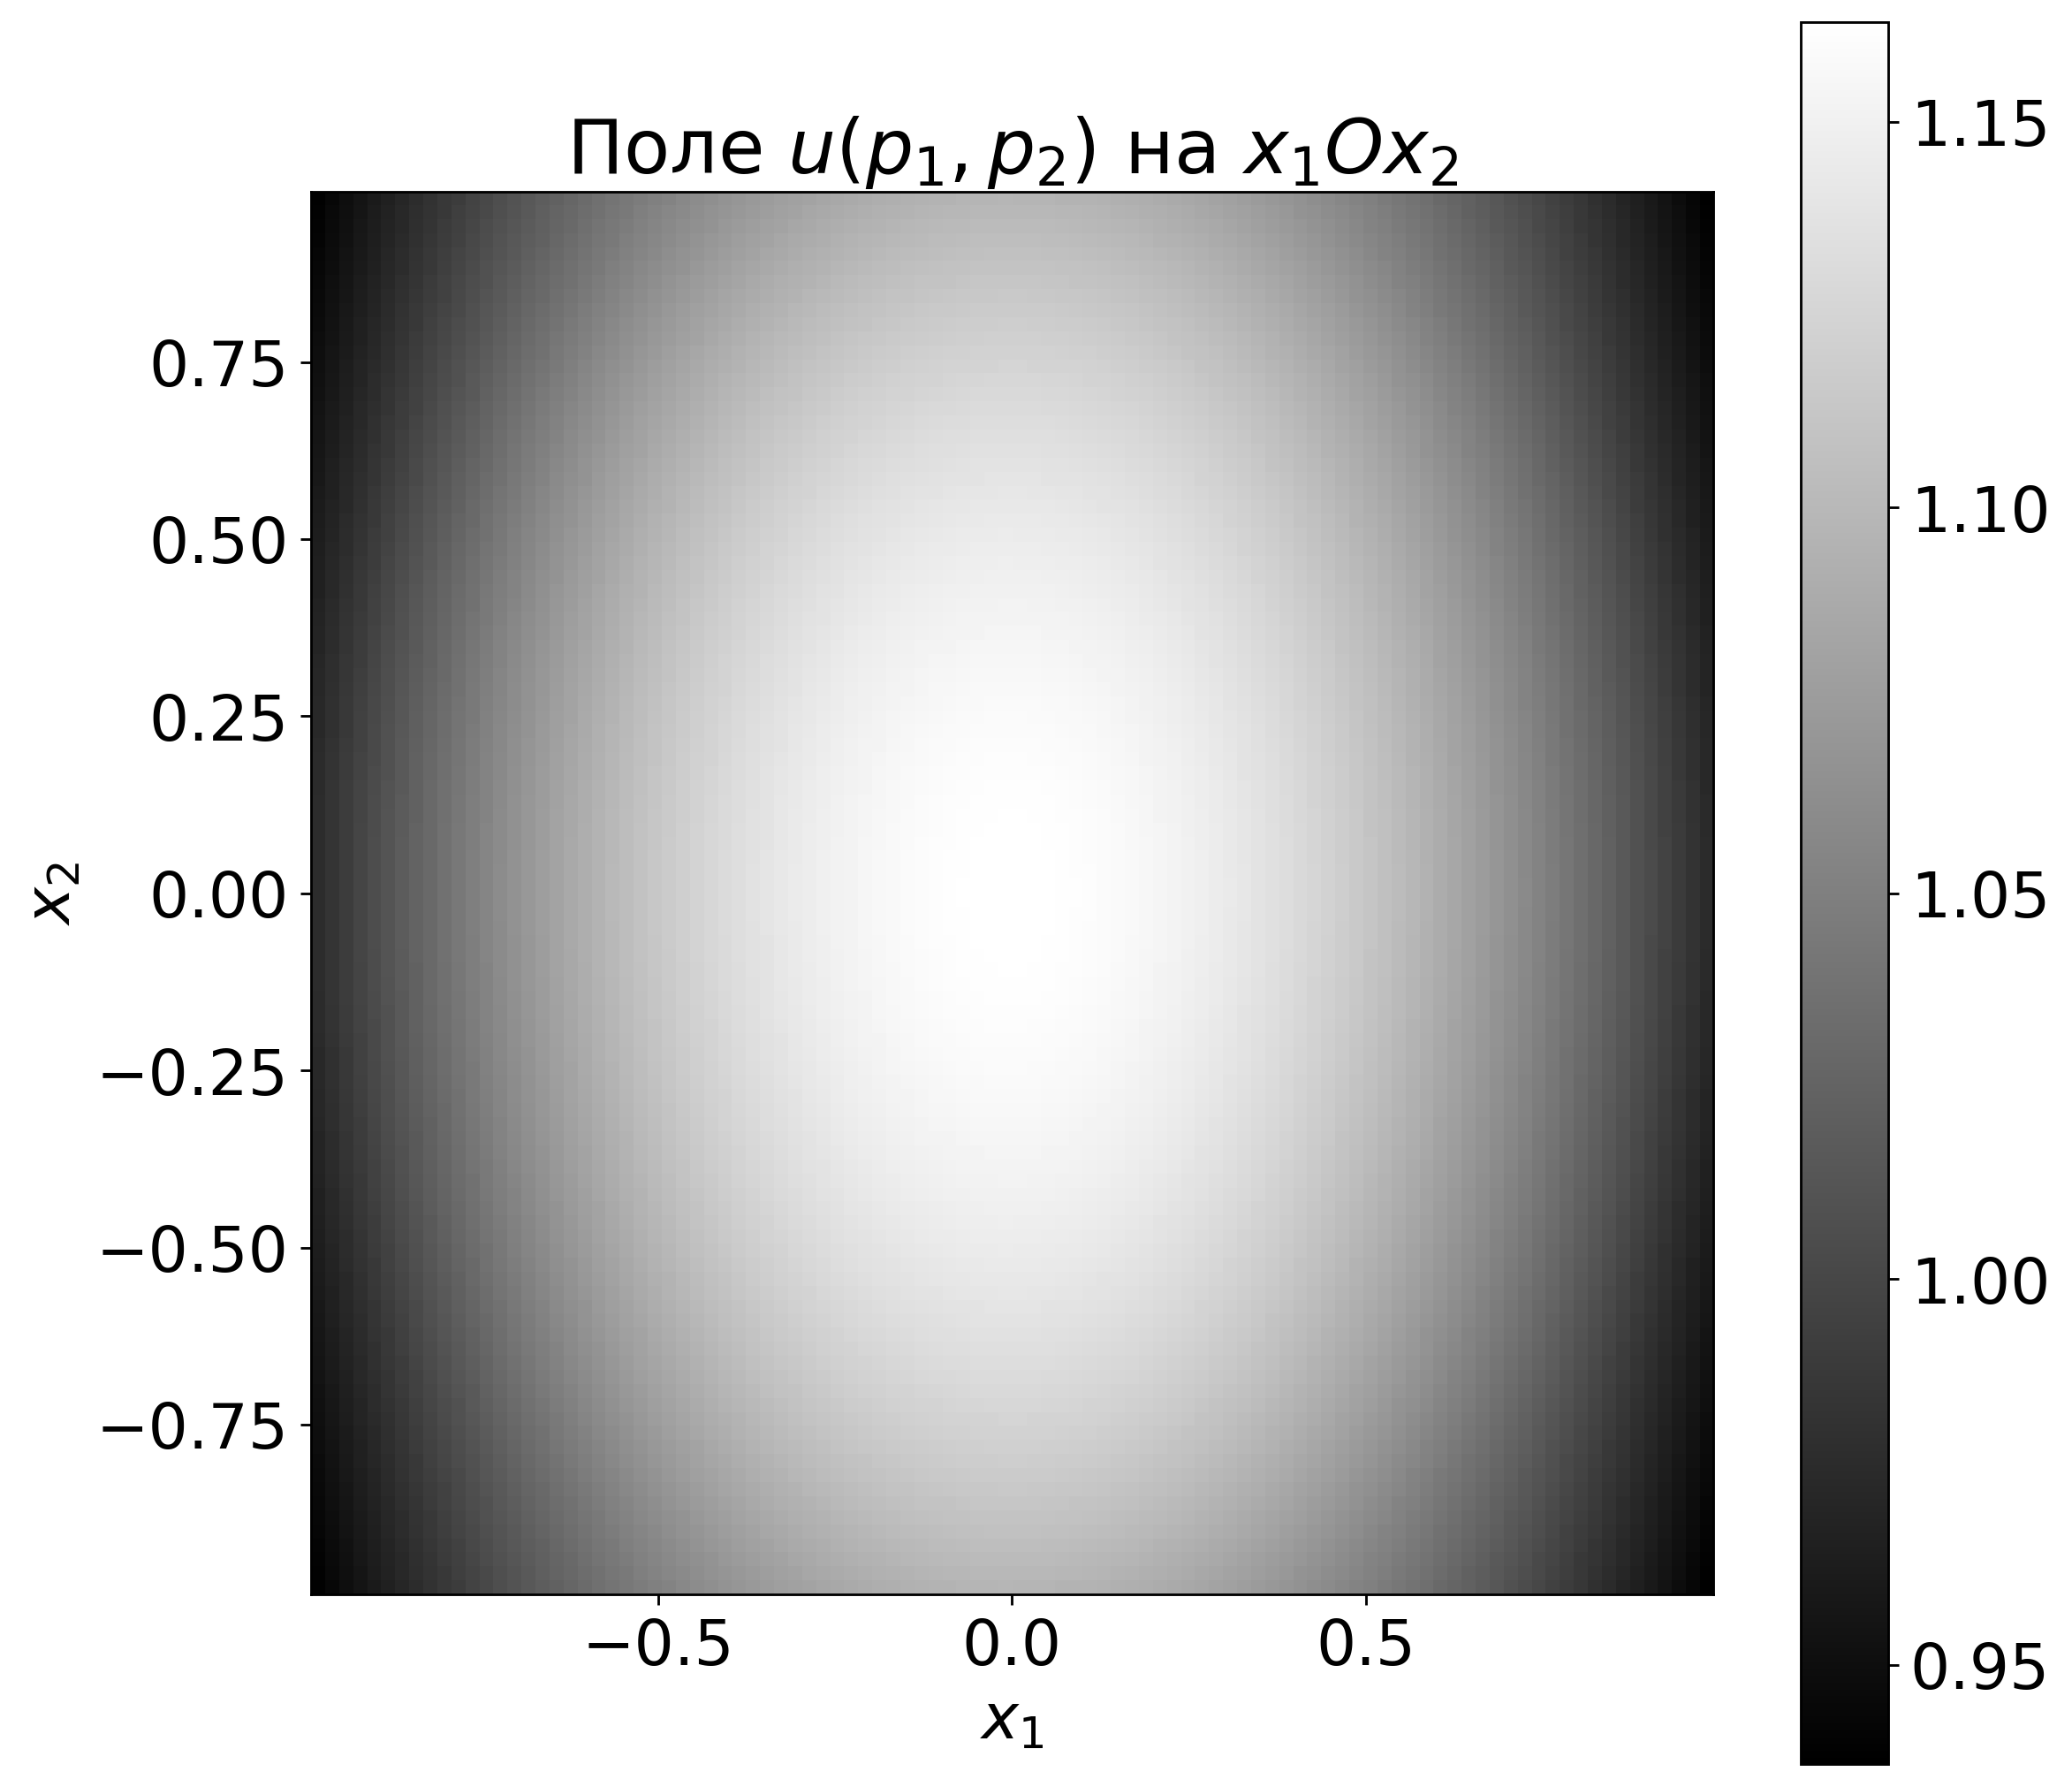

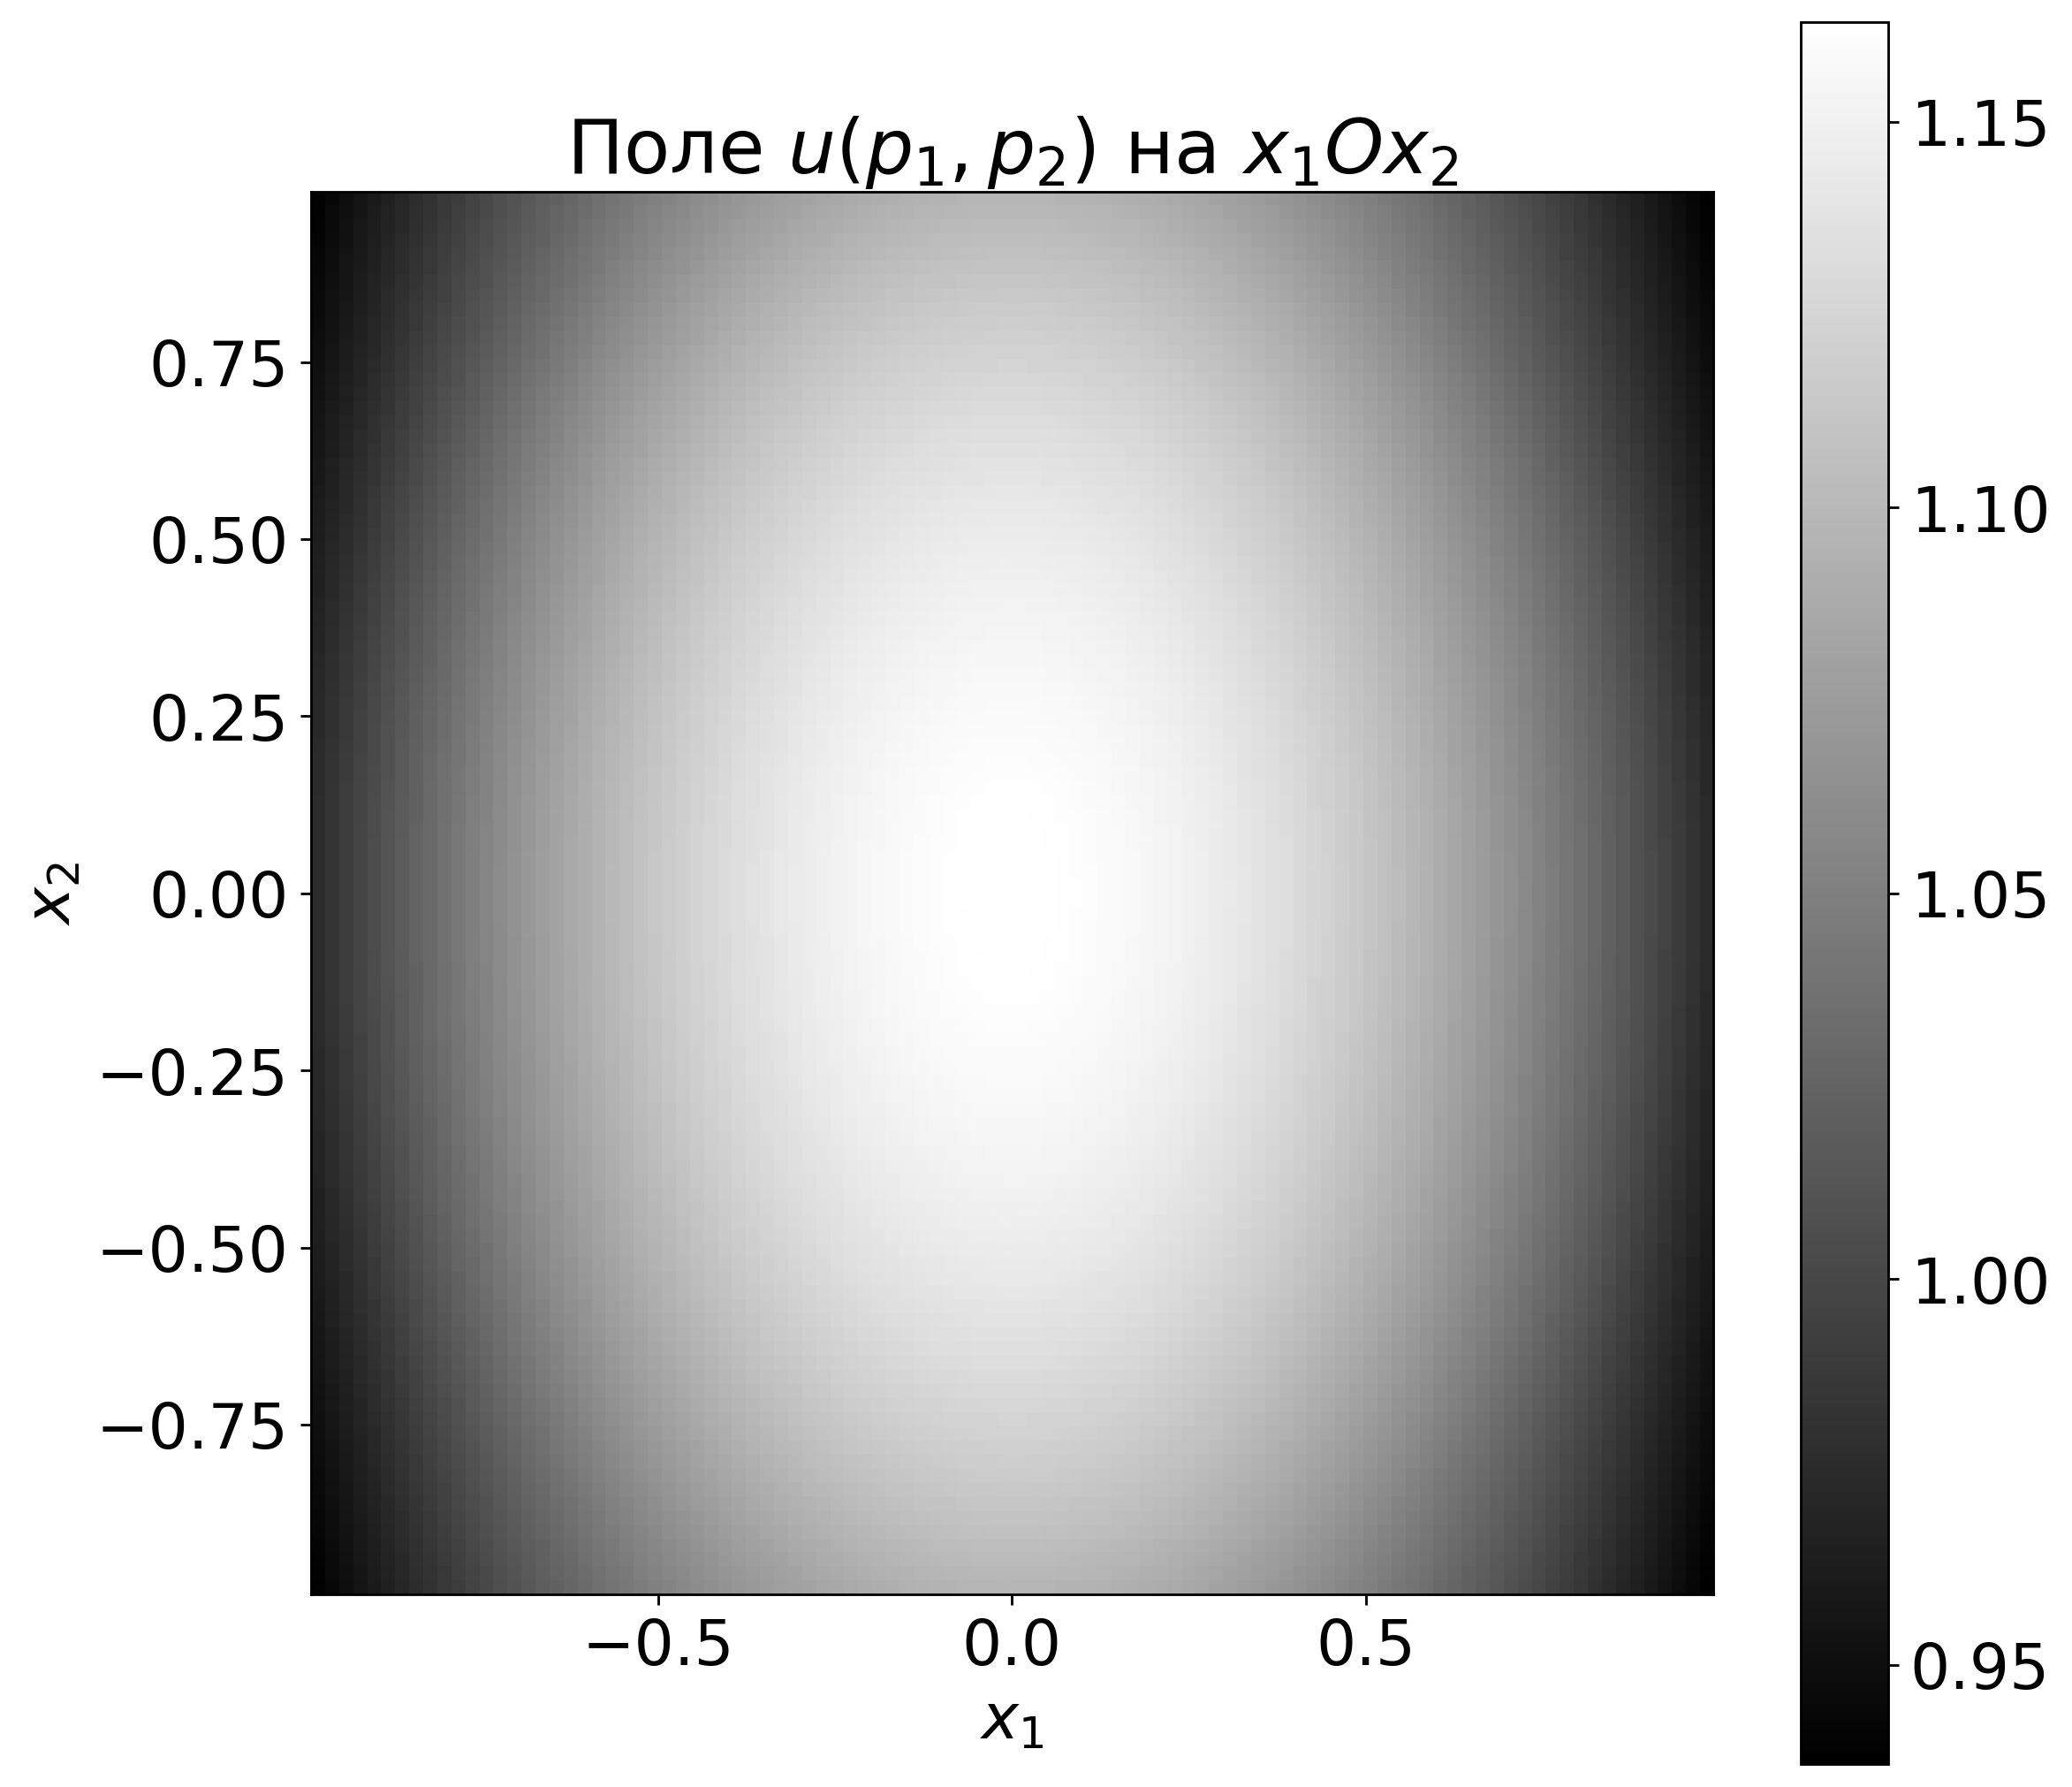

In [23]:
title = r"Поле $u(p_1, p_2)$ на $x_1Ox_2$"
boundaries = [np.min(grid[:,:,:, 0]), 
              np.max(grid[:,:,:, 0]), 
              np.min(grid[:,:,:, 1]), 
              np.max(grid[:,:,:, 1])]
dpi=256
figsize=(10,10)
plot_scalar_xy(result_TS.real, title=title, boundaries=boundaries, dpi=dpi, figsize=figsize)
plot_scalar_xy(result_BICGStab.real, title=title, boundaries=boundaries, dpi=dpi, figsize=figsize)
plot_scalar_xy(result_SIM.real, title=title, boundaries=boundaries, dpi=dpi, figsize=figsize)

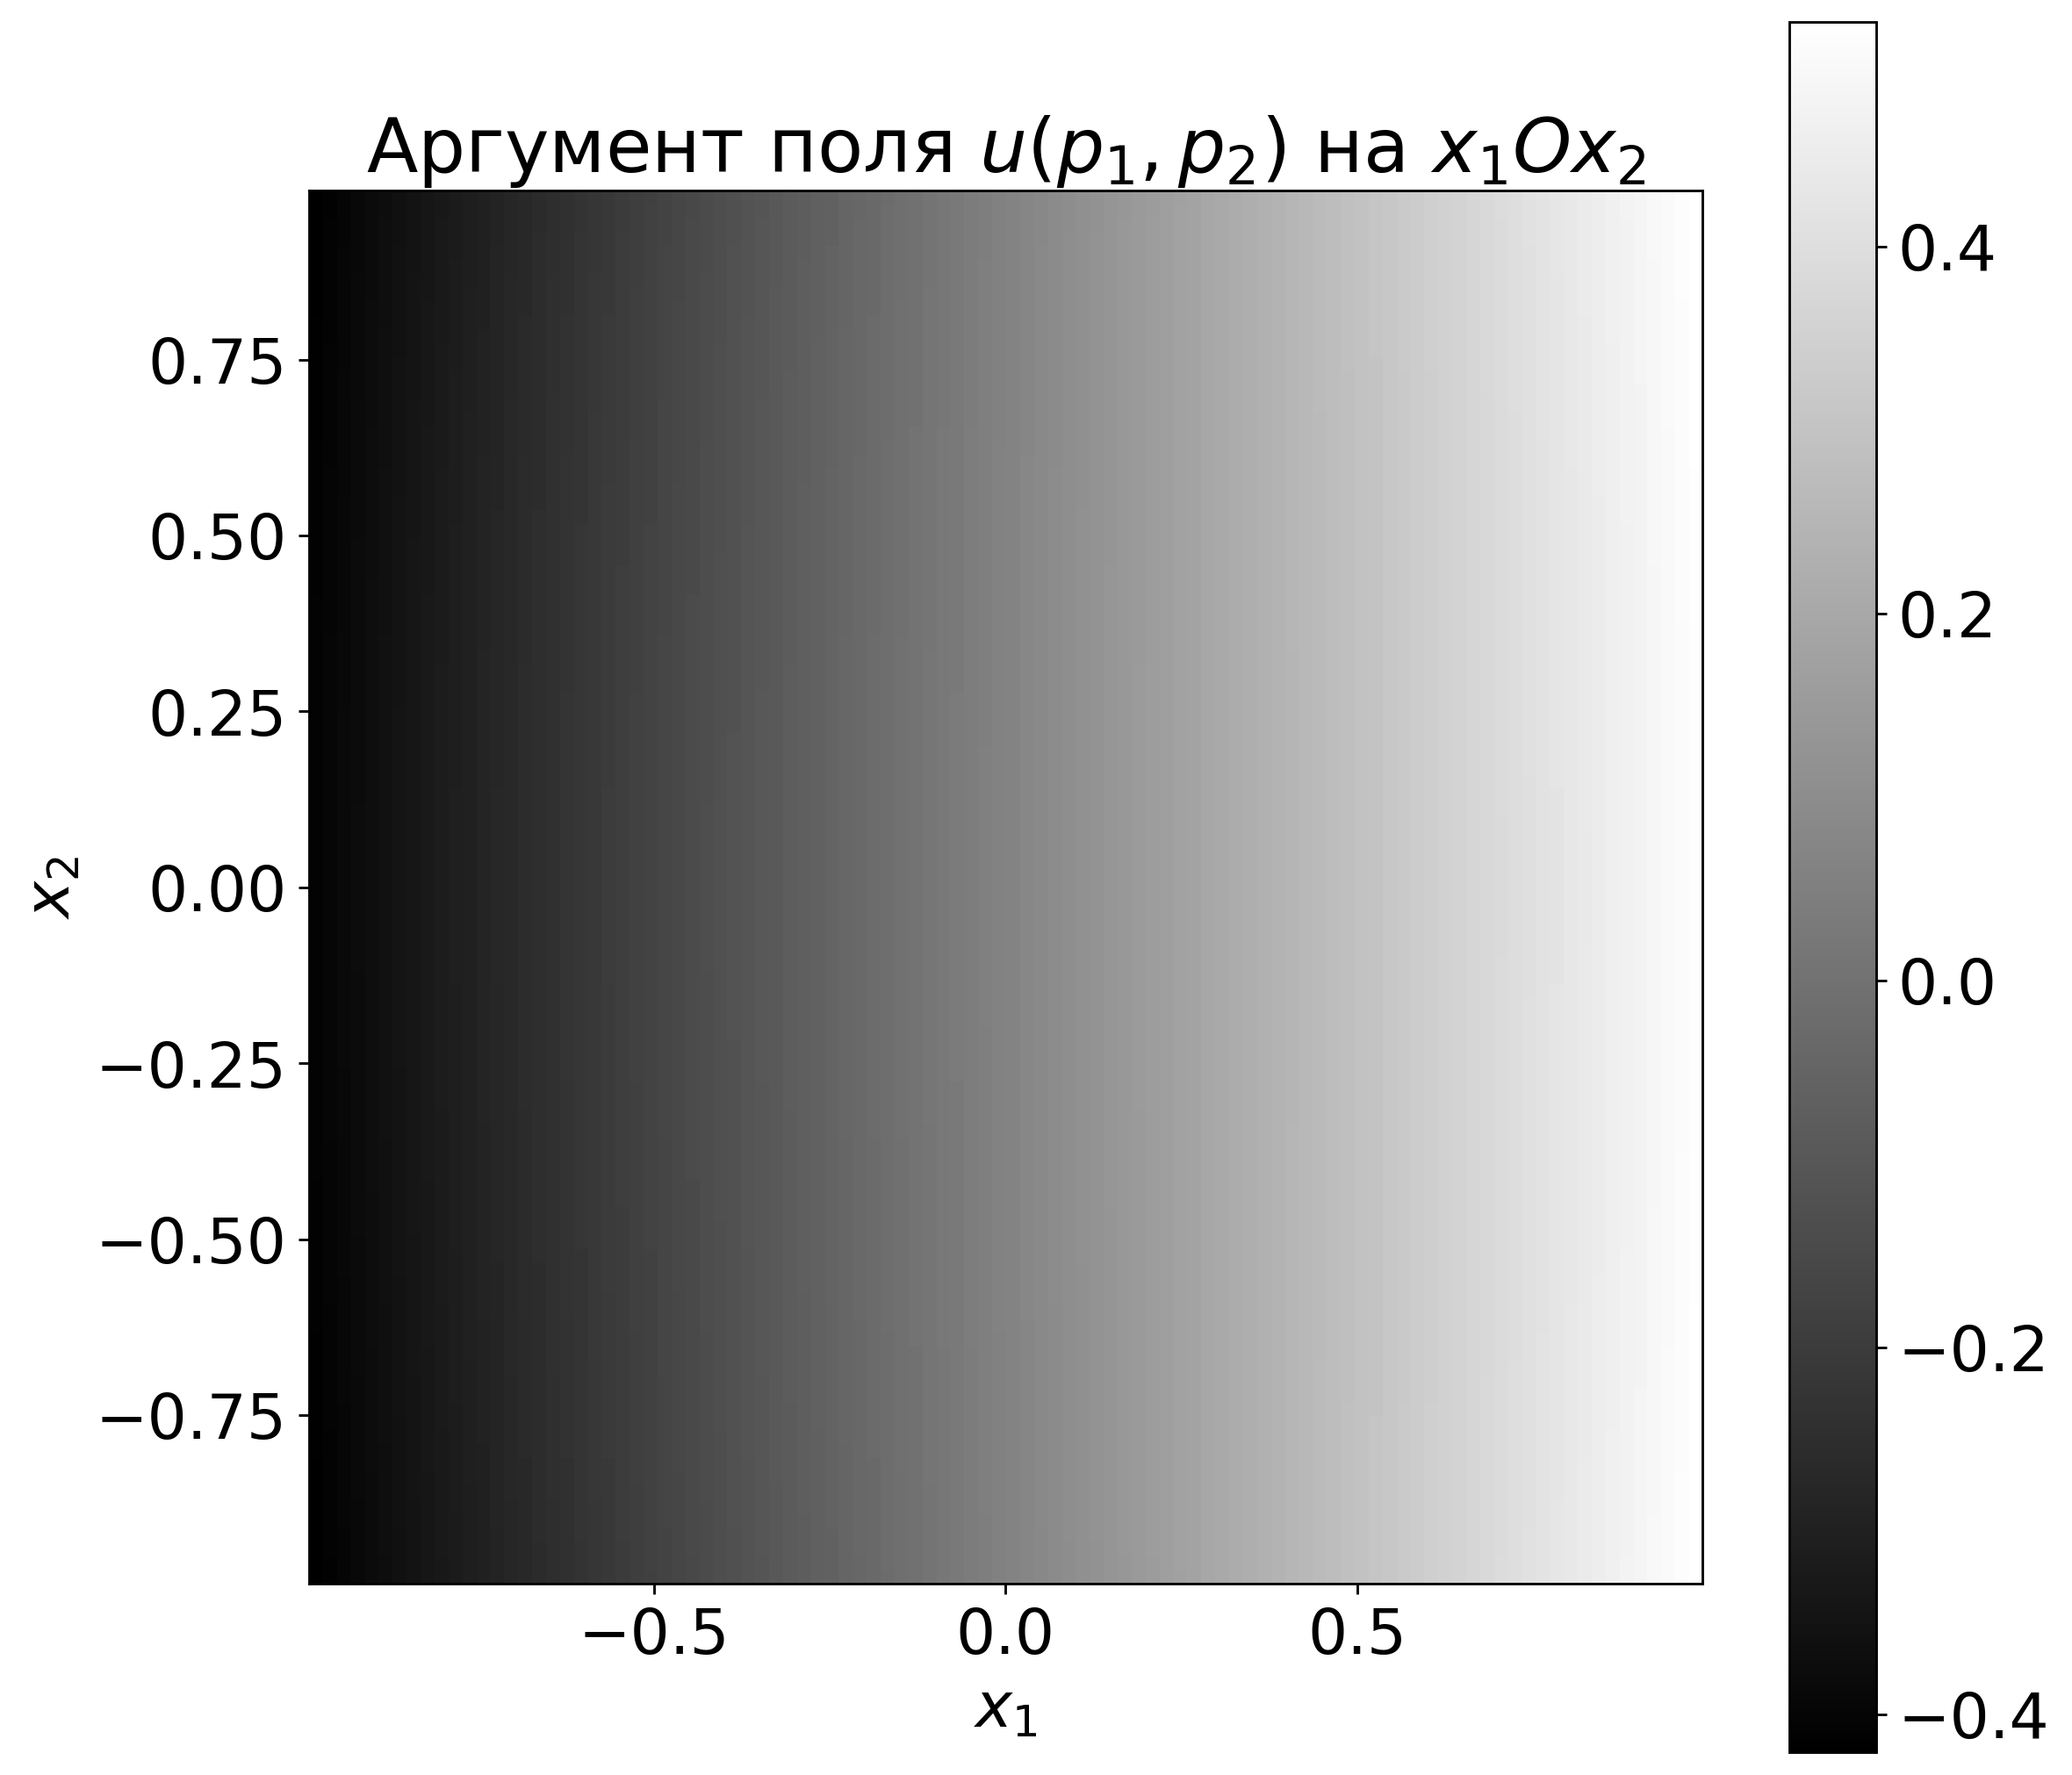

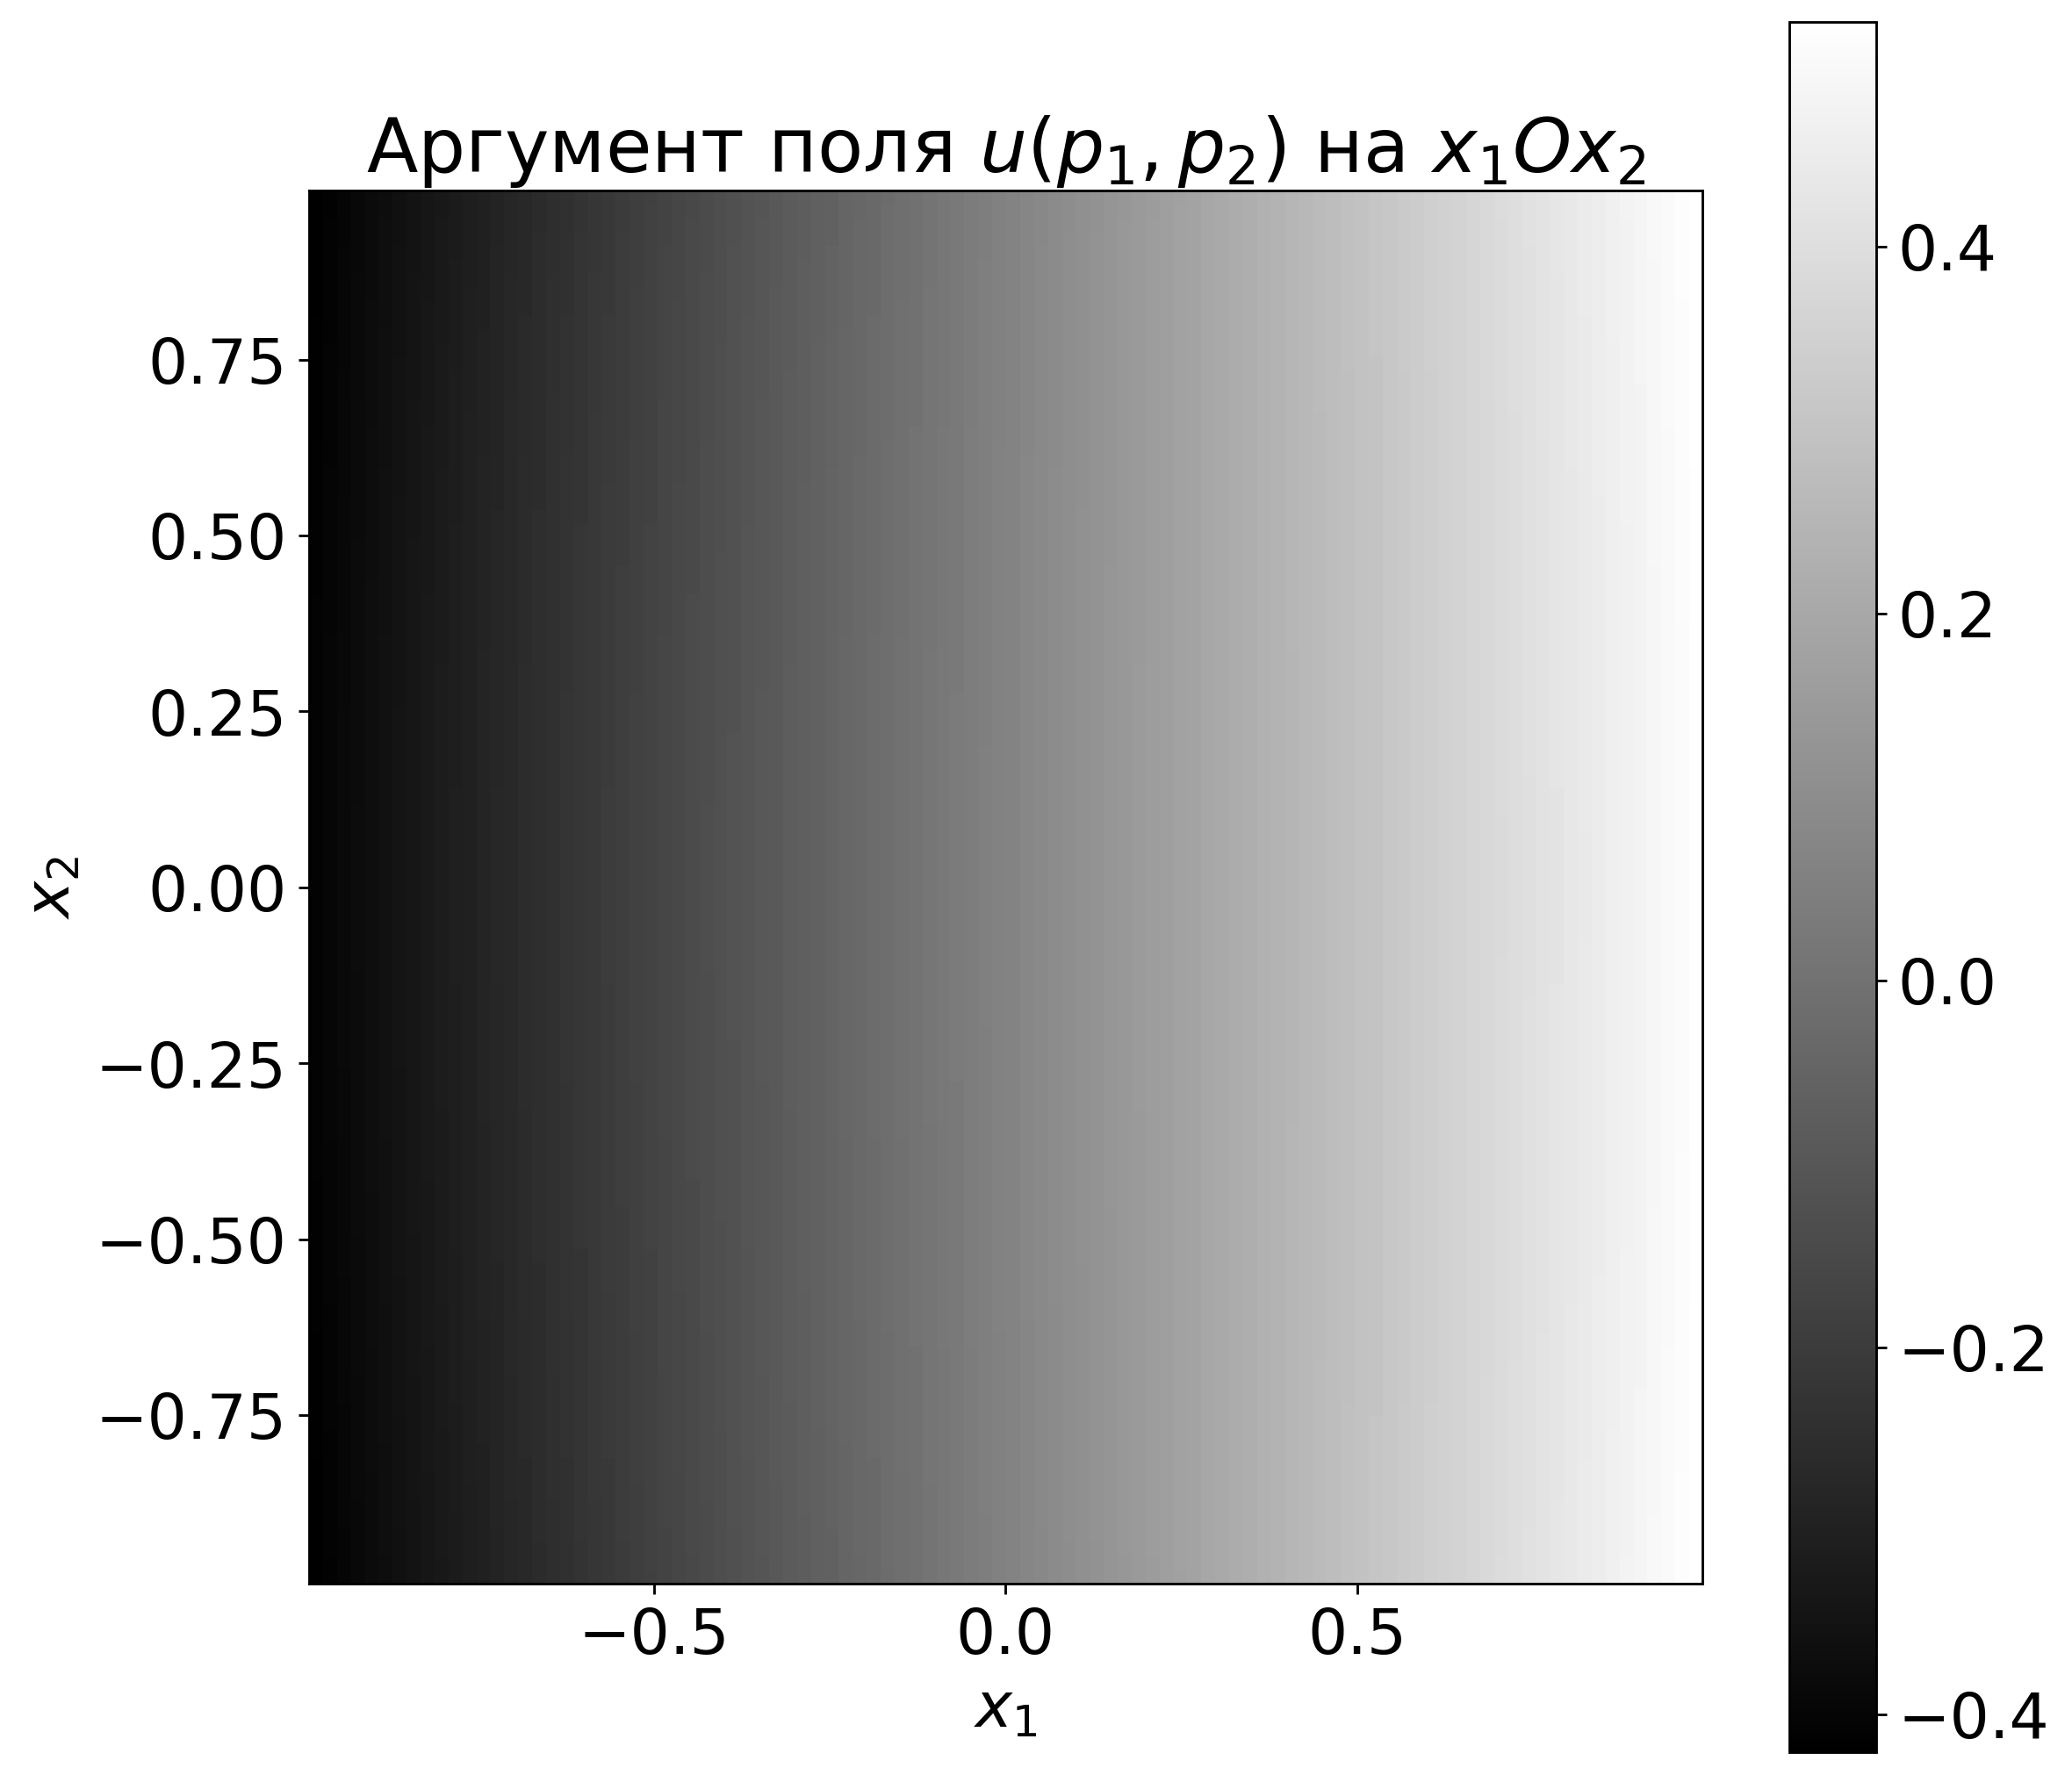

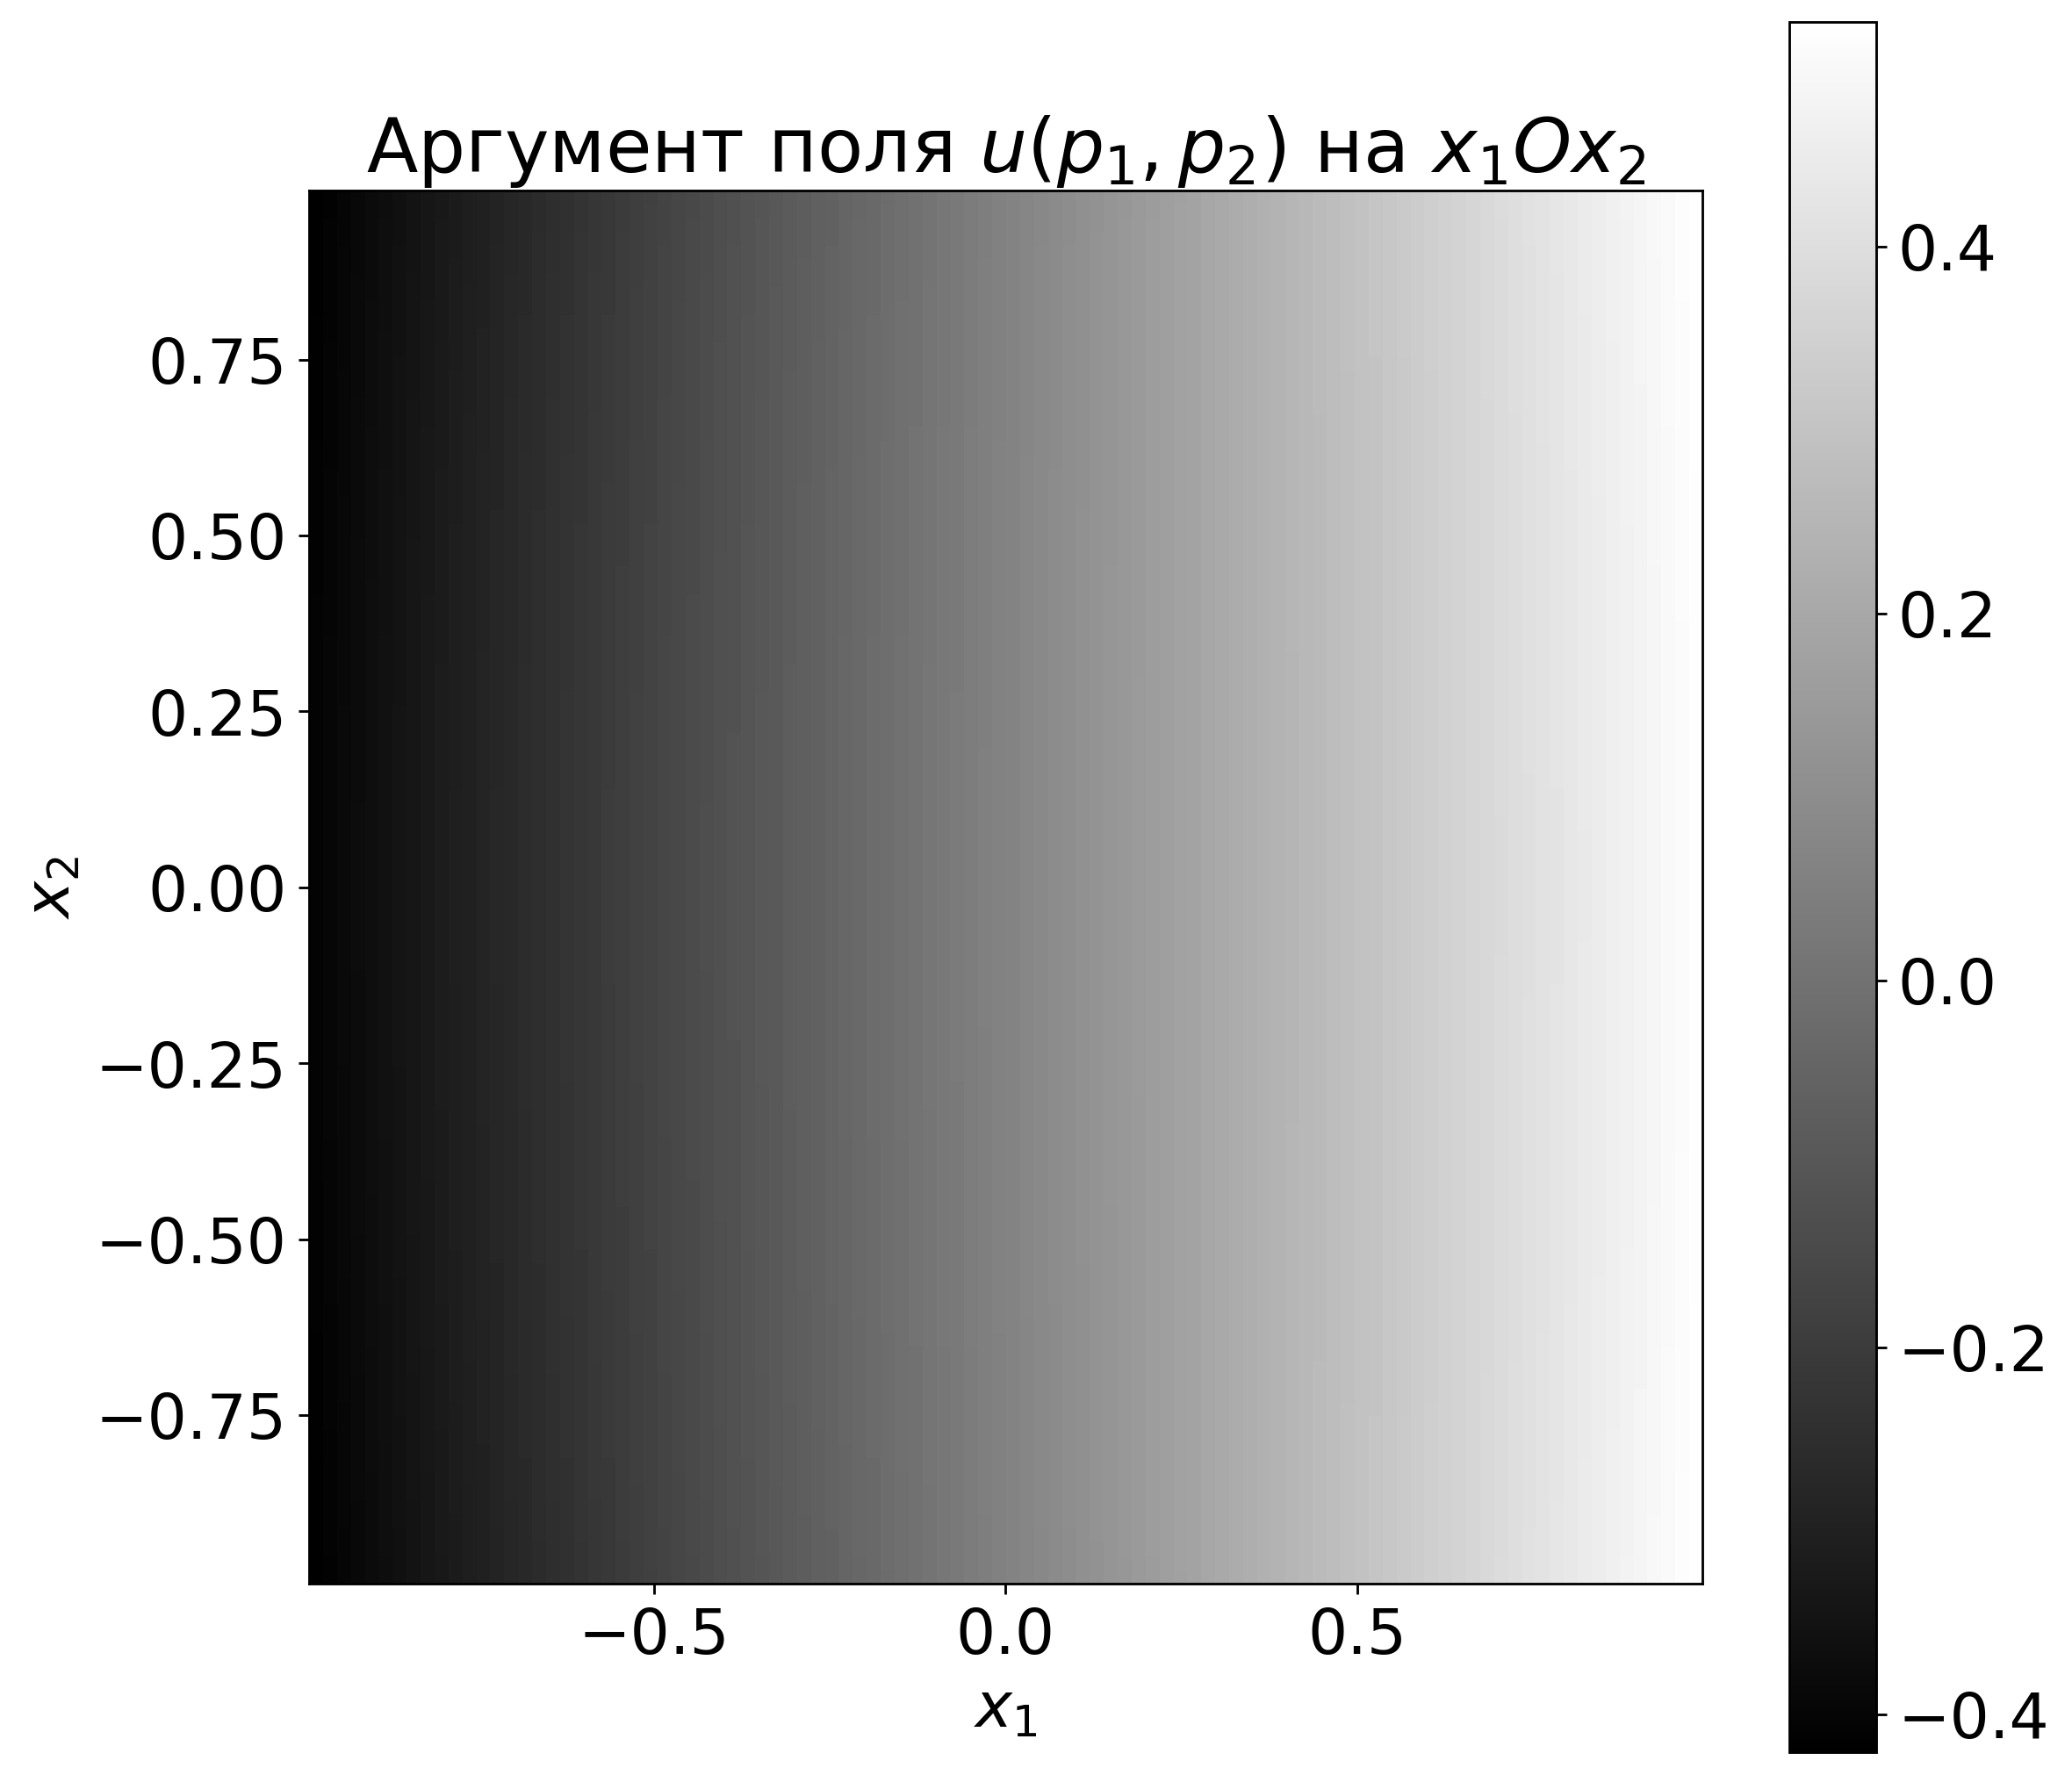

In [24]:
title = r"Аргумент поля $u(p_1, p_2)$ на $x_1Ox_2$"
boundaries = [np.min(grid[:,:,:, 0]), 
              np.max(grid[:,:,:, 0]), 
              np.min(grid[:,:,:, 1]), 
              np.max(grid[:,:,:, 1])]
dpi=256
figsize=(10,10)
plot_scalar_xy(np.angle(result_TS), title=title, boundaries=boundaries, dpi=dpi, figsize=figsize)
plot_scalar_xy(np.angle(result_BICGStab), title=title, boundaries=boundaries, dpi=dpi, figsize=figsize)
plot_scalar_xy(np.angle(result_SIM), title=title, boundaries=boundaries, dpi=dpi, figsize=figsize)

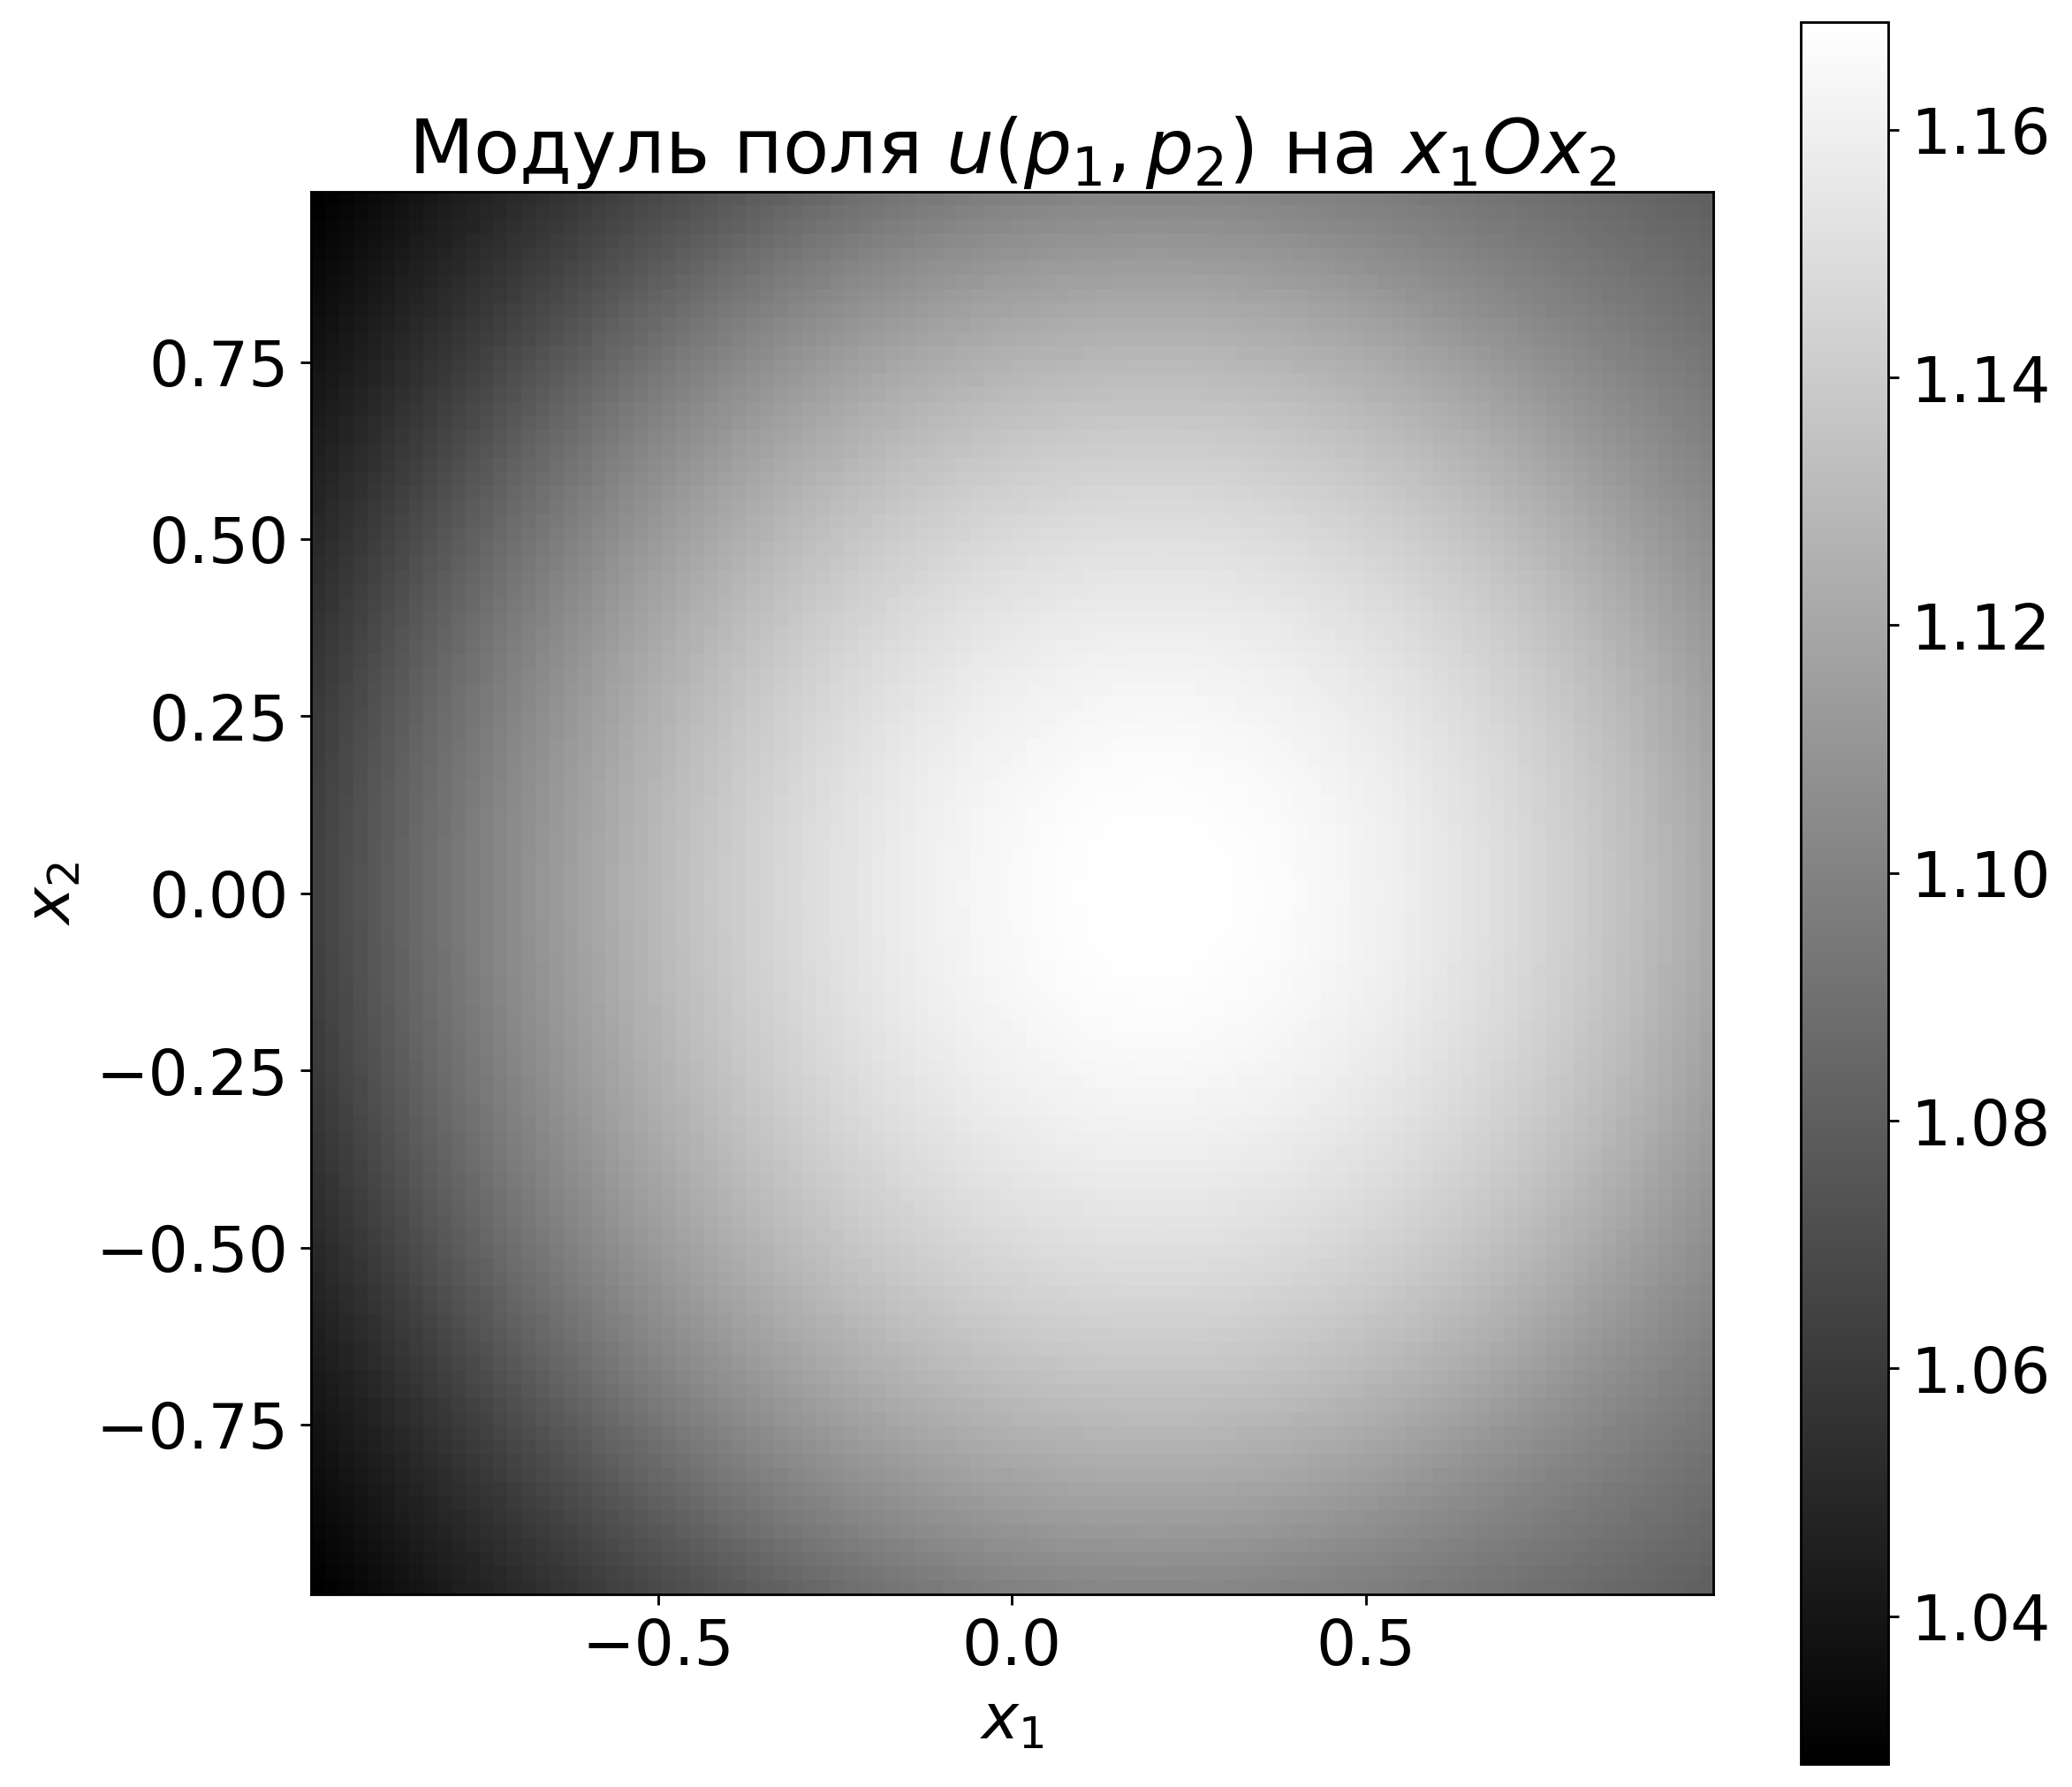

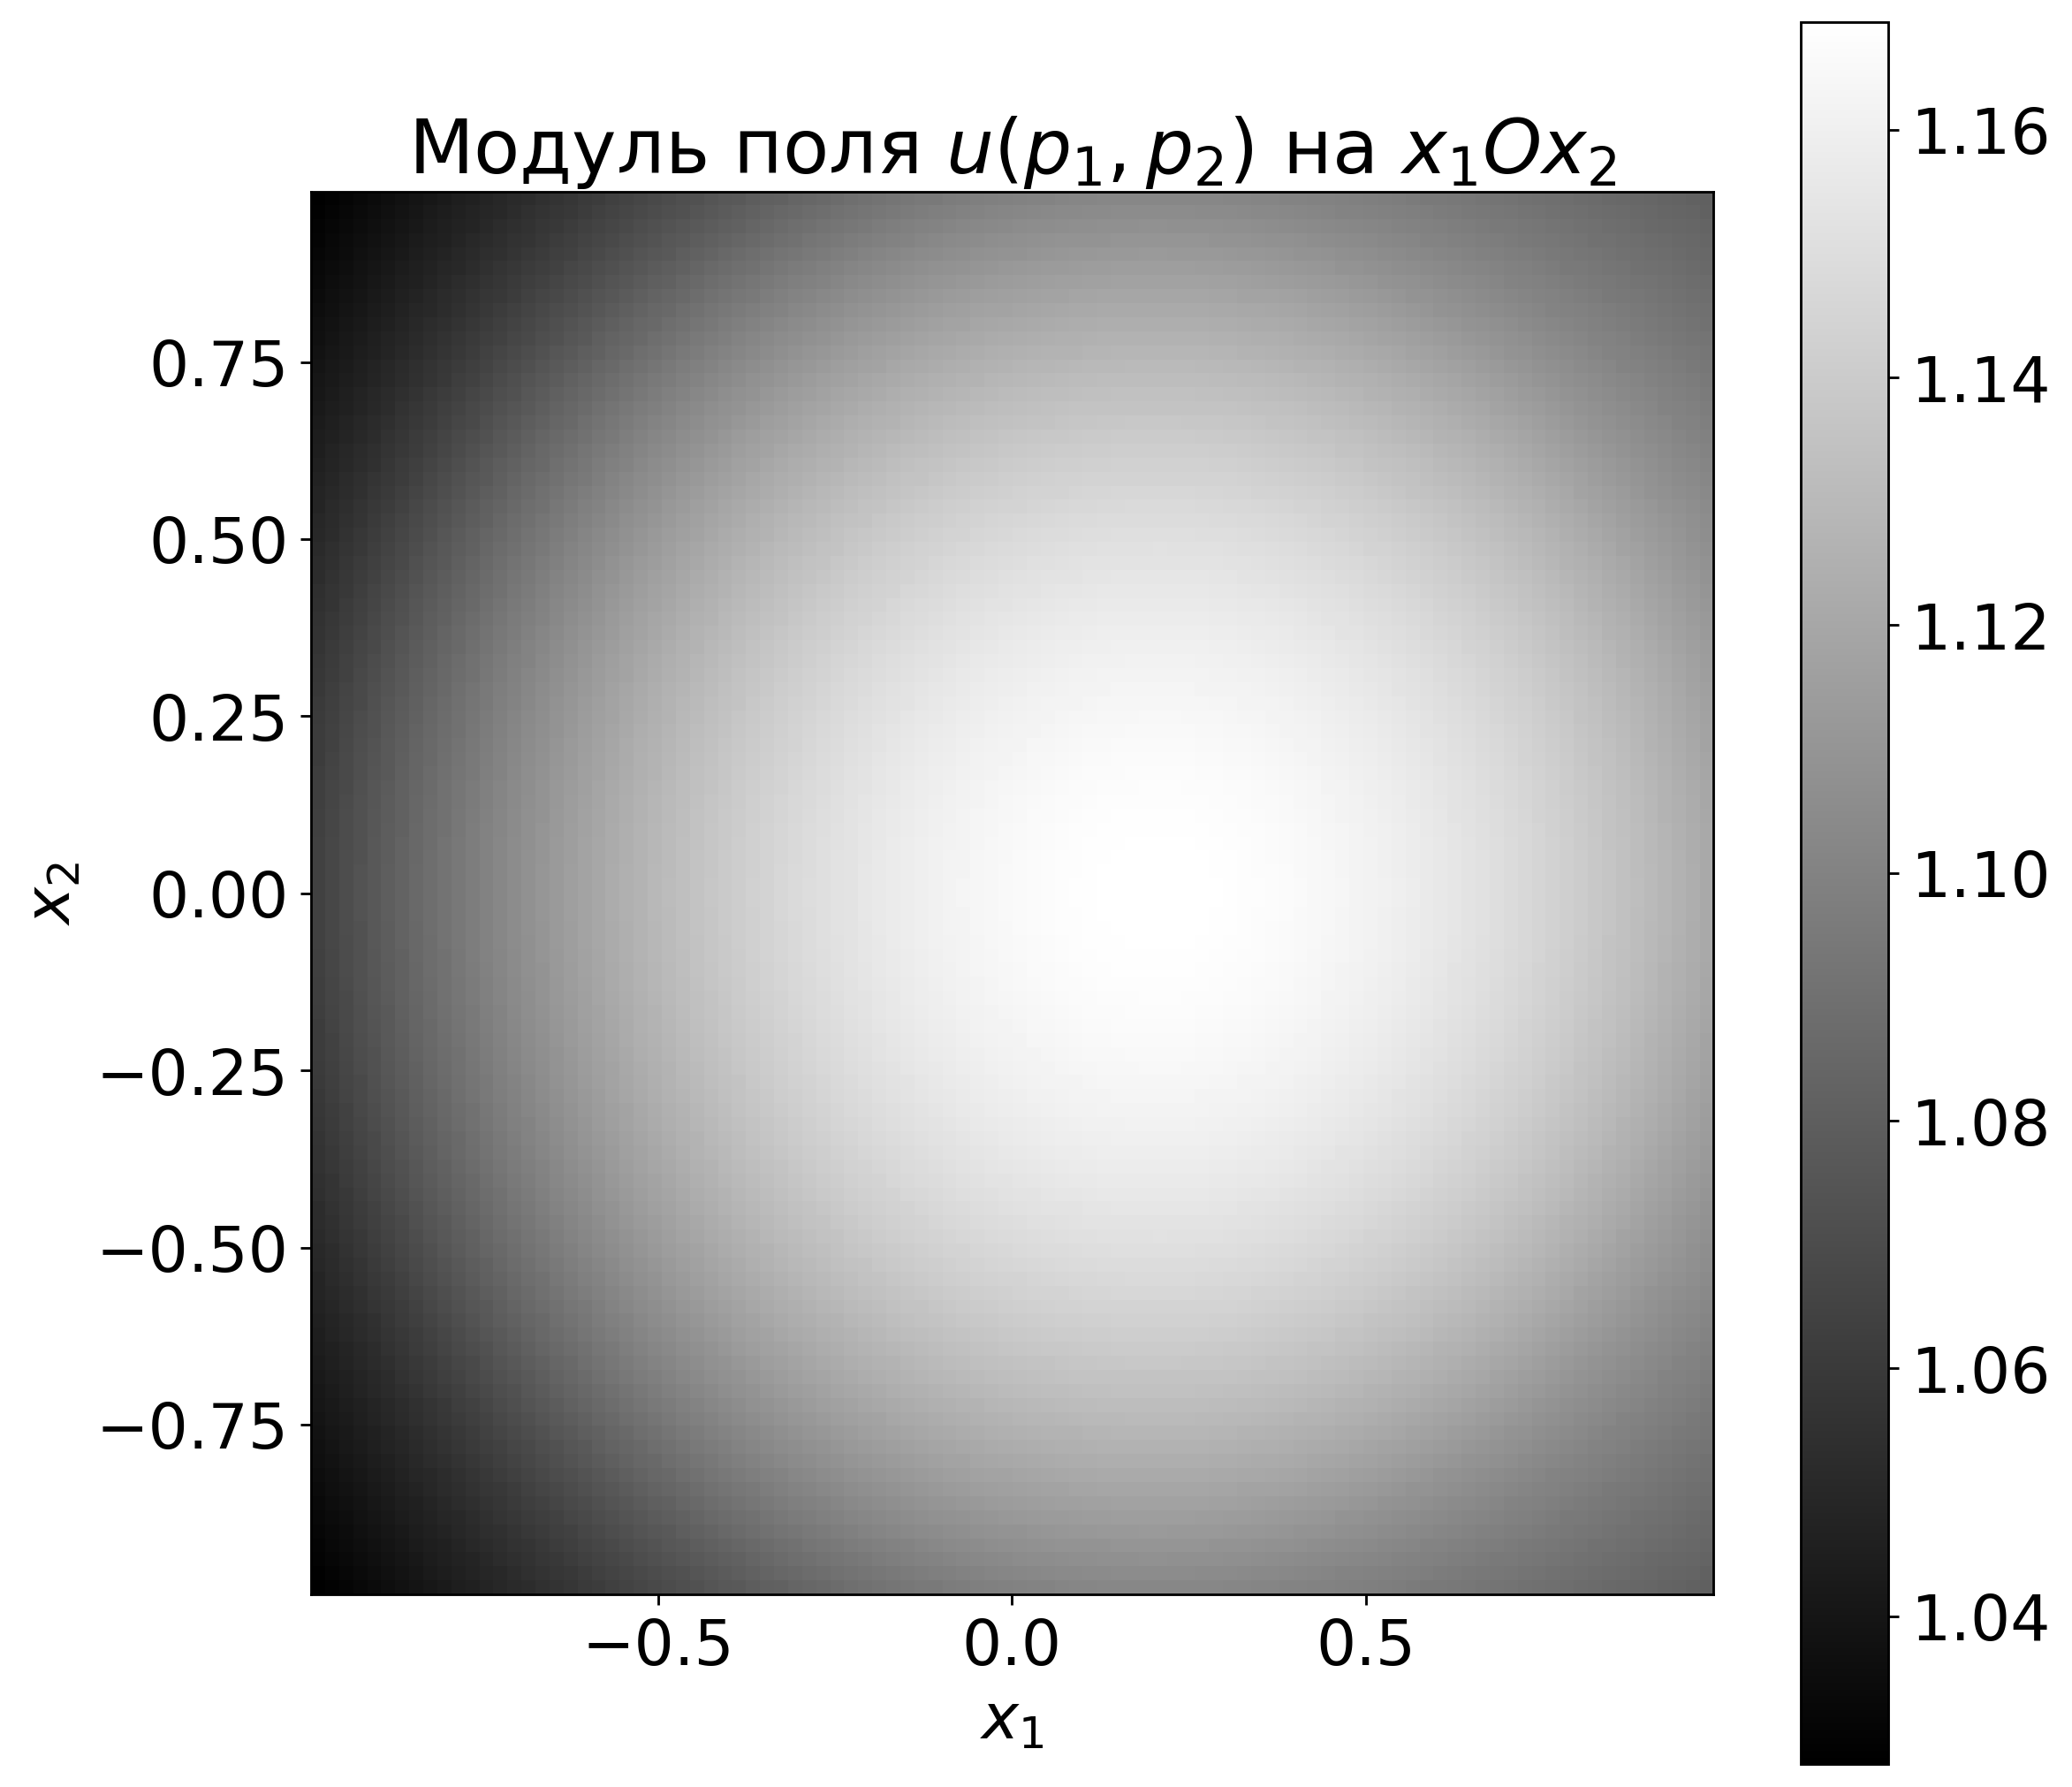

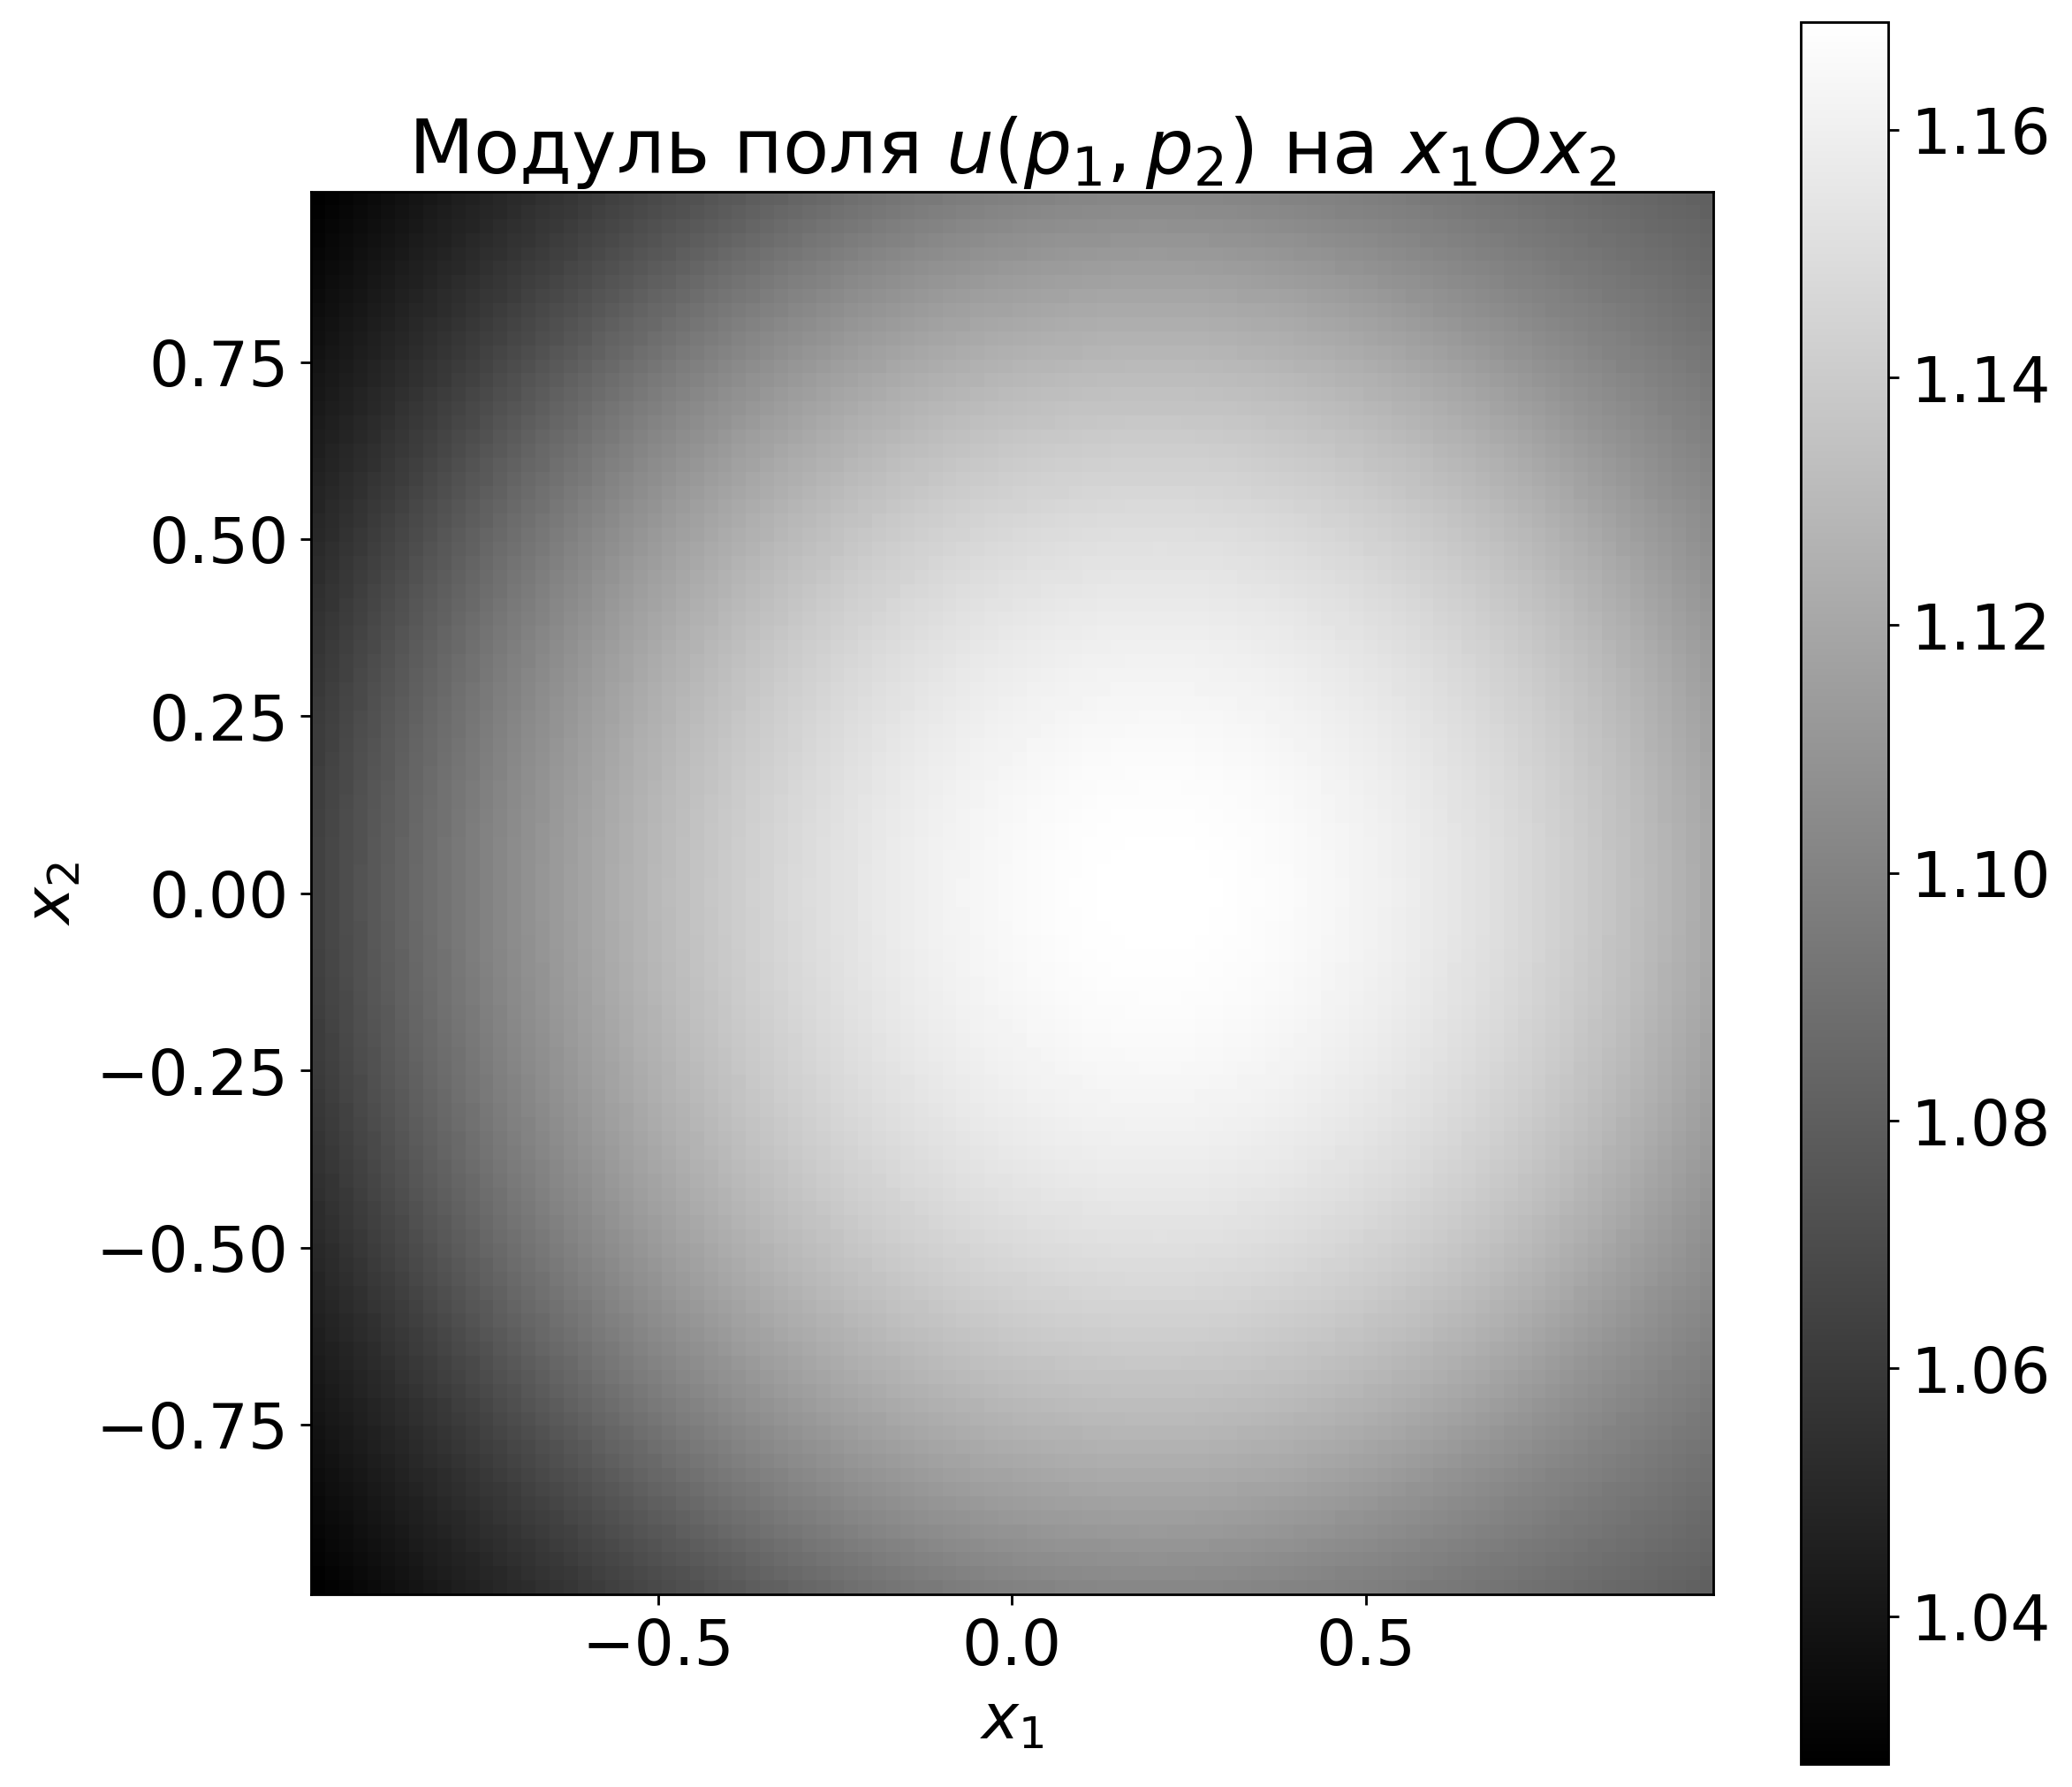

In [25]:
title = r"Модуль поля $u(p_1, p_2)$ на $x_1Ox_2$"
boundaries = [np.min(grid[:,:,:, 0]), 
              np.max(grid[:,:,:, 0]), 
              np.min(grid[:,:,:, 1]), 
              np.max(grid[:,:,:, 1])]
dpi=256
figsize=(10,10)
plot_scalar_xy(np.abs(result_TS), title=title, boundaries=boundaries, dpi=dpi, figsize=figsize)
plot_scalar_xy(np.abs(result_BICGStab), title=title, boundaries=boundaries, dpi=dpi, figsize=figsize)
plot_scalar_xy(np.abs(result_SIM), title=title, boundaries=boundaries, dpi=dpi, figsize=figsize)

In [26]:
rcs, angles, diff_rcs, total_rcs = rcs_acoustic(scalar_field=result_TS, eta=eta.get(), grid=grid, in_Q=indexes.get(), volume=volume, k_0=k_wave, n_phi=360)

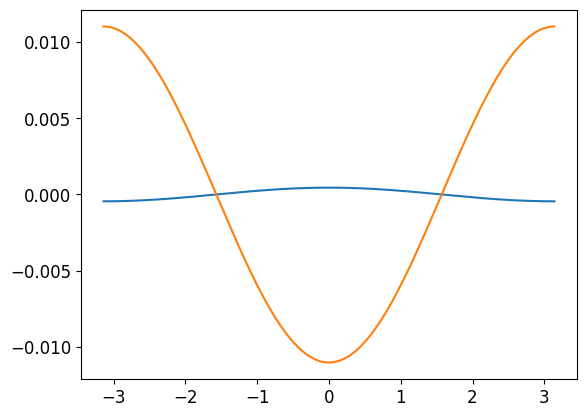

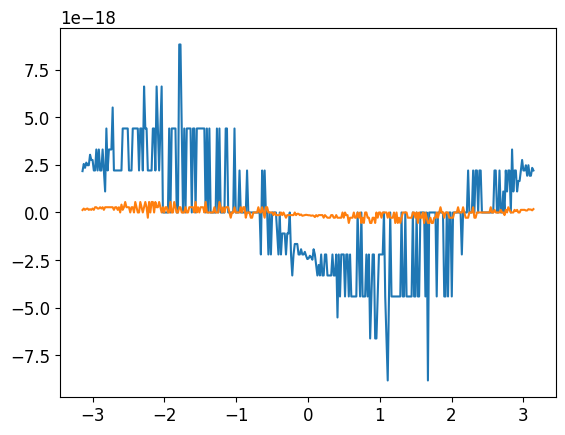

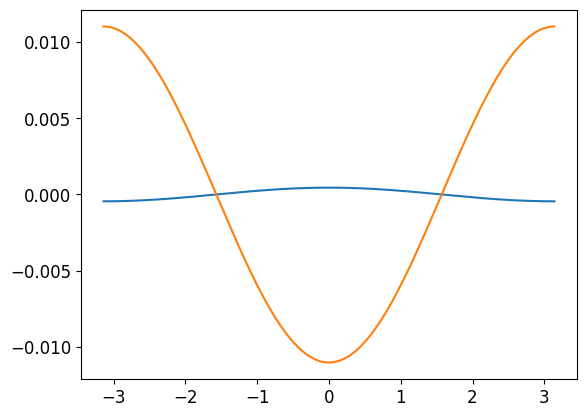

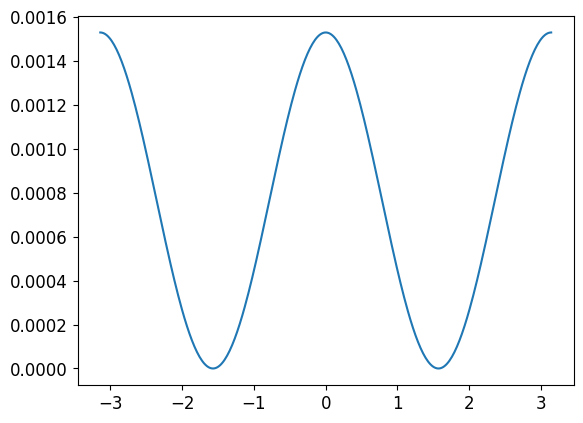

[0.004829928099273665, 7.039062712485921e-34, 0.004829928099273665]

In [27]:
plt.plot(angles[0], rcs[0].real)
plt.plot(angles[0], rcs[0].imag)
plt.show()

plt.plot(angles[1], rcs[1].real)
plt.plot(angles[1], rcs[1].imag)
plt.show()

plt.plot(angles[2], rcs[2].real)
plt.plot(angles[2], rcs[2].imag)
plt.show()

plt.plot(angles[0], diff_rcs[0])
plt.show()

total_rcs

# Сеточная сходимость методов для задачи

- Размеры сетки 5, 15, 45, 135
- Значение поля * объем относительно 


In [28]:
# Полная постановка задачи
problem_config = {
    'N': [100, 100, 100],
    'N_spectre': [15, 15, 15],
    'L': [1.0, 1.0, 1.0],
    'center': [0.0, 0.0, 0.0],
    'k': 12,
    'orient': [1.0, 1.0, 1.0],
    'amplitude': 1.0,
    'env_value_real': 0.333,
    'env_value_imag': 0.0,
    'sign': 1.0,
    'eps_vec': [
        {
            "type": "ellipsis",
            "eps_real": 1.417,
            "eps_imag": 0.0,
            "center": [0.0, 0.0, 0.0],
            "radius": [0.35, 0.35, 0.35]
        }
    ]
}

path_to_folder = "grid_convergence"
if not os.path.isdir(path_to_folder):
    os.makedirs(path_to_folder)

volume_list = []
results_SIM_list = []
results_BiCGStab_list = []
results_TS_list = []
n_list = [5, 15, 45, 135]
for n in n_list:
    N = [n, n, n]
    n_spectre = n if n <= 15 else 15
    N_spectre = [n_spectre, n_spectre, n_spectre]
    problem_config["N"] = [n, n, n]
    problem_config["N_spectre"] = [n_spectre, n_spectre, n_spectre]

    l = problem_config.get("L")
    c = problem_config.get("center")
    eps_vec = problem_config.get("eps_vec")
    env_value = problem_config.get("env_value_real") + 1j * problem_config.get('env_value_imag')
    k = problem_config.get("k")
    mu, radius, rho = get_params_from_grid(N_spectre, l, c, k, eps_vec, env_value)
    
    # Решение задачи на основной сетке
    n_1 = problem_config.get('N')[0]
    n_2 = problem_config.get('N')[1]
    n_3 = problem_config.get('N')[2]
    to_reshape = [n_3, n_2, n_1]
    # Трехмерная сетка
    grid, volume = make_grid(**problem_config)
     # Индекс рефракции среды, определенный в точках сетки
    eta, indexes = apply_refraction(grid, method='sub', env_value=env_value, **problem_config)
    # Внешняя волна, определенная в точках сетки
    f_wave = flat_wave_scalar(grid, **problem_config)
    # Определение массива дисркетизированного ядра оператора
    dists = np.sqrt(np.sum((grid[0, 0, 0] - grid)**2, axis = 3))
    dists[0, 0, 0] = 10e-8
    # Заполнение первой строки матрицы 
    G_array = kernel(dists, **problem_config) * volume
    G_array[0, 0, 0] = 0
    print(G_array.shape)
    # Коэффициенты B в Фурье-образе
    prep_coeffs = prep_fftbbtensor(G_array)
    # Сопряженные коэффициенты в Фурье-образе
    prep_conj_coeffs = prep_fftbbtensor(np.conj(G_array))
    # На GPU
    grid = cp.array(grid, dtype=float)
    eta = cp.array(eta, dtype=complex)
    indexes = cp.array(indexes, dtype=bool)
    f_wave = cp.array(f_wave, dtype=complex)
    G_array = cp.array(G_array, dtype=complex)
    prep_coeffs = cp.array(prep_coeffs)
    prep_conj_coeffs = cp.array(prep_conj_coeffs)
    # Умножение внешней волны на ядро оператора
    u0_array = -1.0 * prep_fbbtmv(prep_coeffs, f_wave)
    # ОМПИ
    result_SIM, iters_SIM, eps_SIM, resid_SIM = \
    SIM((k**2) * prep_coeffs, f=u0_array, eta=eta, operator=operator, 
        mu=mu, u0=None, rtol=1e-8, max_iter=1000, log=False)
    # Двухшаговый метод
    result_TS, iters_TS, eps_TS, resid_TS = \
    TwoStep(coeffs=(k**2) * prep_coeffs, conj_coeffs=(k**2) *prep_conj_coeffs, 
            f=u0_array, eta=eta, operator=operator, conj_operator=conj_operator,
            u0=None, rtol=1e-8, max_iter=1000, log=False)
    # Метод биспоряженных градиентов
    result_BICGStab, iters_BICGStab, eps_BICGStab, resid_BICGStab = \
    bicgstab(coeffs=(k**2) * prep_coeffs, f=u0_array, eta=eta, operator=operator,
             u0=None, rtol=1e-8, max_iter=1000, log=False)

    volume_list.append(volume)
    results_SIM_list.append(result_SIM.get())
    results_BiCGStab_list.append(result_BICGStab.get())
    results_TS_list.append(result_TS.get())

No circle found.
(5, 5, 5)
достичь нужной точности смогли быстрее
Circle center: (1.576072550595271-1.2793307935197207j), radius: 1.773703868579986
(15, 15, 15)
Circle center: (1.576072550595271-1.2793307935197207j), radius: 1.773703868579986
(45, 45, 45)
Метод вырождается
Circle center: (1.576072550595271-1.2793307935197207j), radius: 1.773703868579986
(135, 135, 135)


In [29]:
results_SIM_list[1]

array([[[-0.01416057+7.25592084e-03j, -0.01119275+1.23906644e-02j,
         -0.00704519+1.42037534e-02j, ..., -0.00195176-3.94266756e-03j,
         -0.00208968-3.33429517e-03j, -0.00208085-3.65591715e-03j],
        [-0.01119275+1.23906644e-02j, -0.00682486+1.63595179e-02j,
         -0.00210219+1.60732204e-02j, ..., -0.00522986-1.21620403e-03j,
         -0.00535991-9.16692528e-04j, -0.00517773-1.94034832e-03j],
        [-0.00704519+1.42037534e-02j, -0.00210219+1.60732204e-02j,
          0.00274742+1.33721089e-02j, ..., -0.00864137+2.44541337e-03j,
         -0.0087233 +1.86860078e-03j, -0.00803871-2.22539877e-05j],
        ...,
        [-0.00195176-3.94266756e-03j, -0.00522986-1.21620403e-03j,
         -0.00864137+2.44541337e-03j, ...,  0.01317444+1.69683235e-02j,
          0.00734852+1.90025802e-02j,  0.00011429+1.78064239e-02j],
        [-0.00208968-3.33429517e-03j, -0.00535991-9.16692528e-04j,
         -0.0087233 +1.86860078e-03j, ...,  0.00734852+1.90025802e-02j,
          0.00116928

# Эксперименты с различными условиями 
- Рефракция (Алмаз в воде, Алмаз в свободной среде, Кварц в свободной среде)
- Вид объемной области (Сфера, Прямоугольный параллелепипед, Циллиндр)
- Направление внешнего узлучения $orient$
- Длина волны $k$
- Разбиение области $n$

In [30]:
# import os
# materials = ["diamond_water", "diamond_air", "quartz_air"]
# shapes = ["shpere", "square", "cylinder"]
# exps = ['exp_k', 'exp_n', 'exp_orient']

# problem_config = {
#     'N': [100, 100, 100],
#     'N_spectre': [12, 12, 12],
#     'L': [2.0, 2.0, 2.0],
#     'center': [0.0, 0.0, 0.0],
#     'k': 0.0,
#     'orient': [1.0, 0.0, 0.0],
#     'amplitude': 1.0,
#     'point': [-2.0, 0.0, 0.0],
#     'env_value': 0.0,
#     'sign': 1.0,
#     'eps_vec': [
#         {
#             "type": "ellipsis",
#             "eps_real": 1.417,
#             "eps_imag": 1.417,
#             "center": [0.0, 0.0, 0.0],
#             "radius": [0.5, 0.5, 0.5]
#         }
#     ]
# }

# configs = {
#     'diamond_water': {
#         'eps_real': 1.417,
#         'eps_imag': 0.0,
#         'env_real': 0.333,
#         'env_imag': 0.0
#     },
#     'diamond_air': {
#         'eps_real': 1.417,
#         'eps_imag': 0.0,
#         'env_real': 0.0,
#         'env_imag': 0.0
#     },
#     'quartz_air': {
#         'eps_real': 0.458,
#         'eps_imag': 0.0,
#         'env_real': 0.0,
#         'env_imag': 0.0
#     },
#     "sphere": {
#         'eps_vec': [
#             {
#                 'type': 'ellipsis',
#                 'eps_real': 1.0,
#                 'eps_imag': 0.0,
#                 'radius': [1.0, 1.0, 1.0],
#                 'center': [0., 0., 0.]
#             }
#         ]
#     },
#     "square": {
#         'eps_vec': [
#             {
#                 'type': 'step',
#                 'eps_real': 1.0,
#                 'eps_imag': 0.0,
#                 'x1_bounds': [-0.8, 0.8],
#                 'x2_bounds': [-0.8, 0.8],
#                 'x3_bounds': [-0.8, 0.8]
#             }
#         ]
#     },
#     "cylinder": {
#         'eps_vec': [
#             {
#                 'type': 'cylinder',
#                 'eps_real': 1.0,
#                 'eps_imag': 0.0,
#                 'radius': [1.0, 1.0, 1.0],
#                 'center': [0., 0., 0.],
#                 'axis': 2
#             }
#         ]
#     },
#     'exp_k': {
#         'N': [100, 100, 100],
#         'k': np.arange(0, 30, 0.5),
#         'orient': [1.0, 0.0, 0.0]
#     },
#     'exp_n': {
#         'N': 
#     }
# }

# for material in materials:
#     if not os.path.isdir(material):
#         for shape in shapes:
#             path_to_shape = os.path.join(material, shape)
#             for exp in exps:
#                 path_to_exp = os.path.join(material, shape, exp) 
#                 os.makedirs(path_to_exp)

#                 N = configs.get(exp).get('N')
#                 k = configs.get(exp).get('k')
#                 orient = configs.get(exp).get('k')
                
                
# # 